# Optimise on a single quad scan

In [30]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

OSError: JVM is already started

In [22]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

In [7]:
filename_list = ["quad_scan_east_dump_2022_04_11_13h17m30s","quad_scan_east_dump_2022_04_11_13h47m05s", "quad_scan_east_dump_2022_04_11_14h28m24s", "quad_scan_east_dump_2022_04_11_14h44m15s", "quad_scan_east_dump_2022_04_11_15h03m36s"]

start_path = "/afs/cern.ch/user/e/eljohnso/Desktop/quad-scan-east"
end_path = "quad_scan_east_dump_data"
filename = filename_list[0]


infile = open(end_path+"/"+filename+"/"+filename+".p", 'rb')
loaded_pickle = pickle.load(infile)

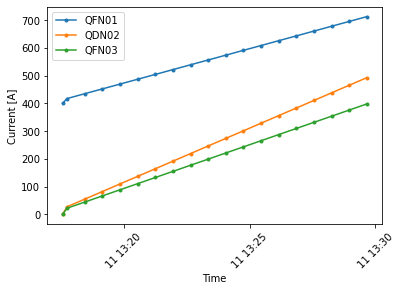

In [19]:
timestamp_list = loaded_pickle[0]

acquisition = loaded_pickle[1]["F61D.BTV010/Acquisition"]
    
fig, ax = plt.subplots()

qfn01_current = loaded_pickle[3]['F61.QFN01/MEAS.PULSE#VALUE']
qdn02_current = loaded_pickle[3]['F61.QDN02/MEAS.PULSE#VALUE']
qfn03_current = loaded_pickle[3]['F61.QFN03/MEAS.PULSE#VALUE']

ax.plot(timestamp_list, qfn01_current, marker = "o", markersize=3, label = "QFN01")
ax.plot(timestamp_list, qdn02_current, marker = "o", markersize=3, label = "QDN02")
ax.plot(timestamp_list, qfn03_current, marker = "o", markersize=3, label = "QFN03")

ax.tick_params('x', labelrotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Current [A]")
ax.legend()

Text(0.5, 1.0, 'Beam size')

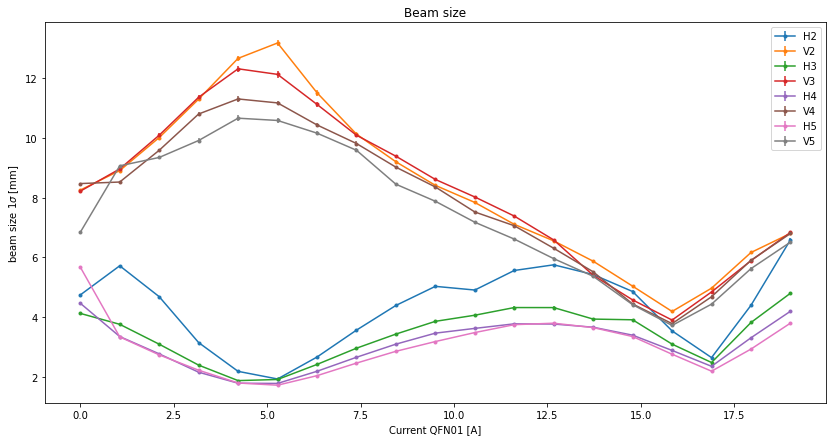

In [23]:
fig, ax = plt.subplots(figsize=(14,7))

range_shots = [0,len(acquisition)]
x_axis = np.linspace(0,19,len(acquisition))

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

        
    ax.errorbar(x_axis, H_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = H_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"H{acq_number}")
    ax.errorbar(x_axis, V_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = V_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"V{acq_number}")
ax.legend()
ax.set_xlabel("Current QFN01 [A]")
ax.set_ylabel(f"beam size 1$\sigma$ [mm]")
ax.set_title("Beam size")

In [31]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

In [33]:
# Initial conditions East Area
betx0 = 81.278
bety0 = 3.024
alfx0 = -19.03
alfy0 = 1.889
Dx0 = -7.708
Dy0 = -1.981
Dpx0 = -1.938
Dpy0 = -0.01
exn = 1.463e-06
eyn = 1.499e-06
sige = 0.000761115

In [34]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []

current1 = qfn01_current[range_shots[0]:range_shots[1]:]
current2 = qdn02_current[range_shots[0]:range_shots[1]:]
current3 = qfn03_current[range_shots[0]:range_shots[1]:]

for i in range(len(current1)):
    quad_current["QFN01"] = current1[i]
    quad_current["QDN02"] = current2[i]
    quad_current["QFN03"] = current3[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")
    
    madx.use(sequence="f61d")
    # Initial settings
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    
    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

Text(0.5, 1.0, 'Multi Quad Scan BTV010')

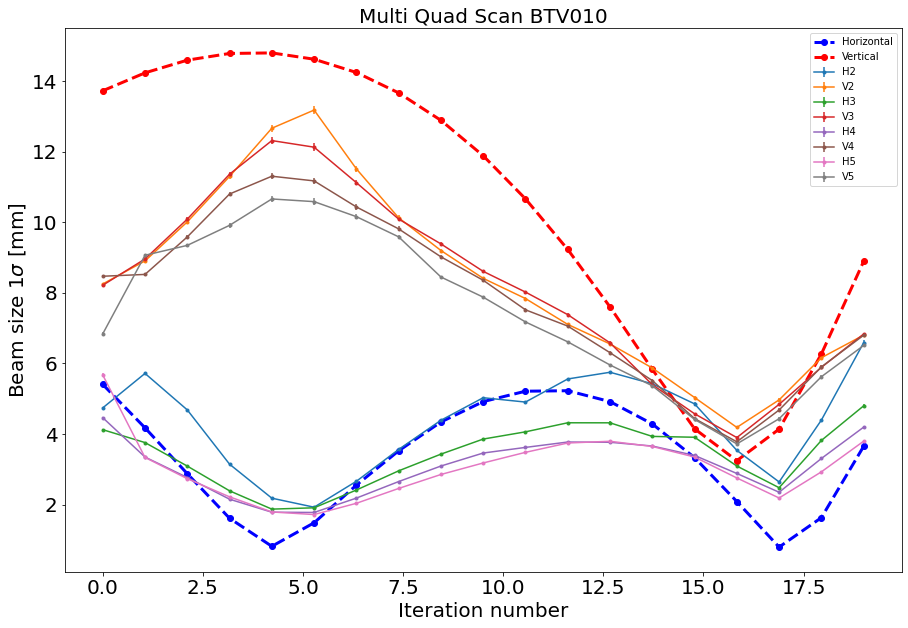

In [45]:
fig, ax = plt.subplots(figsize=(15,10))

H_sigma_list = []
V_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

        
    ax.errorbar(x_axis, H_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = H_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"H{acq_number}")
    ax.errorbar(x_axis, V_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = V_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"V{acq_number}")

    H_sigma_list.append(H_sigma_list_i)
    V_sigma_list.append(V_sigma_list_i)
    
ax.plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", linestyle = "--", marker = "o", linewidth=3, label = "Horizontal")
ax.plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", linestyle = "--", marker = "o", linewidth=3, label = "Vertical")


ax.legend()
ax.set_xlabel("Iteration number", fontsize=20)
ax.set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=18)
fig.savefig("fig/madx_"+str(filename)+".png", facecolor='white', transparent=False,
                    bbox_inches='tight', dpi=150);
ax.set_title("Multi Quad Scan BTV010", fontsize = 20)

# Optimize with different starting parameter

In [ ]:
# Py-BOBYQA example: minimize the Rosenbrock function
from __future__ import print_function
import pybobyqa

exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


# Define the objective function
def f_fit(params):
    print(params)
    betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params

    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)
    

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

    madx.input('SEQEDIT, SEQUENCE=f61d;')
    madx.input('FLATTEN;')
    madx.input('REMOVE, ELEMENT=ARBMATRIX;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    
    
    H_sigma_madx = []
    V_sigma_madx = []

    current1 = qfn01_current[range_shots[0]:range_shots[1]:]
    current2 = qdn02_current[range_shots[0]:range_shots[1]:]
    current3 = qfn03_current[range_shots[0]:range_shots[1]:]

    for i in range(len(current1)):
        quad_current["QFN01"] = current1[i]
        quad_current["QDN02"] = current2[i]
        quad_current["QFN03"] = current3[i]

        madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
        madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
        madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")

        madx.use(sequence="f61d")
        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
        V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

    deltaH = abs(H_sigma_list[2] - np.array(H_sigma_madx)*1000)**2 # Here you have to choose with acquisition to optimise. I choose acq 4
    deltaV = abs(V_sigma_list[2] - np.array(V_sigma_madx)*1000)**2
    
    objective = sum(deltaH) + sum(deltaV)
        
    print (objective)
    return (objective)

# Define the starting point
# initial_guess = [82.4, 33.2, -11.1, 0.28, 0.13, 0.0, 0.02, 0.0, 1.5e-6, 1.5e-6, 7.53e-4]
initial_guess = [8.10320374e+01, 1.75850966e+00, -1.24235188e+01, 1.38448554e+00, -4.89293824e+00, -9.90627329e-01, -1.26489793e+00, -3.91133201e-02, 1.49710514e-06, 1.48850811e-06, 7.50894919e-04]

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, 1, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.0])
upper = np.array([150, 150, 100, 100, 100, 100, 100, 100, 5.0e-6, 5.0e-6, 20.0e-4])


# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-8, maxfun=10000)

# Display output
print(soln)

[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
68.36354252552563
[ 1.50000000e+02  1.75850966e+00 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
628.0516914290151
[ 8.10320374e+01  7.62585097e+01 -1.24235188e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
682.7353904921277
[ 8.10320374e+01  1.75850966e+00  8.75764812e+01  1.38448554e+00
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
36388.41323485739
[ 8.10320374e+01  1.75850966e+00 -1.24235188e+01  1.00000000e+02
 -4.89293824e+00 -9.90627329e-01 -1.26489793e+00 -3.91133201e-02
  1.49710514e-06  1.48850811e-06  7.50894919e-04]
3868432.8744287286
[ 8.10320

238809.99774752237
[ 8.08096354e+01  5.86690849e+00 -7.31078528e+00  2.82938911e+00
 -5.11896921e+00 -8.22698915e-01 -1.01794764e+00 -1.86745786e-01
  0.00000000e+00  1.35044137e-06  7.83467924e-04]
107.56266999942504
[ 8.08842270e+01  2.01456236e+00 -1.25330029e+01  1.13188665e+00
 -1.43453839e+01 -9.50183611e-01 -1.25328497e+00 -2.78922603e-04
  8.03559183e-08  1.49513682e-06  7.52038969e-04]
12727.81093463916
[ 8.28121065e+01  4.62139245e+00 -1.85134231e+01  4.00838417e+00
 -5.40199241e+00 -2.05215865e-01 -1.33513380e+00 -7.95748795e-02
  0.00000000e+00  1.59112933e-06  7.93108383e-04]
105.27480578248546
[ 8.30036638e+01  2.74310278e+00 -1.21308276e+01  1.76528204e+00
 -5.05103684e+00 -3.13092734e-01 -1.26295948e+00  2.35011848e-01
  0.00000000e+00  1.39572984e-06  7.37905855e-04]
135.86325545496638
[ 8.10469223e+01  1.48032653e+00 -1.22722410e+01  1.52725627e+00
 -4.47146092e+00 -5.70220035e-01 -8.56950445e-01  3.57979011e-01
  5.80231838e-08  1.48915108e-06  7.50570797e-04]
114.44

43.655790371468136
[ 8.08418356e+01  1.53110417e+00 -1.22898819e+01  1.37600862e+00
 -5.08601417e+00 -1.22433419e+00 -1.28000510e+00  1.21762130e-01
  4.87308327e-09  1.49165127e-06  7.49790378e-04]
43.5635994745779
[ 8.08411416e+01  1.52855426e+00 -1.22889509e+01  1.37721147e+00
 -5.08444314e+00 -1.23120490e+00 -1.28315537e+00  1.21143111e-01
  4.94840187e-09  1.49175107e-06  7.49787032e-04]
43.340597401504716
[ 8.08391693e+01  1.52310856e+00 -1.22873012e+01  1.37762544e+00
 -5.07995919e+00 -1.23441216e+00 -1.28436427e+00  1.20165751e-01
  4.96929479e-09  1.49174704e-06  7.49769331e-04]
43.324249217867035
[ 8.08399743e+01  1.51972805e+00 -1.22902805e+01  1.37994342e+00
 -5.08247145e+00 -1.23524852e+00 -1.28963003e+00  1.22020184e-01
  5.05738830e-09  1.49183357e-06  7.49757429e-04]
43.243657673614
[ 8.08384750e+01  1.51788070e+00 -1.22882428e+01  1.37963168e+00
 -5.08878645e+00 -1.23823761e+00 -1.28793790e+00  1.21643739e-01
  5.14279035e-09  1.49185584e-06  7.49803548e-04]
43.0837567

35.62567382165402
[ 8.07519782e+01  1.56205331e+00 -1.20494824e+01  1.45791880e+00
 -5.31521662e+00 -1.51589333e+00 -1.33370584e+00  1.99236041e-01
  1.18320027e-08  1.49101687e-06  7.48670555e-04]
34.53816355516746
[ 8.07478804e+01  1.56142439e+00 -1.20540156e+01  1.45573646e+00
 -5.31558993e+00 -1.51863620e+00 -1.31920416e+00  1.98502868e-01
  1.19942940e-08  1.49119429e-06  7.48613354e-04]
35.14825511390669
[ 8.07554337e+01  1.55912245e+00 -1.20492065e+01  1.46252545e+00
 -5.31408545e+00 -1.51980084e+00 -1.33135883e+00  2.02076173e-01
  1.17874989e-08  1.49107118e-06  7.48689798e-04]
34.620396725534924
[ 8.07523924e+01  1.56643395e+00 -1.20530010e+01  1.46102913e+00
 -5.31758053e+00 -1.51890305e+00 -1.33442841e+00  2.00945880e-01
  1.19334361e-08  1.49104261e-06  7.48697845e-04]
34.42739250262838
[ 8.07540070e+01  1.56746735e+00 -1.20527983e+01  1.45861825e+00
 -5.32409519e+00 -1.51947901e+00 -1.33292215e+00  2.02655290e-01
  1.20270439e-08  1.49101809e-06  7.48747424e-04]
34.351875

29.93881449724924
[ 8.06992752e+01  1.61601723e+00 -1.18628916e+01  1.53171826e+00
 -5.71917841e+00 -1.81090272e+00 -1.45321807e+00  2.99022870e-01
  2.20919322e-08  1.49065122e-06  7.49269478e-04]
29.567545645693873
[ 8.07016897e+01  1.62824626e+00 -1.18661361e+01  1.55771718e+00
 -5.73169812e+00 -1.81768376e+00 -1.44193115e+00  3.02128150e-01
  2.20320697e-08  1.49031580e-06  7.49165520e-04]
29.64733189386414
[ 8.07021670e+01  1.61684217e+00 -1.18746411e+01  1.53152527e+00
 -5.72307968e+00 -1.81316929e+00 -1.44616930e+00  2.98589235e-01
  2.22094420e-08  1.49079545e-06  7.49379029e-04]
29.430191591961954
[ 8.06933598e+01  1.61725573e+00 -1.18746478e+01  1.53329938e+00
 -5.71638408e+00 -1.81035731e+00 -1.44660695e+00  2.99415020e-01
  2.25422501e-08  1.49072532e-06  7.49336490e-04]
29.445729246712233
[ 8.07015388e+01  1.61682092e+00 -1.18791189e+01  1.53150430e+00
 -5.72757791e+00 -1.81002406e+00 -1.45095856e+00  2.97423941e-01
  2.22155349e-08  1.49086883e-06  7.49338854e-04]
29.3829

27.81370800776308
[ 8.07584110e+01  1.54472867e+00 -1.18123582e+01  1.47667714e+00
 -5.83093338e+00 -1.74628371e+00 -1.47486306e+00  2.94414603e-01
  2.46093483e-08  1.49052155e-06  7.49998536e-04]
27.825200631171427
[ 8.07548205e+01  1.54922318e+00 -1.18165251e+01  1.47569425e+00
 -5.83338586e+00 -1.75469620e+00 -1.47764938e+00  2.94424022e-01
  2.46874165e-08  1.49057390e-06  7.49943466e-04]
27.85305743931228
[ 8.07535085e+01  1.55058257e+00 -1.18174192e+01  1.47864848e+00
 -5.83049864e+00 -1.75272598e+00 -1.47281447e+00  2.96309567e-01
  2.46857076e-08  1.49059893e-06  7.49923596e-04]
27.891488523258573
[ 8.07598362e+01  1.54948385e+00 -1.18156008e+01  1.48239215e+00
 -5.83489018e+00 -1.74685008e+00 -1.47695151e+00  2.95529033e-01
  2.48086693e-08  1.49039482e-06  7.49968835e-04]
27.82108485284401
[ 8.07593932e+01  1.54894059e+00 -1.18077569e+01  1.47985208e+00
 -5.83071800e+00 -1.74733013e+00 -1.47814619e+00  2.93391769e-01
  2.48846763e-08  1.49053000e-06  7.49985903e-04]
27.80851

26.364764993377722
[ 8.07679108e+01  1.41889069e+00 -1.17681882e+01  1.33240110e+00
 -5.93169796e+00 -1.69258519e+00 -1.48327417e+00  2.62902062e-01
  2.69936941e-08  1.49059545e-06  7.51221627e-04]
26.30706278109595
[ 8.07798491e+01  1.41989731e+00 -1.17617195e+01  1.32834344e+00
 -5.94592921e+00 -1.68949702e+00 -1.47983223e+00  2.57773372e-01
  2.69219635e-08  1.49065414e-06  7.51185698e-04]
26.49426243340449
[ 8.07666209e+01  1.41152956e+00 -1.17874946e+01  1.31733734e+00
 -5.93131107e+00 -1.68769633e+00 -1.48286229e+00  2.58311315e-01
  2.72318969e-08  1.49109872e-06  7.51410940e-04]
26.242054057140738
[ 8.07604043e+01  1.42031053e+00 -1.17835762e+01  1.31278278e+00
 -5.95855603e+00 -1.67386925e+00 -1.48727623e+00  2.53253168e-01
  2.72494731e-08  1.49096435e-06  7.51597334e-04]
26.15175406511606
[ 8.07556244e+01  1.41600750e+00 -1.18017045e+01  1.30366017e+00
 -5.97507289e+00 -1.69861355e+00 -1.48938669e+00  2.57189830e-01
  2.70141225e-08  1.49089416e-06  7.51491469e-04]
26.22399

25.085329194033285
[ 8.07223433e+01  1.34677594e+00 -1.17711107e+01  1.12234323e+00
 -6.15603117e+00 -1.70445136e+00 -1.56206326e+00  2.11921585e-01
  2.78537207e-08  1.49148053e-06  7.53083688e-04]
24.860770115662856
[ 8.07214175e+01  1.34054658e+00 -1.17709769e+01  1.12990453e+00
 -6.16545699e+00 -1.71510313e+00 -1.54077702e+00  2.12202765e-01
  2.78523758e-08  1.49180437e-06  7.53230696e-04]
25.006068159744924
[ 8.07321305e+01  1.34148599e+00 -1.17635520e+01  1.12910354e+00
 -6.17470006e+00 -1.71595537e+00 -1.55612238e+00  2.10981614e-01
  2.73950903e-08  1.49142520e-06  7.53287567e-04]
24.793350380747057
[ 8.07289079e+01  1.33504745e+00 -1.17577045e+01  1.13383480e+00
 -6.17174347e+00 -1.70737404e+00 -1.55849435e+00  2.14467738e-01
  2.75202387e-08  1.49128097e-06  7.53383234e-04]
24.679087219618587
[ 8.07232575e+01  1.34156763e+00 -1.17648855e+01  1.12555846e+00
 -6.17218782e+00 -1.70369987e+00 -1.55504175e+00  2.11932117e-01
  2.77525652e-08  1.49127507e-06  7.53435533e-04]
24.62

25.232977065968715
[ 8.07175488e+01  1.27058299e+00 -1.17246844e+01  1.07102044e+00
 -6.27461485e+00 -1.73719266e+00 -1.59091477e+00  2.16378657e-01
  2.93866715e-08  1.49131107e-06  7.53609962e-04]
24.522923937401842
[ 8.07110257e+01  1.27934860e+00 -1.16927342e+01  1.04143686e+00
 -6.32925663e+00 -1.71280743e+00 -1.60276005e+00  2.26907372e-01
  3.02517689e-08  1.49071795e-06  7.53674189e-04]
24.18129413115483
[ 8.07127993e+01  1.27929611e+00 -1.17274178e+01  1.07451768e+00
 -6.28204366e+00 -1.72589727e+00 -1.58100945e+00  2.10785308e-01
  2.96001803e-08  1.49114200e-06  7.53643817e-04]
24.370288939024473
[ 8.07011507e+01  1.28342528e+00 -1.17266139e+01  1.06774198e+00
 -6.29059135e+00 -1.73545987e+00 -1.58479082e+00  2.21142796e-01
  2.93121587e-08  1.49044589e-06  7.53803467e-04]
24.03267255993028
[ 8.07090954e+01  1.27901596e+00 -1.17192650e+01  1.06370627e+00
 -6.29975425e+00 -1.71040085e+00 -1.58974923e+00  2.20841204e-01
  2.96954669e-08  1.49091891e-06  7.53731851e-04]
23.8814

22.195171135870787
[ 8.06750709e+01  1.04241403e+00 -1.16039718e+01  8.90275588e-01
 -6.71621921e+00 -1.65412816e+00 -1.68833457e+00  2.37375561e-01
  3.59589214e-08  1.48896428e-06  7.54982188e-04]
22.202542971795282
[ 8.06742926e+01  1.04140600e+00 -1.16007783e+01  8.91529161e-01
 -6.71978132e+00 -1.65606175e+00 -1.69051878e+00  2.39001101e-01
  3.60198741e-08  1.48897468e-06  7.54964652e-04]
22.184944806803173
[ 8.06737537e+01  1.04022465e+00 -1.16011758e+01  8.90369531e-01
 -6.72050152e+00 -1.65715403e+00 -1.69092762e+00  2.39799295e-01
  3.60694393e-08  1.48895728e-06  7.54943373e-04]
22.17861240154071
[ 8.06711774e+01  1.03404611e+00 -1.16001399e+01  8.88061635e-01
 -6.72510250e+00 -1.65837666e+00 -1.69294092e+00  2.41671502e-01
  3.63139777e-08  1.48900361e-06  7.54880502e-04]
22.153095938470923
[ 8.06599990e+01  1.01195742e+00 -1.15937703e+01  8.84225792e-01
 -6.74576431e+00 -1.65317567e+00 -1.70306660e+00  2.49811121e-01
  3.71916901e-08  1.48966626e-06  7.54685931e-04]
22.134

21.932625107366732
[ 8.06673665e+01  1.00087473e+00 -1.15687440e+01  8.43318807e-01
 -6.85158131e+00 -1.67560942e+00 -1.72435235e+00  2.48065435e-01
  3.86126550e-08  1.48863730e-06  7.55172336e-04]
21.936856703281958
[ 8.06658525e+01  1.00000000e+00 -1.15670214e+01  8.43198715e-01
 -6.85178290e+00 -1.67460301e+00 -1.72427564e+00  2.48463904e-01
  3.86905127e-08  1.48863964e-06  7.55163791e-04]
21.929666792445406
[ 8.06649405e+01  1.00000000e+00 -1.15658659e+01  8.42248108e-01
 -6.85448979e+00 -1.67455479e+00 -1.72505232e+00  2.48181586e-01
  3.86994979e-08  1.48861639e-06  7.55181835e-04]
21.93099960145131
[ 8.06654159e+01  1.00017391e+00 -1.15666680e+01  8.43562303e-01
 -6.85177803e+00 -1.67294602e+00 -1.72435084e+00  2.48473629e-01
  3.86968756e-08  1.48865650e-06  7.55166508e-04]
21.931110116895162
[ 8.06665461e+01  1.00000000e+00 -1.15669526e+01  8.43557810e-01
 -6.85265991e+00 -1.67493563e+00 -1.72422306e+00  2.48499884e-01
  3.87011892e-08  1.48867030e-06  7.55157242e-04]
21.926

21.79616601137077
[ 8.06969434e+01  1.00000000e+00 -1.15282358e+01  8.55542460e-01
 -6.97319745e+00 -1.70658611e+00 -1.75483671e+00  2.59567231e-01
  4.18351076e-08  1.49075192e-06  7.54316724e-04]
21.78288055059192
[ 8.06961947e+01  1.00000000e+00 -1.15331240e+01  8.58929017e-01
 -6.96346567e+00 -1.69849999e+00 -1.75155768e+00  2.59072687e-01
  4.19151242e-08  1.49090353e-06  7.54304423e-04]
21.752647061964126
[ 8.06901217e+01  1.00016498e+00 -1.15372669e+01  8.58802134e-01
 -6.95703758e+00 -1.68982587e+00 -1.75086365e+00  2.57440300e-01
  4.20850933e-08  1.49087771e-06  7.54327491e-04]
21.731723679226985
[ 8.06902967e+01  1.00074833e+00 -1.15434705e+01  8.64230165e-01
 -6.94767618e+00 -1.68709043e+00 -1.74898912e+00  2.57110743e-01
  4.21556040e-08  1.49080290e-06  7.54242795e-04]
21.72164202957566
[ 8.06848166e+01  1.00000000e+00 -1.15449151e+01  8.67100694e-01
 -6.95039034e+00 -1.68850088e+00 -1.75048487e+00  2.57441737e-01
  4.24056399e-08  1.49099963e-06  7.54201690e-04]
21.72273

21.61034687467214
[ 8.06683306e+01  1.00072886e+00 -1.15901816e+01  8.57735893e-01
 -6.91684248e+00 -1.65966409e+00 -1.74095780e+00  2.50778108e-01
  4.37634523e-08  1.49127114e-06  7.54215632e-04]
21.61663420495732
[ 8.06689548e+01  1.00000000e+00 -1.15909408e+01  8.59032595e-01
 -6.91718455e+00 -1.66048906e+00 -1.74024338e+00  2.49442255e-01
  4.37922851e-08  1.49125094e-06  7.54210692e-04]
21.605061166745056
[ 8.06689876e+01  1.00000000e+00 -1.15952596e+01  8.58640995e-01
 -6.91704552e+00 -1.66106403e+00 -1.74000758e+00  2.48426748e-01
  4.39463784e-08  1.49126493e-06  7.54234041e-04]
21.59758015231613
[ 8.06637934e+01  1.00000000e+00 -1.16101254e+01  8.56287636e-01
 -6.91449413e+00 -1.65605706e+00 -1.73894347e+00  2.46755737e-01
  4.45093158e-08  1.49162081e-06  7.54214884e-04]
21.571872374212795
[ 8.06251542e+01  1.00000000e+00 -1.16668223e+01  8.49855528e-01
 -6.92798567e+00 -1.63513925e+00 -1.74062148e+00  2.40498429e-01
  4.66615877e-08  1.49281959e-06  7.54295903e-04]
21.53400

21.449185481251963
[ 8.06323255e+01  1.00024819e+00 -1.16755264e+01  8.40559400e-01
 -6.92453700e+00 -1.65856119e+00 -1.74127393e+00  2.42610723e-01
  4.73418348e-08  1.49334343e-06  7.54153905e-04]
21.445901405770453
[ 8.06314047e+01  1.00088599e+00 -1.16772812e+01  8.40893080e-01
 -6.92285574e+00 -1.65874707e+00 -1.74134583e+00  2.43293860e-01
  4.74022474e-08  1.49335242e-06  7.54142738e-04]
21.441758952985456
[ 8.06295023e+01  1.00156832e+00 -1.16793464e+01  8.41787284e-01
 -6.92254194e+00 -1.65771569e+00 -1.74134722e+00  2.43581727e-01
  4.74227247e-08  1.49338316e-06  7.54138890e-04]
21.44393646092921
[ 8.06310548e+01  1.00103968e+00 -1.16774164e+01  8.40105307e-01
 -6.92316330e+00 -1.66029383e+00 -1.74176681e+00  2.43233813e-01
  4.74154013e-08  1.49334377e-06  7.54144572e-04]
21.441053247322078
[ 8.06315981e+01  1.00092901e+00 -1.16774966e+01  8.40168542e-01
 -6.92247059e+00 -1.66090492e+00 -1.74172858e+00  2.43204104e-01
  4.74377278e-08  1.49333865e-06  7.54131379e-04]
21.438

21.31808229372912
[ 8.06533010e+01  1.00673763e+00 -1.17043511e+01  8.45808282e-01
 -6.84604170e+00 -1.70731991e+00 -1.72129965e+00  2.53200871e-01
  4.87005788e-08  1.49227984e-06  7.53557043e-04]
21.317133853518406
[ 8.06530142e+01  1.00646930e+00 -1.17042982e+01  8.45311556e-01
 -6.84600039e+00 -1.70720533e+00 -1.72171612e+00  2.53314447e-01
  4.86946528e-08  1.49228957e-06  7.53559566e-04]
21.316759076830788
[ 8.06529127e+01  1.00609321e+00 -1.17043770e+01  8.45018548e-01
 -6.84545060e+00 -1.70734364e+00 -1.72141838e+00  2.52980420e-01
  4.86884960e-08  1.49228934e-06  7.53557283e-04]
21.317306178856107
[ 8.06531592e+01  1.00674841e+00 -1.17043346e+01  8.45032585e-01
 -6.84614874e+00 -1.70744660e+00 -1.72180940e+00  2.52867672e-01
  4.86793553e-08  1.49229412e-06  7.53561725e-04]
21.318469943196185
[ 8.06528132e+01  1.00629924e+00 -1.17039532e+01  8.45737650e-01
 -6.84570445e+00 -1.70701795e+00 -1.72169459e+00  2.53256978e-01
  4.87087670e-08  1.49229130e-06  7.53563097e-04]
21.314

20.997503977836757
[ 8.06971967e+01  1.00349899e+00 -1.16107864e+01  7.95528575e-01
 -6.68283365e+00 -1.67926196e+00 -1.68871876e+00  2.31143350e-01
  5.33693142e-08  1.49032160e-06  7.54566472e-04]
21.057972069302053
[ 8.07004550e+01  1.00000000e+00 -1.16010911e+01  7.92920577e-01
 -6.70884109e+00 -1.69687115e+00 -1.69259198e+00  2.33607102e-01
  5.32138212e-08  1.49040327e-06  7.54495925e-04]
21.021385877676657
[ 8.06949672e+01  1.00302362e+00 -1.16104960e+01  8.03469304e-01
 -6.68909428e+00 -1.68319799e+00 -1.68530361e+00  2.33016995e-01
  5.35036669e-08  1.49023869e-06  7.54541196e-04]
20.966833975475083
[ 8.06964260e+01  1.00469723e+00 -1.16104470e+01  8.09118023e-01
 -6.68680228e+00 -1.67989117e+00 -1.68612368e+00  2.33720710e-01
  5.37565260e-08  1.49004128e-06  7.54598810e-04]
20.947087928998442
[ 8.06937166e+01  1.00487240e+00 -1.16071210e+01  8.07915771e-01
 -6.67794263e+00 -1.68070873e+00 -1.68431545e+00  2.35134513e-01
  5.38776447e-08  1.48980617e-06  7.54540615e-04]
20.93

20.710061168795583
[ 8.06849849e+01  1.00109283e+00 -1.15593969e+01  7.99850591e-01
 -6.61894708e+00 -1.69424654e+00 -1.66902814e+00  2.39549935e-01
  5.71145372e-08  1.48851345e-06  7.54723476e-04]
20.71113088899461
[ 8.06842692e+01  1.00040101e+00 -1.15597534e+01  8.01311631e-01
 -6.61639092e+00 -1.69475614e+00 -1.66622514e+00  2.37833487e-01
  5.71960993e-08  1.48850573e-06  7.54730429e-04]
20.691857575647163
[ 8.06781950e+01  1.00000000e+00 -1.15562982e+01  8.08065712e-01
 -6.60356925e+00 -1.69250820e+00 -1.66330268e+00  2.40463075e-01
  5.76838739e-08  1.48805171e-06  7.54709764e-04]
20.64575062907397
[ 8.06758675e+01  1.00000000e+00 -1.15884237e+01  8.36289845e-01
 -6.51693753e+00 -1.69952880e+00 -1.64566583e+00  2.47152538e-01
  5.94747446e-08  1.48708222e-06  7.54711793e-04]
20.617912911599113
[ 8.06820775e+01  1.01163573e+00 -1.15877051e+01  8.39585837e-01
 -6.52099125e+00 -1.69970972e+00 -1.62836768e+00  2.50090474e-01
  5.95370703e-08  1.48698817e-06  7.54771437e-04]
20.9332

20.186134774200273
[ 8.06183103e+01  1.00497635e+00 -1.15214976e+01  8.52354223e-01
 -6.54000130e+00 -1.66411234e+00 -1.64708649e+00  2.44598758e-01
  6.41792908e-08  1.48723927e-06  7.55598265e-04]
20.18554749936669
[ 8.06185073e+01  1.00501274e+00 -1.15208833e+01  8.52068260e-01
 -6.54022313e+00 -1.66408782e+00 -1.64710113e+00  2.44712325e-01
  6.41901917e-08  1.48724881e-06  7.55600910e-04]
20.184304067080014
[ 8.06182956e+01  1.00482685e+00 -1.15203296e+01  8.52005098e-01
 -6.54076925e+00 -1.66377680e+00 -1.64734889e+00  2.44770971e-01
  6.41968032e-08  1.48724644e-06  7.55601783e-04]
20.182768841331157
[ 8.06180249e+01  1.00412747e+00 -1.15181610e+01  8.52208693e-01
 -6.54075715e+00 -1.66274537e+00 -1.64762188e+00  2.44365962e-01
  6.42555555e-08  1.48722828e-06  7.55618783e-04]
20.176954683537115
[ 8.06158912e+01  1.00532859e+00 -1.15107850e+01  8.51392494e-01
 -6.54231791e+00 -1.66051338e+00 -1.64776493e+00  2.43240018e-01
  6.45209820e-08  1.48717801e-06  7.55699191e-04]
20.156

19.743531535717352
[ 8.05860193e+01  1.00749902e+00 -1.14210702e+01  8.53291416e-01
 -6.56312568e+00 -1.64540156e+00 -1.65420679e+00  2.38356616e-01
  7.01657138e-08  1.48908820e-06  7.57257864e-04]
19.735039952684147
[ 8.05872764e+01  1.00679717e+00 -1.14189274e+01  8.54767888e-01
 -6.56375321e+00 -1.64647966e+00 -1.65462309e+00  2.38777094e-01
  7.02088615e-08  1.48908961e-06  7.57250084e-04]
19.729676832687023
[ 8.05893703e+01  1.00696314e+00 -1.14185785e+01  8.56514224e-01
 -6.56489766e+00 -1.64707846e+00 -1.65500900e+00  2.39658984e-01
  7.01778510e-08  1.48907413e-06  7.57244064e-04]
19.726465283369457
[ 8.05896915e+01  1.00607520e+00 -1.14170865e+01  8.58322282e-01
 -6.56360026e+00 -1.64813984e+00 -1.65475666e+00  2.40200025e-01
  7.02033733e-08  1.48902016e-06  7.57245775e-04]
19.72491121680438
[ 8.05894874e+01  1.00547685e+00 -1.14162136e+01  8.59488579e-01
 -6.56499899e+00 -1.64882828e+00 -1.65444622e+00  2.41251169e-01
  7.02446395e-08  1.48905885e-06  7.57224784e-04]
19.716

19.449834248887647
[ 8.05935341e+01  1.00593116e+00 -1.13236821e+01  9.01702185e-01
 -6.51176769e+00 -1.66503761e+00 -1.64094302e+00  2.63878714e-01
  7.41389405e-08  1.48777479e-06  7.57443325e-04]
19.443507617082208
[ 8.05963673e+01  1.00620322e+00 -1.13185818e+01  9.06498381e-01
 -6.50989714e+00 -1.67723508e+00 -1.64020205e+00  2.67458683e-01
  7.41649391e-08  1.48784991e-06  7.57402541e-04]
19.463465697546283
[ 8.05912085e+01  1.00342111e+00 -1.13224375e+01  9.03583794e-01
 -6.51201440e+00 -1.66317865e+00 -1.63941423e+00  2.64408678e-01
  7.42692849e-08  1.48782296e-06  7.57434478e-04]
19.45457534952057
[ 8.05941562e+01  1.00712446e+00 -1.13247839e+01  8.98684035e-01
 -6.50687543e+00 -1.66338741e+00 -1.64001699e+00  2.62482072e-01
  7.41858090e-08  1.48783283e-06  7.57478028e-04]
19.433725327233997
[ 8.05938876e+01  1.00698066e+00 -1.13255591e+01  8.99681997e-01
 -6.50325894e+00 -1.66286696e+00 -1.63928365e+00  2.61943149e-01
  7.42050571e-08  1.48770134e-06  7.57522529e-04]
19.435

19.123109333067113
[ 8.06224275e+01  1.01621691e+00 -1.12019219e+01  8.67785835e-01
 -6.38272572e+00 -1.66579957e+00 -1.61052932e+00  2.45527870e-01
  7.83218853e-08  1.48754481e-06  7.57732903e-04]
19.12234036072551
[ 8.06224125e+01  1.01608398e+00 -1.12016350e+01  8.67813150e-01
 -6.38236953e+00 -1.66556656e+00 -1.61039933e+00  2.45391117e-01
  7.83413441e-08  1.48754561e-06  7.57730432e-04]
19.121437196186577
[ 8.06216849e+01  1.01618220e+00 -1.11999119e+01  8.68110296e-01
 -6.38122113e+00 -1.66495527e+00 -1.61005193e+00  2.45468387e-01
  7.84198851e-08  1.48755829e-06  7.57728851e-04]
19.116366313894535
[ 8.06167677e+01  1.01838900e+00 -1.11946240e+01  8.73875852e-01
 -6.38301472e+00 -1.66175268e+00 -1.61086357e+00  2.46279901e-01
  7.86735062e-08  1.48761151e-06  7.57773815e-04]
19.09438146861251
[ 8.06102852e+01  1.02019982e+00 -1.11974249e+01  8.77632328e-01
 -6.38132802e+00 -1.65950235e+00 -1.60970448e+00  2.47094483e-01
  7.89550821e-08  1.48769448e-06  7.57752280e-04]
19.0860

18.480741672652307
[ 8.05496596e+01  1.08853075e+00 -1.09165852e+01  1.01118424e+00
 -6.36345417e+00 -1.65673524e+00 -1.60382649e+00  2.54926022e-01
  8.78208518e-08  1.49094625e-06  7.59661953e-04]
18.501526022292282
[ 8.05843542e+01  1.08889224e+00 -1.09842359e+01  9.59218039e-01
 -6.34324494e+00 -1.68234408e+00 -1.58861618e+00  2.22810364e-01
  8.61459567e-08  1.48967271e-06  7.59640026e-04]
19.695668497764935
[ 8.05656382e+01  1.07546630e+00 -1.09611139e+01  9.38850052e-01
 -6.29358346e+00 -1.66329155e+00 -1.58737315e+00  2.35926366e-01
  8.68067580e-08  1.48963828e-06  7.59639630e-04]
18.559550559004236
[ 8.05962237e+01  1.08200336e+00 -1.09912517e+01  9.53851756e-01
 -6.33371080e+00 -1.65794462e+00 -1.60703250e+00  2.40346921e-01
  8.68354260e-08  1.49000520e-06  7.59572456e-04]
18.573367449056867
[ 8.05829372e+01  1.08941536e+00 -1.09922262e+01  9.60380758e-01
 -6.34186479e+00 -1.65484662e+00 -1.59905235e+00  2.38903254e-01
  8.65582226e-08  1.49026456e-06  7.59696953e-04]
18.49

17.824092474129774
[ 8.06153996e+01  1.18499018e+00 -1.07953162e+01  1.06294952e+00
 -6.31818053e+00 -1.63370136e+00 -1.59505677e+00  2.37014051e-01
  9.52657104e-08  1.49295791e-06  7.62072414e-04]
17.820816042671694
[ 8.06152221e+01  1.18494761e+00 -1.07967418e+01  1.06201946e+00
 -6.31872803e+00 -1.63338203e+00 -1.59525203e+00  2.36723363e-01
  9.52775906e-08  1.49296783e-06  7.62076088e-04]
17.821811896748702
[ 8.06151197e+01  1.18511019e+00 -1.07951131e+01  1.06320246e+00
 -6.31825865e+00 -1.63339519e+00 -1.59474910e+00  2.36981345e-01
  9.52653926e-08  1.49296474e-06  7.62079176e-04]
17.82152460338727
[ 8.06155992e+01  1.18468003e+00 -1.07950733e+01  1.06252213e+00
 -6.31840545e+00 -1.63409618e+00 -1.59472259e+00  2.37095486e-01
  9.52650934e-08  1.49295017e-06  7.62075450e-04]
17.82067599218407
[ 8.06161120e+01  1.18485155e+00 -1.07950451e+01  1.06252674e+00
 -6.31834655e+00 -1.63386191e+00 -1.59514110e+00  2.36933906e-01
  9.52617534e-08  1.49294759e-06  7.62079742e-04]
17.8201

17.47424175779913
[ 8.06664409e+01  1.17244929e+00 -1.06630274e+01  1.05895679e+00
 -6.34421965e+00 -1.61819592e+00 -1.60114033e+00  2.38232568e-01
  1.00395208e-07  1.49445985e-06  7.61957959e-04]
17.45764823876097
[ 8.06674012e+01  1.17289784e+00 -1.06625890e+01  1.05984065e+00
 -6.34673575e+00 -1.61760811e+00 -1.60106286e+00  2.36707478e-01
  1.00414853e-07  1.49443844e-06  7.61974215e-04]
17.454186634528334
[ 8.06670100e+01  1.17466996e+00 -1.06644829e+01  1.05939721e+00
 -6.34604640e+00 -1.61872554e+00 -1.60062931e+00  2.36860502e-01
  1.00464080e-07  1.49444268e-06  7.61980860e-04]
17.45355259283747
[ 8.06663130e+01  1.17460507e+00 -1.06638090e+01  1.06002347e+00
 -6.34559834e+00 -1.61872366e+00 -1.60041772e+00  2.37453182e-01
  1.00468018e-07  1.49442001e-06  7.61989955e-04]
17.455034502213127
[ 8.06674600e+01  1.17518589e+00 -1.06642128e+01  1.05888639e+00
 -6.34556675e+00 -1.61753251e+00 -1.60102817e+00  2.36998506e-01
  1.00453990e-07  1.49445628e-06  7.61988148e-04]
17.45726

16.92247361356133
[ 8.06089372e+01  1.11955181e+00 -1.04827220e+01  9.51329813e-01
 -6.49786648e+00 -1.65843933e+00 -1.64104880e+00  2.34753709e-01
  1.10959813e-07  1.49756379e-06  7.62322701e-04]
16.93317199969471
[ 8.06096611e+01  1.11891445e+00 -1.04815954e+01  9.52005457e-01
 -6.49814003e+00 -1.66063682e+00 -1.64007449e+00  2.35543836e-01
  1.10886186e-07  1.49758786e-06  7.62315881e-04]
16.92719613924168
[ 8.06099618e+01  1.11933284e+00 -1.04806202e+01  9.53093399e-01
 -6.49726926e+00 -1.66165216e+00 -1.63995031e+00  2.34162771e-01
  1.10930939e-07  1.49760116e-06  7.62314950e-04]
16.911092001385967
[ 8.06118189e+01  1.12013633e+00 -1.04774147e+01  9.55247924e-01
 -6.49242831e+00 -1.66419869e+00 -1.63869397e+00  2.34172450e-01
  1.10965164e-07  1.49760633e-06  7.62286156e-04]
16.896897109751052
[ 8.06114979e+01  1.11913000e+00 -1.04717193e+01  9.58026883e-01
 -6.49143048e+00 -1.66589911e+00 -1.63779413e+00  2.33928869e-01
  1.10996712e-07  1.49761709e-06  7.62247046e-04]
16.88663

16.515841400277935
[ 8.06272608e+01  1.16008332e+00 -1.03503833e+01  1.03592124e+00
 -6.34852301e+00 -1.66431240e+00 -1.60879709e+00  2.42214871e-01
  1.15440849e-07  1.49676884e-06  7.62115250e-04]
16.557033860127085
[ 8.06256029e+01  1.16615247e+00 -1.03530544e+01  1.03649359e+00
 -6.34906041e+00 -1.66840351e+00 -1.60500269e+00  2.42835793e-01
  1.15637561e-07  1.49720253e-06  7.62243404e-04]
16.510810595961047
[ 8.06226711e+01  1.16718040e+00 -1.03493950e+01  1.03293743e+00
 -6.34941668e+00 -1.66568010e+00 -1.60597378e+00  2.40905947e-01
  1.15684658e-07  1.49715495e-06  7.62254305e-04]
16.50689528035912
[ 8.06206305e+01  1.16705284e+00 -1.03515673e+01  1.03267471e+00
 -6.34667678e+00 -1.66697456e+00 -1.60404980e+00  2.40734140e-01
  1.15819585e-07  1.49716353e-06  7.62223450e-04]
16.498454472579798
[ 8.06210148e+01  1.16862428e+00 -1.03473782e+01  1.03411850e+00
 -6.34172246e+00 -1.66733974e+00 -1.60238863e+00  2.40337666e-01
  1.15852008e-07  1.49723491e-06  7.62208541e-04]
16.492

16.270673272502897
[ 8.07015940e+01  1.21218938e+00 -1.02958249e+01  1.08891928e+00
 -6.30863622e+00 -1.64206788e+00 -1.59733994e+00  2.40429278e-01
  1.21112840e-07  1.50027692e-06  7.61938187e-04]
16.258618127412863
[ 8.06984443e+01  1.21862113e+00 -1.02830559e+01  1.10191041e+00
 -6.31152147e+00 -1.64170220e+00 -1.59835480e+00  2.40062596e-01
  1.21052267e-07  1.50071035e-06  7.62106623e-04]
16.25369132951435
[ 8.06973239e+01  1.21876510e+00 -1.02789818e+01  1.09444076e+00
 -6.31929059e+00 -1.63181858e+00 -1.59949179e+00  2.38574429e-01
  1.20973988e-07  1.50078602e-06  7.62115504e-04]
16.26714106244981
[ 8.06971402e+01  1.21718936e+00 -1.02870932e+01  1.09879349e+00
 -6.31363514e+00 -1.63235280e+00 -1.59965630e+00  2.38247261e-01
  1.21305563e-07  1.50063087e-06  7.62069749e-04]
16.26373286339047
[ 8.07000232e+01  1.21925117e+00 -1.02847918e+01  1.09975516e+00
 -6.30764380e+00 -1.64112067e+00 -1.60342845e+00  2.41645321e-01
  1.21052801e-07  1.50076583e-06  7.62122710e-04]
16.37211

15.99204440947183
[ 8.08371980e+01  1.22344474e+00 -1.01823181e+01  1.08755514e+00
 -6.33102683e+00 -1.66209433e+00 -1.60023029e+00  2.37274525e-01
  1.25391822e-07  1.50370700e-06  7.61339670e-04]
15.990613571587929
[ 8.08370688e+01  1.22409801e+00 -1.01820080e+01  1.08810873e+00
 -6.33241035e+00 -1.66145848e+00 -1.59982618e+00  2.37845093e-01
  1.25401080e-07  1.50368380e-06  7.61351441e-04]
15.988101127152849
[ 8.08373261e+01  1.22448015e+00 -1.01808658e+01  1.08722609e+00
 -6.33317032e+00 -1.66187020e+00 -1.59988620e+00  2.37799048e-01
  1.25415266e-07  1.50369605e-06  7.61346759e-04]
15.986863234825158
[ 8.08374266e+01  1.22391147e+00 -1.01801850e+01  1.08678792e+00
 -6.33393276e+00 -1.66178899e+00 -1.60026461e+00  2.37811368e-01
  1.25448652e-07  1.50370766e-06  7.61347912e-04]
15.985714453460492
[ 8.08379880e+01  1.22406038e+00 -1.01790002e+01  1.08715750e+00
 -6.33422331e+00 -1.66191169e+00 -1.60044781e+00  2.37963569e-01
  1.25477402e-07  1.50372249e-06  7.61349372e-04]
15.984

15.83865171696905
[ 8.09897759e+01  1.23177813e+00 -1.01881045e+01  1.09454432e+00
 -6.23267615e+00 -1.67277110e+00 -1.57671824e+00  2.38659837e-01
  1.28498257e-07  1.50244435e-06  7.60655074e-04]
15.84749591703944
[ 8.09889282e+01  1.22978289e+00 -1.01871221e+01  1.09264204e+00
 -6.23442203e+00 -1.67186818e+00 -1.57648949e+00  2.37028253e-01
  1.28594907e-07  1.50260062e-06  7.60630355e-04]
15.85002057442243
[ 8.09895400e+01  1.23348566e+00 -1.01849671e+01  1.09039851e+00
 -6.23323294e+00 -1.67281181e+00 -1.57586066e+00  2.37257606e-01
  1.28531682e-07  1.50261560e-06  7.60623493e-04]
15.840522659634892
[ 8.09891803e+01  1.23248441e+00 -1.01869494e+01  1.09128135e+00
 -6.23306337e+00 -1.67123650e+00 -1.57568212e+00  2.38009733e-01
  1.28599572e-07  1.50257962e-06  7.60634127e-04]
15.83784889432187
[ 8.09890224e+01  1.23224777e+00 -1.01869015e+01  1.09036820e+00
 -6.23219332e+00 -1.67227431e+00 -1.57490692e+00  2.38247755e-01
  1.28612655e-07  1.50257112e-06  7.60630426e-04]
15.839128

15.592456686433788
[ 8.10231133e+01  1.31096985e+00 -1.01091902e+01  1.15814113e+00
 -6.25621492e+00 -1.65218193e+00 -1.58085404e+00  2.28091239e-01
  1.35110969e-07  1.50406551e-06  7.60150558e-04]
15.57968618614192
[ 8.10253570e+01  1.30954743e+00 -1.01098785e+01  1.15501099e+00
 -6.25314737e+00 -1.65365343e+00 -1.58023388e+00  2.27539100e-01
  1.35231703e-07  1.50407991e-06  7.60127989e-04]
15.5761198369959
[ 8.10271141e+01  1.30836408e+00 -1.01047327e+01  1.15267565e+00
 -6.25452224e+00 -1.65384978e+00 -1.58096170e+00  2.27924388e-01
  1.35299254e-07  1.50399130e-06  7.60140278e-04]
15.570837187775993
[ 8.10296086e+01  1.30685630e+00 -1.01012470e+01  1.15379187e+00
 -6.25486574e+00 -1.65354357e+00 -1.58082587e+00  2.28646866e-01
  1.35362551e-07  1.50391516e-06  7.60096851e-04]
15.565134484839202
[ 8.10446743e+01  1.30654805e+00 -1.00884656e+01  1.15001824e+00
 -6.25517299e+00 -1.65694907e+00 -1.58148351e+00  2.29447020e-01
  1.35738962e-07  1.50384990e-06  7.59958646e-04]
15.54718

15.322513542840207
[ 8.11462044e+01  1.33691460e+00 -9.96290554e+00  1.19075863e+00
 -6.24225864e+00 -1.66889475e+00 -1.57661362e+00  2.33263281e-01
  1.42709772e-07  1.50484137e-06  7.58124639e-04]
15.266464807334179
[ 8.11496469e+01  1.33565073e+00 -9.95157228e+00  1.19241478e+00
 -6.24013759e+00 -1.67007233e+00 -1.57616784e+00  2.33008380e-01
  1.42928110e-07  1.50478824e-06  7.58161575e-04]
15.261668045933614
[ 8.11494455e+01  1.33840786e+00 -9.94988360e+00  1.19195413e+00
 -6.23455351e+00 -1.66579442e+00 -1.57471732e+00  2.32443158e-01
  1.43057241e-07  1.50447207e-06  7.58153573e-04]
15.244298018921134
[ 8.11521996e+01  1.33639479e+00 -9.94637570e+00  1.19126689e+00
 -6.22913281e+00 -1.66840028e+00 -1.57311553e+00  2.32881655e-01
  1.43340921e-07  1.50433512e-06  7.58203129e-04]
15.238301358195883
[ 8.11554094e+01  1.33916293e+00 -9.93548181e+00  1.18724955e+00
 -6.23116374e+00 -1.66872627e+00 -1.57387043e+00  2.30885548e-01
  1.43339753e-07  1.50411441e-06  7.58217564e-04]
15.22

14.780062471720306
[ 8.12814294e+01  1.22343553e+00 -9.36803985e+00  1.08892639e+00
 -6.05253644e+00 -1.68934199e+00 -1.53150906e+00  2.39463060e-01
  1.49400096e-07  1.49760104e-06  7.56464241e-04]
14.777527481163833
[ 8.12815276e+01  1.22232885e+00 -9.35525770e+00  1.08872840e+00
 -6.05145183e+00 -1.69114552e+00 -1.53161662e+00  2.39745319e-01
  1.49569027e-07  1.49745489e-06  7.56488728e-04]
14.77636961310969
[ 8.12801396e+01  1.21960885e+00 -9.35023395e+00  1.07960744e+00
 -6.04813557e+00 -1.69731828e+00 -1.52913664e+00  2.39368409e-01
  1.49671115e-07  1.49762046e-06  7.56527251e-04]
14.785004262249245
[ 8.12853636e+01  1.22285526e+00 -9.35243360e+00  1.08984930e+00
 -6.05362688e+00 -1.69088446e+00 -1.53264250e+00  2.42936046e-01
  1.49514193e-07  1.49752007e-06  7.56485314e-04]
14.75536575421145
[ 8.12880875e+01  1.22062215e+00 -9.34972522e+00  1.09042906e+00
 -6.05785493e+00 -1.68717837e+00 -1.53284349e+00  2.42530141e-01
  1.49495097e-07  1.49750407e-06  7.56474515e-04]
14.7517

14.69040249594701
[ 8.13481025e+01  1.20009304e+00 -9.28440591e+00  1.07010564e+00
 -6.06783552e+00 -1.66088857e+00 -1.53695759e+00  2.38654360e-01
  1.50113372e-07  1.49776125e-06  7.56287866e-04]
14.689373292616656
[ 8.13527304e+01  1.19845535e+00 -9.28112252e+00  1.06705615e+00
 -6.06786761e+00 -1.66149982e+00 -1.53691818e+00  2.38504266e-01
  1.50118238e-07  1.49776228e-06  7.56285391e-04]
14.687176041151359
[ 8.13687773e+01  1.20070719e+00 -9.26276751e+00  1.06556754e+00
 -6.06116122e+00 -1.65571441e+00 -1.53604564e+00  2.34889110e-01
  1.49985320e-07  1.49789441e-06  7.56364963e-04]
14.687438537476387
[ 8.13526040e+01  1.19691655e+00 -9.27649592e+00  1.06882089e+00
 -6.06709420e+00 -1.66479774e+00 -1.53035191e+00  2.40449000e-01
  1.50137517e-07  1.49777523e-06  7.56282647e-04]
14.717893536069637
[ 8.13527878e+01  1.19512617e+00 -9.27301785e+00  1.06679684e+00
 -6.05993595e+00 -1.66807377e+00 -1.53383762e+00  2.39899101e-01
  1.50243715e-07  1.49788687e-06  7.56301768e-04]
14.682

14.63223801926432
[ 8.14020553e+01  1.20763639e+00 -9.21326260e+00  1.07845822e+00
 -6.02599710e+00 -1.66244659e+00 -1.52587417e+00  2.39106162e-01
  1.51476711e-07  1.49811005e-06  7.56500547e-04]
14.630388354930721
[ 8.14030519e+01  1.20843897e+00 -9.21256456e+00  1.07681749e+00
 -6.02618698e+00 -1.66295193e+00 -1.52553163e+00  2.38884949e-01
  1.51530201e-07  1.49809248e-06  7.56479712e-04]
14.6287323288533
[ 8.14040757e+01  1.20841553e+00 -9.21249310e+00  1.07531601e+00
 -6.02552815e+00 -1.66397448e+00 -1.52529158e+00  2.38470448e-01
  1.51549942e-07  1.49801543e-06  7.56481143e-04]
14.627983651817033
[ 8.14047940e+01  1.20726348e+00 -9.21046932e+00  1.07303179e+00
 -6.02659152e+00 -1.66521840e+00 -1.52571438e+00  2.38615412e-01
  1.51539807e-07  1.49800489e-06  7.56477325e-04]
14.627446916650571
[ 8.14044056e+01  1.20618517e+00 -9.20907074e+00  1.07149011e+00
 -6.02710331e+00 -1.66669908e+00 -1.52562260e+00  2.38802503e-01
  1.51528096e-07  1.49794816e-06  7.56489303e-04]
14.62715

14.554596267486678
[ 8.14456193e+01  1.21249275e+00 -9.04571827e+00  1.08847056e+00
 -6.04783767e+00 -1.66761085e+00 -1.52865641e+00  2.42866407e-01
  1.53558579e-07  1.49892650e-06  7.56783562e-04]
14.553403763169769
[ 8.14470280e+01  1.21640887e+00 -9.04955254e+00  1.08892422e+00
 -6.04528842e+00 -1.66757824e+00 -1.52910917e+00  2.40774919e-01
  1.53588327e-07  1.49900658e-06  7.56708514e-04]
14.546829320183893
[ 8.14472276e+01  1.21817465e+00 -9.04893077e+00  1.08668225e+00
 -6.04336468e+00 -1.66941189e+00 -1.52875313e+00  2.39916765e-01
  1.53703269e-07  1.49900169e-06  7.56757293e-04]
14.543523852672749
[ 8.14486153e+01  1.21897764e+00 -9.04425155e+00  1.08816602e+00
 -6.03919794e+00 -1.66979573e+00 -1.52752577e+00  2.39866941e-01
  1.53737699e-07  1.49904604e-06  7.56790775e-04]
14.541826442781776
[ 8.14490965e+01  1.21958208e+00 -9.04693196e+00  1.08943308e+00
 -6.03561033e+00 -1.66898041e+00 -1.52637813e+00  2.39572039e-01
  1.53865894e-07  1.49909580e-06  7.56820671e-04]
14.54

14.435069163103144
[ 8.15519893e+01  1.24010129e+00 -8.90053385e+00  1.10520188e+00
 -5.96502222e+00 -1.64604263e+00 -1.51031231e+00  2.33998632e-01
  1.58691304e-07  1.49874116e-06  7.57303007e-04]
14.44314785479684
[ 8.15547375e+01  1.23684129e+00 -8.90728081e+00  1.09774663e+00
 -5.96376507e+00 -1.65230199e+00 -1.51034826e+00  2.36328332e-01
  1.58655599e-07  1.49898383e-06  7.57360405e-04]
14.454304024388914
[ 8.15570012e+01  1.23818277e+00 -8.90812171e+00  1.10216661e+00
 -5.95819056e+00 -1.65488859e+00 -1.50869707e+00  2.33900969e-01
  1.58735787e-07  1.49890612e-06  7.57338285e-04]
14.433958407006006
[ 8.15619259e+01  1.23701922e+00 -8.90779695e+00  1.10343287e+00
 -5.95962176e+00 -1.65370178e+00 -1.50934644e+00  2.34738326e-01
  1.58702345e-07  1.49886329e-06  7.57364462e-04]
14.434435687082566
[ 8.15576822e+01  1.23753565e+00 -8.90552766e+00  1.10209821e+00
 -5.95774791e+00 -1.65651219e+00 -1.50932876e+00  2.34681856e-01
  1.58731692e-07  1.49892557e-06  7.57320388e-04]
14.433

14.379748875354597
[ 8.15787858e+01  1.26004878e+00 -8.68377017e+00  1.12260441e+00
 -5.96022248e+00 -1.66616074e+00 -1.51057295e+00  2.33407869e-01
  1.62565924e-07  1.49926613e-06  7.57139307e-04]
14.3865240568158
[ 8.15813459e+01  1.26376937e+00 -8.68538598e+00  1.12379990e+00
 -5.95414224e+00 -1.66216485e+00 -1.51179248e+00  2.28857503e-01
  1.62669951e-07  1.49918586e-06  7.57011692e-04]
14.432551515818663
[ 8.15845040e+01  1.26476765e+00 -8.69098238e+00  1.12591409e+00
 -5.96005966e+00 -1.67024054e+00 -1.50949813e+00  2.34872099e-01
  1.62684624e-07  1.49925218e-06  7.57045351e-04]
14.37845277936221
[ 8.15839265e+01  1.26410169e+00 -8.69281233e+00  1.12589141e+00
 -5.95913993e+00 -1.67153964e+00 -1.51147173e+00  2.33025529e-01
  1.62707942e-07  1.49924840e-06  7.57052559e-04]
14.406103217612989
[ 8.15848340e+01  1.26458832e+00 -8.68943260e+00  1.12542086e+00
 -5.96046224e+00 -1.66726132e+00 -1.50886448e+00  2.34919515e-01
  1.62646908e-07  1.49927633e-06  7.57038641e-04]
14.37444

14.360092350195682
[ 8.15876297e+01  1.26151772e+00 -8.69458535e+00  1.12166256e+00
 -5.92949744e+00 -1.66899038e+00 -1.50130489e+00  2.35852043e-01
  1.63883031e-07  1.49950155e-06  7.56305469e-04]
14.36095217455512
[ 8.15887279e+01  1.26432813e+00 -8.69292993e+00  1.12276483e+00
 -5.92736354e+00 -1.66562719e+00 -1.50159231e+00  2.34704258e-01
  1.64000357e-07  1.49949750e-06  7.56350984e-04]
14.360381641844604
[ 8.15889987e+01  1.26426188e+00 -8.69195352e+00  1.12410241e+00
 -5.92821609e+00 -1.66513923e+00 -1.50103393e+00  2.34540483e-01
  1.63991721e-07  1.49948019e-06  7.56355928e-04]
14.359435400138574
[ 8.15952929e+01  1.26680660e+00 -8.68599558e+00  1.12453392e+00
 -5.92450703e+00 -1.66782910e+00 -1.50013554e+00  2.34000537e-01
  1.64254982e-07  1.49947498e-06  7.56376534e-04]
14.35816316622693
[ 8.15927370e+01  1.27044660e+00 -8.68331089e+00  1.12883912e+00
 -5.92140935e+00 -1.66299126e+00 -1.49944194e+00  2.33294593e-01
  1.64518302e-07  1.49945631e-06  7.56306435e-04]
14.3557

14.337207299100756
[ 8.16081735e+01  1.31567042e+00 -8.62848263e+00  1.17285862e+00
 -5.86831666e+00 -1.65612462e+00 -1.48694452e+00  2.30719055e-01
  1.69204178e-07  1.49960139e-06  7.55650807e-04]
14.336923399924492
[ 8.16081329e+01  1.31675080e+00 -8.62571916e+00  1.17269194e+00
 -5.86924443e+00 -1.65783046e+00 -1.48724616e+00  2.30573071e-01
  1.69228307e-07  1.49961532e-06  7.55640298e-04]
14.336326690859867
[ 8.16083224e+01  1.31695788e+00 -8.62522119e+00  1.17427803e+00
 -5.86860680e+00 -1.65810831e+00 -1.48698189e+00  2.31274395e-01
  1.69266245e-07  1.49960543e-06  7.55609331e-04]
14.335879371279866
[ 8.16086147e+01  1.31737823e+00 -8.62476513e+00  1.17546804e+00
 -5.87090511e+00 -1.65921461e+00 -1.48765153e+00  2.31842266e-01
  1.69308609e-07  1.49961944e-06  7.55590781e-04]
14.335473014491967
[ 8.16087119e+01  1.31710371e+00 -8.62331921e+00  1.17660183e+00
 -5.87109347e+00 -1.66014047e+00 -1.48768239e+00  2.32721036e-01
  1.69308003e-07  1.49959442e-06  7.55559470e-04]
14.33

14.332666643197982
[ 8.15969956e+01  1.32811406e+00 -8.61223326e+00  1.18428353e+00
 -5.86416744e+00 -1.66332070e+00 -1.48553954e+00  2.32137704e-01
  1.70311644e-07  1.49963692e-06  7.55634023e-04]
14.332769356317407
[ 8.15972811e+01  1.32778946e+00 -8.61289821e+00  1.18441497e+00
 -5.86446135e+00 -1.66343974e+00 -1.48561927e+00  2.31946746e-01
  1.70303198e-07  1.49963991e-06  7.55630644e-04]
14.33266436879481
[ 8.15974840e+01  1.32752864e+00 -8.61247305e+00  1.18427242e+00
 -5.86467827e+00 -1.66309302e+00 -1.48593643e+00  2.32341966e-01
  1.70292932e-07  1.49963845e-06  7.55629866e-04]
14.332914823330862
[ 8.15970900e+01  1.32735707e+00 -8.61312223e+00  1.18382660e+00
 -5.86443445e+00 -1.66360109e+00 -1.48552401e+00  2.32092136e-01
  1.70309164e-07  1.49964153e-06  7.55633523e-04]
14.332664663843579
[ 8.15975974e+01  1.32774301e+00 -8.61285341e+00  1.18426183e+00
 -5.86506081e+00 -1.66388364e+00 -1.48561960e+00  2.31965273e-01
  1.70297371e-07  1.49965011e-06  7.55629513e-04]
14.332

14.332382294409307
[ 8.15943006e+01  1.32884647e+00 -8.60964981e+00  1.18669201e+00
 -5.86384507e+00 -1.66368790e+00 -1.48571935e+00  2.32381528e-01
  1.70542707e-07  1.49963550e-06  7.55643271e-04]
14.332473371007584
[ 8.15942822e+01  1.32908848e+00 -8.61021298e+00  1.18645399e+00
 -5.86343800e+00 -1.66334088e+00 -1.48552361e+00  2.32315932e-01
  1.70545124e-07  1.49963541e-06  7.55644914e-04]
14.332358365943477
[ 8.15935988e+01  1.32975567e+00 -8.61040683e+00  1.18685935e+00
 -5.86289989e+00 -1.66321789e+00 -1.48539747e+00  2.32161557e-01
  1.70575814e-07  1.49964894e-06  7.55643890e-04]
14.33229493958851
[ 8.15900998e+01  1.33146192e+00 -8.61026389e+00  1.18885757e+00
 -5.86276823e+00 -1.66373310e+00 -1.48545036e+00  2.32442882e-01
  1.70709141e-07  1.49966475e-06  7.55662536e-04]
14.332184605724727
[ 8.15723821e+01  1.33913252e+00 -8.61322068e+00  1.19476402e+00
 -5.86775632e+00 -1.66437781e+00 -1.48726442e+00  2.32297634e-01
  1.70880156e-07  1.49978464e-06  7.55807576e-04]
14.332

14.331389552444975
[ 8.15828408e+01  1.33696433e+00 -8.60347099e+00  1.19308715e+00
 -5.85470044e+00 -1.66119772e+00 -1.48314800e+00  2.31163185e-01
  1.71397319e-07  1.49972803e-06  7.55700698e-04]
14.331473921550392
[ 8.15806950e+01  1.33659064e+00 -8.60433102e+00  1.19401498e+00
 -5.85624684e+00 -1.66144852e+00 -1.48361505e+00  2.31722183e-01
  1.71356764e-07  1.49972330e-06  7.55711365e-04]
14.33146576000457
[ 8.15821938e+01  1.33640041e+00 -8.60516821e+00  1.19297469e+00
 -5.85504221e+00 -1.66146314e+00 -1.48326687e+00  2.31443685e-01
  1.71364311e-07  1.49972731e-06  7.55706181e-04]
14.331404366766598
[ 8.15813825e+01  1.33699964e+00 -8.60567209e+00  1.19339619e+00
 -5.85623670e+00 -1.66190394e+00 -1.48385332e+00  2.31680541e-01
  1.71356543e-07  1.49972929e-06  7.55709846e-04]
14.331399754000717
[ 8.15812633e+01  1.33701550e+00 -8.60560279e+00  1.19337542e+00
 -5.85635421e+00 -1.66200276e+00 -1.48362218e+00  2.31574237e-01
  1.71353212e-07  1.49973107e-06  7.55707802e-04]
14.331

14.330801045297964
[ 8.15845599e+01  1.34096942e+00 -8.61121218e+00  1.19670051e+00
 -5.84916037e+00 -1.66265601e+00 -1.48244436e+00  2.32046471e-01
  1.71795188e-07  1.49969245e-06  7.55690002e-04]
14.331485621877132
[ 8.15849073e+01  1.34107980e+00 -8.61092343e+00  1.19669031e+00
 -5.84947938e+00 -1.66318100e+00 -1.48196541e+00  2.31582616e-01
  1.71797344e-07  1.49969048e-06  7.55686493e-04]
14.330774212711832
[ 8.15851263e+01  1.34129395e+00 -8.61114626e+00  1.19663361e+00
 -5.84929611e+00 -1.66333237e+00 -1.48193563e+00  2.31524898e-01
  1.71787502e-07  1.49968336e-06  7.55683013e-04]
14.330784000941758
[ 8.15849990e+01  1.34104086e+00 -8.61077290e+00  1.19643102e+00
 -5.84944332e+00 -1.66304457e+00 -1.48202127e+00  2.31442263e-01
  1.71796441e-07  1.49969266e-06  7.55686741e-04]
14.33076911389416
[ 8.15850451e+01  1.34087419e+00 -8.61073960e+00  1.19641362e+00
 -5.84927011e+00 -1.66293861e+00 -1.48193840e+00  2.31458361e-01
  1.71794519e-07  1.49968705e-06  7.55686860e-04]
14.330

14.330341263225678
[ 8.15909185e+01  1.34534435e+00 -8.62245911e+00  1.20019624e+00
 -5.85238284e+00 -1.66285227e+00 -1.48272386e+00  2.31198444e-01
  1.71883461e-07  1.49956254e-06  7.55627867e-04]
14.330339248124346
[ 8.15910022e+01  1.34537145e+00 -8.62251918e+00  1.20014767e+00
 -5.85244920e+00 -1.66287679e+00 -1.48274754e+00  2.31178010e-01
  1.71880743e-07  1.49956223e-06  7.55627404e-04]
14.330339327662891
[ 8.15909656e+01  1.34534366e+00 -8.62248295e+00  1.20018563e+00
 -5.85238238e+00 -1.66286123e+00 -1.48272763e+00  2.31187335e-01
  1.71885241e-07  1.49956264e-06  7.55627908e-04]
14.330335923404583
[ 8.15910071e+01  1.34534675e+00 -8.62249099e+00  1.20015328e+00
 -5.85237787e+00 -1.66287740e+00 -1.48272571e+00  2.31182880e-01
  1.71886993e-07  1.49956205e-06  7.55627915e-04]
14.330333674973506
[ 8.15910533e+01  1.34535145e+00 -8.62251973e+00  1.20016583e+00
 -5.85238744e+00 -1.66285270e+00 -1.48272389e+00  2.31175935e-01
  1.71888339e-07  1.49956285e-06  7.55628127e-04]
14.33

14.328825547440626
[ 8.16110302e+01  1.35144608e+00 -8.66709616e+00  1.20768801e+00
 -5.85886226e+00 -1.66029506e+00 -1.48610188e+00  2.30870053e-01
  1.72393763e-07  1.49940253e-06  7.55591045e-04]
14.332429960239438
[ 8.16107024e+01  1.35171655e+00 -8.66722348e+00  1.20709604e+00
 -5.85928201e+00 -1.66078194e+00 -1.48440239e+00  2.30729962e-01
  1.72407930e-07  1.49936604e-06  7.55600572e-04]
14.328683327359956
[ 8.16106370e+01  1.35145525e+00 -8.66739399e+00  1.20815069e+00
 -5.85945606e+00 -1.66165990e+00 -1.48462136e+00  2.30601888e-01
  1.72398968e-07  1.49936164e-06  7.55605700e-04]
14.329722093724055
[ 8.16109504e+01  1.35193316e+00 -8.66706750e+00  1.20730468e+00
 -5.85841188e+00 -1.66176537e+00 -1.48432553e+00  2.31000647e-01
  1.72422352e-07  1.49937593e-06  7.55599940e-04]
14.32857546906774
[ 8.16107292e+01  1.35154595e+00 -8.66744471e+00  1.20676310e+00
 -5.85805795e+00 -1.66162155e+00 -1.48416300e+00  2.30911889e-01
  1.72437095e-07  1.49937120e-06  7.55588975e-04]
14.328

14.32038641246064
[ 8.16792352e+01  1.36279341e+00 -8.84585734e+00  1.21468043e+00
 -5.86317728e+00 -1.66295212e+00 -1.48571629e+00  2.30161674e-01
  1.75851763e-07  1.49870367e-06  7.55616148e-04]
14.320388160874266
[ 8.16791457e+01  1.36183189e+00 -8.84523054e+00  1.21603075e+00
 -5.86308829e+00 -1.66257264e+00 -1.48570921e+00  2.30747956e-01
  1.75862922e-07  1.49872177e-06  7.55610375e-04]
14.320318245317077
[ 8.16793614e+01  1.36182347e+00 -8.84496199e+00  1.21602075e+00
 -5.86320369e+00 -1.66230142e+00 -1.48576789e+00  2.30821397e-01
  1.75876079e-07  1.49872305e-06  7.55613669e-04]
14.320336023427956
[ 8.16789391e+01  1.36203881e+00 -8.84522835e+00  1.21569983e+00
 -5.86315001e+00 -1.66277948e+00 -1.48573774e+00  2.30679131e-01
  1.75870804e-07  1.49873181e-06  7.55607852e-04]
14.32030432328763
[ 8.16786492e+01  1.36235582e+00 -8.84537294e+00  1.21572949e+00
 -5.86265892e+00 -1.66279323e+00 -1.48559043e+00  2.30551384e-01
  1.75871805e-07  1.49873233e-06  7.55607195e-04]
14.3202

14.37354592755655
[ 8.16870907e+01  1.40361380e+00 -8.93195376e+00  1.24208861e+00
 -5.86814657e+00 -1.65951726e+00 -1.48725064e+00  2.23868028e-01
  1.80616794e-07  1.49776720e-06  7.55949142e-04]
14.316447607293533
[ 8.16864523e+01  1.40294409e+00 -8.92158937e+00  1.24407126e+00
 -5.88122435e+00 -1.66242327e+00 -1.48733456e+00  2.25836347e-01
  1.80700440e-07  1.49777625e-06  7.55889674e-04]
14.326888387753687
[ 8.16875436e+01  1.40041192e+00 -8.92537539e+00  1.24128805e+00
 -5.87943830e+00 -1.66493537e+00 -1.48995028e+00  2.26331855e-01
  1.80709501e-07  1.49784203e-06  7.55875230e-04]
14.316048861202502
[ 8.16877349e+01  1.40253443e+00 -8.92802549e+00  1.24288805e+00
 -5.88391148e+00 -1.66114010e+00 -1.48958450e+00  2.25488145e-01
  1.80613509e-07  1.49783786e-06  7.55919036e-04]
14.318691849981821
[ 8.16866167e+01  1.40182250e+00 -8.92575028e+00  1.24432946e+00
 -5.88163148e+00 -1.66158241e+00 -1.49042886e+00  2.26017160e-01
  1.80641646e-07  1.49777480e-06  7.55902151e-04]
14.315

14.31533587714473
[ 8.16857051e+01  1.40834576e+00 -8.97217808e+00  1.25406072e+00
 -5.85917514e+00 -1.66302321e+00 -1.48500998e+00  2.27705864e-01
  1.81473690e-07  1.49807011e-06  7.55813686e-04]
14.30980355929833
[ 8.16839505e+01  1.40796403e+00 -8.97199163e+00  1.25356018e+00
 -5.85950472e+00 -1.66351032e+00 -1.48610236e+00  2.28258121e-01
  1.81542314e-07  1.49805156e-06  7.55824882e-04]
14.310842502772473
[ 8.16850912e+01  1.40917476e+00 -8.97250741e+00  1.25551188e+00
 -5.85931393e+00 -1.65988553e+00 -1.48524306e+00  2.27185443e-01
  1.81501427e-07  1.49805651e-06  7.55825644e-04]
14.309629159045034
[ 8.16860202e+01  1.40952978e+00 -8.97203537e+00  1.25396278e+00
 -5.85655676e+00 -1.66098047e+00 -1.48440163e+00  2.26844298e-01
  1.81513381e-07  1.49802631e-06  7.55838136e-04]
14.309620457927473
[ 8.16858781e+01  1.41087908e+00 -8.97147041e+00  1.25379175e+00
 -5.85639989e+00 -1.66107674e+00 -1.48505058e+00  2.26772481e-01
  1.81514775e-07  1.49803721e-06  7.55838459e-04]
14.3103

14.308600864668794
[ 8.16833297e+01  1.41127819e+00 -8.98104500e+00  1.25835515e+00
 -5.84946371e+00 -1.66146739e+00 -1.48261883e+00  2.28305470e-01
  1.81824293e-07  1.49796764e-06  7.55863115e-04]
14.308598704326315
[ 8.16833530e+01  1.41141562e+00 -8.98102681e+00  1.25815803e+00
 -5.84917427e+00 -1.66148118e+00 -1.48269781e+00  2.28411155e-01
  1.81824656e-07  1.49796149e-06  7.55861280e-04]
14.30872825824816
[ 8.16832012e+01  1.41115582e+00 -8.98117999e+00  1.25826029e+00
 -5.84983573e+00 -1.66142561e+00 -1.48271276e+00  2.28270158e-01
  1.81826310e-07  1.49797177e-06  7.55863554e-04]
14.308577652653442
[ 8.16832124e+01  1.41104729e+00 -8.98131078e+00  1.25841313e+00
 -5.85012762e+00 -1.66160379e+00 -1.48275010e+00  2.28426792e-01
  1.81825738e-07  1.49797604e-06  7.55861669e-04]
14.308614720155372
[ 8.16832024e+01  1.41126390e+00 -8.98124967e+00  1.25835642e+00
 -5.84988691e+00 -1.66128794e+00 -1.48268340e+00  2.28265303e-01
  1.81827377e-07  1.49797132e-06  7.55862674e-04]
14.308

14.307354289447865
[ 8.16822524e+01  1.42058752e+00 -9.01733852e+00  1.26420941e+00
 -5.84608507e+00 -1.66212091e+00 -1.48113002e+00  2.26456860e-01
  1.82436977e-07  1.49778540e-06  7.55900377e-04]
14.308908518879395
[ 8.16830541e+01  1.42051398e+00 -9.01700073e+00  1.26345801e+00
 -5.84679133e+00 -1.66180418e+00 -1.48182276e+00  2.27072670e-01
  1.82478983e-07  1.49779072e-06  7.55925613e-04]
14.307176756731035
[ 8.16837575e+01  1.41983122e+00 -9.01763013e+00  1.26374064e+00
 -5.84628426e+00 -1.66070684e+00 -1.48163134e+00  2.27060637e-01
  1.82484208e-07  1.49777700e-06  7.55920426e-04]
14.30708357366667
[ 8.16849639e+01  1.41957226e+00 -9.01832090e+00  1.26320471e+00
 -5.84590730e+00 -1.66118044e+00 -1.48166083e+00  2.27085050e-01
  1.82499674e-07  1.49777875e-06  7.55922804e-04]
14.307004868861402
[ 8.16856010e+01  1.41921836e+00 -9.01949382e+00  1.26283463e+00
 -5.84613154e+00 -1.66118259e+00 -1.48165848e+00  2.27087187e-01
  1.82510659e-07  1.49775835e-06  7.55932505e-04]
14.307

14.304984351627786
[ 8.16961910e+01  1.42389685e+00 -9.04611403e+00  1.26962750e+00
 -5.84177270e+00 -1.65945794e+00 -1.48064386e+00  2.27244593e-01
  1.83471980e-07  1.49771792e-06  7.55924053e-04]
14.305111412997077
[ 8.16965069e+01  1.42400590e+00 -9.04605085e+00  1.26918635e+00
 -5.84168240e+00 -1.65955750e+00 -1.48092924e+00  2.27200777e-01
  1.83469931e-07  1.49772106e-06  7.55926500e-04]
14.304958462331669
[ 8.16969386e+01  1.42347988e+00 -9.04566057e+00  1.26818129e+00
 -5.84140074e+00 -1.66047225e+00 -1.48085205e+00  2.27287102e-01
  1.83497811e-07  1.49771182e-06  7.55927638e-04]
14.304940875651274
[ 8.16973916e+01  1.42267486e+00 -9.04423749e+00  1.26765921e+00
 -5.84130904e+00 -1.66045375e+00 -1.48087393e+00  2.27361918e-01
  1.83492585e-07  1.49772602e-06  7.55930847e-04]
14.304968557226491
[ 8.16967213e+01  1.42329543e+00 -9.04591546e+00  1.26814704e+00
 -5.84145569e+00 -1.66056630e+00 -1.48117701e+00  2.26631005e-01
  1.83500610e-07  1.49771432e-06  7.55928386e-04]
14.30

14.28687529981498
[ 8.18086266e+01  1.46574062e+00 -9.32345006e+00  1.29847860e+00
 -5.84697686e+00 -1.66191363e+00 -1.48297921e+00  2.24055122e-01
  1.94993819e-07  1.49736115e-06  7.54917307e-04]
14.286615361014526
[ 8.18089178e+01  1.46591430e+00 -9.32467571e+00  1.29915549e+00
 -5.84663262e+00 -1.66144173e+00 -1.48298374e+00  2.24065364e-01
  1.95038724e-07  1.49736398e-06  7.54908325e-04]
14.286433076255964
[ 8.18122627e+01  1.46488231e+00 -9.32991003e+00  1.29991082e+00
 -5.84830266e+00 -1.65997898e+00 -1.48302778e+00  2.24243570e-01
  1.95186805e-07  1.49737021e-06  7.54869956e-04]
14.285891279926656
[ 8.18319800e+01  1.45515346e+00 -9.34475548e+00  1.29140355e+00
 -5.85754239e+00 -1.66062824e+00 -1.48559703e+00  2.24600417e-01
  1.95684865e-07  1.49738872e-06  7.54820661e-04]
14.285728232738894
[ 8.18323094e+01  1.45895547e+00 -9.35799570e+00  1.28662745e+00
 -5.85588661e+00 -1.66684548e+00 -1.47626065e+00  2.23551362e-01
  1.95752111e-07  1.49719993e-06  7.54831734e-04]
14.384

14.283753991309863
[ 8.18302065e+01  1.45887014e+00 -9.36870809e+00  1.29953836e+00
 -5.85024464e+00 -1.66192189e+00 -1.48370495e+00  2.26462776e-01
  1.95889055e-07  1.49717208e-06  7.54842970e-04]
14.283200389927407
[ 8.18305734e+01  1.45916793e+00 -9.36921902e+00  1.30036049e+00
 -5.85006932e+00 -1.66164027e+00 -1.48367143e+00  2.26402136e-01
  1.95894427e-07  1.49717337e-06  7.54846655e-04]
14.28323418160911
[ 8.18308791e+01  1.45925532e+00 -9.36905686e+00  1.29933918e+00
 -5.84994070e+00 -1.66224006e+00 -1.48365550e+00  2.26320033e-01
  1.95890736e-07  1.49716243e-06  7.54841388e-04]
14.28316398068904
[ 8.18308200e+01  1.45878016e+00 -9.37298226e+00  1.29919342e+00
 -5.84931908e+00 -1.66298129e+00 -1.48346414e+00  2.26596173e-01
  1.95888990e-07  1.49710238e-06  7.54860235e-04]
14.283000242035374
[ 8.18298103e+01  1.46573629e+00 -9.38793586e+00  1.30024654e+00
 -5.84653311e+00 -1.66579754e+00 -1.48281468e+00  2.25062170e-01
  1.95771802e-07  1.49699114e-06  7.54927711e-04]
14.2832

14.280934176518237
[ 8.18193796e+01  1.47041103e+00 -9.40460416e+00  1.30868096e+00
 -5.84030122e+00 -1.66078543e+00 -1.48147323e+00  2.25613211e-01
  1.96510977e-07  1.49694517e-06  7.54940238e-04]
14.280795275621426
[ 8.18194246e+01  1.47079134e+00 -9.40656894e+00  1.30871803e+00
 -5.83996006e+00 -1.66050626e+00 -1.48129251e+00  2.25383844e-01
  1.96530740e-07  1.49692825e-06  7.54929912e-04]
14.280698099541446
[ 8.18187070e+01  1.46984533e+00 -9.41479475e+00  1.30894539e+00
 -5.83740404e+00 -1.66044440e+00 -1.48078166e+00  2.25814060e-01
  1.96639024e-07  1.49688860e-06  7.54955133e-04]
14.280377319804504
[ 8.18182698e+01  1.47167747e+00 -9.41821132e+00  1.31178071e+00
 -5.83780280e+00 -1.65985683e+00 -1.48085017e+00  2.25976693e-01
  1.96855944e-07  1.49685686e-06  7.54943565e-04]
14.280175381999602
[ 8.18129027e+01  1.47389868e+00 -9.42107717e+00  1.31284060e+00
 -5.83507164e+00 -1.65725781e+00 -1.48028209e+00  2.24969046e-01
  1.96959039e-07  1.49687783e-06  7.54931365e-04]
14.28

14.279287807064144
[ 8.18137325e+01  1.47876606e+00 -9.42993336e+00  1.31544695e+00
 -5.83931338e+00 -1.66044869e+00 -1.48082756e+00  2.25019237e-01
  1.97049048e-07  1.49664964e-06  7.54972347e-04]
14.279462953032326
[ 8.18138247e+01  1.47867358e+00 -9.42970154e+00  1.31441381e+00
 -5.83941899e+00 -1.66073530e+00 -1.48122424e+00  2.24916476e-01
  1.97060440e-07  1.49664957e-06  7.54974470e-04]
14.279292967566724
[ 8.18136569e+01  1.47862686e+00 -9.42984642e+00  1.31491855e+00
 -5.84029376e+00 -1.66012758e+00 -1.48128122e+00  2.25132628e-01
  1.97057545e-07  1.49666107e-06  7.54968808e-04]
14.279370504094775
[ 8.18138936e+01  1.47855386e+00 -9.43006233e+00  1.31499325e+00
 -5.83955907e+00 -1.66022921e+00 -1.48126413e+00  2.24997264e-01
  1.97056791e-07  1.49665425e-06  7.54965505e-04]
14.27927605402265
[ 8.18137468e+01  1.47838931e+00 -9.43017711e+00  1.31496934e+00
 -5.83923085e+00 -1.66028610e+00 -1.48116967e+00  2.25071012e-01
  1.97065952e-07  1.49665771e-06  7.54967224e-04]
14.279

14.278327722430529
[ 8.18088658e+01  1.49063865e+00 -9.45992028e+00  1.32429970e+00
 -5.83794465e+00 -1.66097035e+00 -1.48084909e+00  2.24448933e-01
  1.97335312e-07  1.49609153e-06  7.55089783e-04]
14.278000336265166
[ 8.18083864e+01  1.49117788e+00 -9.46006018e+00  1.32567875e+00
 -5.83813542e+00 -1.66118143e+00 -1.48098101e+00  2.24781377e-01
  1.97359748e-07  1.49610648e-06  7.55075040e-04]
14.277987611695995
[ 8.18082876e+01  1.49118783e+00 -9.46047324e+00  1.32535972e+00
 -5.83758164e+00 -1.66121678e+00 -1.48051961e+00  2.24839412e-01
  1.97367117e-07  1.49608947e-06  7.55069800e-04]
14.278172762054044
[ 8.18083435e+01  1.49173945e+00 -9.46022353e+00  1.32526769e+00
 -5.83834121e+00 -1.66079099e+00 -1.48097022e+00  2.24384926e-01
  1.97361248e-07  1.49612178e-06  7.55078801e-04]
14.277940296365463
[ 8.18083944e+01  1.49220373e+00 -9.46008417e+00  1.32589881e+00
 -5.83790605e+00 -1.66143006e+00 -1.48082364e+00  2.24531477e-01
  1.97352078e-07  1.49612216e-06  7.55081089e-04]
14.27

14.276520475076342
[ 8.18115853e+01  1.49437313e+00 -9.48486663e+00  1.32766044e+00
 -5.84269239e+00 -1.66023511e+00 -1.48216285e+00  2.24284215e-01
  1.97926769e-07  1.49619530e-06  7.55135650e-04]
14.276360305862475
[ 8.18210784e+01  1.49734758e+00 -9.49888480e+00  1.32735804e+00
 -5.83729946e+00 -1.66142746e+00 -1.48058982e+00  2.23438518e-01
  1.97946569e-07  1.49626645e-06  7.55150399e-04]
14.276619404603963
[ 8.18109381e+01  1.49466724e+00 -9.48655173e+00  1.32853833e+00
 -5.84345632e+00 -1.66103789e+00 -1.48225617e+00  2.22763179e-01
  1.97954898e-07  1.49622133e-06  7.55136078e-04]
14.281411920012225
[ 8.18128873e+01  1.48900138e+00 -9.48393135e+00  1.32357479e+00
 -5.83947132e+00 -1.66136408e+00 -1.48136376e+00  2.24740633e-01
  1.97936757e-07  1.49608704e-06  7.55144892e-04]
14.27652268901765
[ 8.18107184e+01  1.49457315e+00 -9.48653762e+00  1.32735965e+00
 -5.84209913e+00 -1.65968880e+00 -1.48248200e+00  2.24845953e-01
  1.97940552e-07  1.49617664e-06  7.55139363e-04]
14.277

14.265062874055037
[ 8.20437079e+01  1.51219812e+00 -9.69785877e+00  1.33584556e+00
 -5.84864925e+00 -1.65360232e+00 -1.47026833e+00  2.15138966e-01
  2.04344617e-07  1.49945220e-06  7.54871582e-04]
14.543003631697147
[ 8.20564829e+01  1.49609899e+00 -9.69686339e+00  1.32709231e+00
 -5.84583838e+00 -1.65805173e+00 -1.48332106e+00  2.23807089e-01
  2.04668237e-07  1.49897487e-06  7.55036678e-04]
14.26282075794041
[ 8.20643921e+01  1.49477590e+00 -9.72116734e+00  1.32657403e+00
 -5.85520429e+00 -1.65935499e+00 -1.48545229e+00  2.24314375e-01
  2.05147914e-07  1.49881623e-06  7.55253146e-04]
14.261617314334181
[ 8.20817270e+01  1.49420734e+00 -9.73110367e+00  1.31676380e+00
 -5.86377555e+00 -1.66852263e+00 -1.48734982e+00  2.23451150e-01
  2.05721248e-07  1.49843504e-06  7.55207571e-04]
14.26574541928067
[ 8.20637942e+01  1.49683375e+00 -9.73022284e+00  1.31925638e+00
 -5.84962508e+00 -1.65455568e+00 -1.49396715e+00  2.13414082e-01
  2.05044689e-07  1.49873355e-06  7.55238259e-04]
14.4500

14.260997003018616
[ 8.20645415e+01  1.49469441e+00 -9.73205554e+00  1.32645922e+00
 -5.85489826e+00 -1.65946504e+00 -1.48554989e+00  2.24131578e-01
  2.05298620e-07  1.49861310e-06  7.55351287e-04]
14.260938540777225
[ 8.20639488e+01  1.49446493e+00 -9.73308373e+00  1.32701277e+00
 -5.85293832e+00 -1.65937590e+00 -1.48504440e+00  2.24251255e-01
  2.05347609e-07  1.49860236e-06  7.55351995e-04]
14.260753456975134
[ 8.20599216e+01  1.49619550e+00 -9.73393777e+00  1.32546313e+00
 -5.84658463e+00 -1.66081803e+00 -1.48379795e+00  2.23443115e-01
  2.05517627e-07  1.49845498e-06  7.55358561e-04]
14.26063475133303
[ 8.20579402e+01  1.49682264e+00 -9.74470244e+00  1.32751158e+00
 -5.84660330e+00 -1.65903673e+00 -1.48347987e+00  2.23555598e-01
  2.05586037e-07  1.49835117e-06  7.55330337e-04]
14.259913219855047
[ 8.20557331e+01  1.49807985e+00 -9.74938345e+00  1.32961201e+00
 -5.84297274e+00 -1.66066368e+00 -1.48269084e+00  2.24182846e-01
  2.05739981e-07  1.49828504e-06  7.55410419e-04]
14.259

14.258040923231345
[ 8.20584327e+01  1.51324448e+00 -9.79290355e+00  1.34411176e+00
 -5.84265548e+00 -1.65476620e+00 -1.48301500e+00  2.23380064e-01
  2.05976530e-07  1.49789226e-06  7.55996811e-04]
14.258106533530885
[ 8.20581242e+01  1.51201639e+00 -9.79471249e+00  1.34298085e+00
 -5.84154125e+00 -1.65500668e+00 -1.48275853e+00  2.25049440e-01
  2.05957321e-07  1.49788745e-06  7.55988857e-04]
14.262851599480506
[ 8.20571754e+01  1.51228695e+00 -9.79481263e+00  1.34298628e+00
 -5.84240384e+00 -1.65534422e+00 -1.48285997e+00  2.23181381e-01
  2.05974605e-07  1.49787853e-06  7.55989096e-04]
14.257887332761616
[ 8.20568471e+01  1.51198562e+00 -9.79446613e+00  1.34339826e+00
 -5.84256468e+00 -1.65458825e+00 -1.48288966e+00  2.23234660e-01
  2.05983891e-07  1.49785243e-06  7.55991983e-04]
14.257992364051015
[ 8.20571755e+01  1.51228894e+00 -9.79484346e+00  1.34303532e+00
 -5.84262574e+00 -1.65533415e+00 -1.48210575e+00  2.23205353e-01
  2.05972298e-07  1.49787898e-06  7.55990046e-04]
14.25

14.276798742948397
[ 8.20616567e+01  1.52309446e+00 -9.83193310e+00  1.35472204e+00
 -5.84414337e+00 -1.65472021e+00 -1.48316176e+00  2.23998276e-01
  2.07659949e-07  1.49746758e-06  7.56626574e-04]
14.25467399148676
[ 8.20619673e+01  1.52046840e+00 -9.83464033e+00  1.35429425e+00
 -5.84520486e+00 -1.65829552e+00 -1.48349046e+00  2.24440491e-01
  2.07692389e-07  1.49751666e-06  7.56637051e-04]
14.256625619465252
[ 8.20607255e+01  1.52085611e+00 -9.83402057e+00  1.35249572e+00
 -5.84395740e+00 -1.65553105e+00 -1.48308091e+00  2.24117371e-01
  2.07734580e-07  1.49739040e-06  7.56612782e-04]
14.254448086913534
[ 8.20533753e+01  1.52021331e+00 -9.83665351e+00  1.34832476e+00
 -5.83300853e+00 -1.65212552e+00 -1.48042796e+00  2.21906914e-01
  2.08081359e-07  1.49714361e-06  7.56512939e-04]
14.253662135680182
[ 8.20555950e+01  1.52377998e+00 -9.84645451e+00  1.32857899e+00
 -5.82448414e+00 -1.65429658e+00 -1.47822654e+00  2.15189259e-01
  2.09908440e-07  1.49609404e-06  7.55989782e-04]
14.267

14.248709259081068
[ 8.20512457e+01  1.51563336e+00 -9.86682079e+00  1.34449392e+00
 -5.83112981e+00 -1.65514508e+00 -1.47988727e+00  2.22689561e-01
  2.10619078e-07  1.49668918e-06  7.57013974e-04]
14.248712105281786
[ 8.20512259e+01  1.51569167e+00 -9.86703174e+00  1.34463709e+00
 -5.83114079e+00 -1.65507739e+00 -1.47996967e+00  2.22684367e-01
  2.10620354e-07  1.49668813e-06  7.57015345e-04]
14.2486885283123
[ 8.20510859e+01  1.51565738e+00 -9.86738695e+00  1.34486174e+00
 -5.83106967e+00 -1.65499309e+00 -1.47996318e+00  2.22743865e-01
  2.10625366e-07  1.49669044e-06  7.57021358e-04]
14.248661162867956
[ 8.20510272e+01  1.51568227e+00 -9.86777944e+00  1.34497059e+00
 -5.83098115e+00 -1.65483865e+00 -1.47993930e+00  2.22736562e-01
  2.10639520e-07  1.49668245e-06  7.57022441e-04]
14.248627961849401
[ 8.20505722e+01  1.51595319e+00 -9.86911507e+00  1.34520933e+00
 -5.83092912e+00 -1.65423926e+00 -1.47990757e+00  2.22600462e-01
  2.10705526e-07  1.49666479e-06  7.57024502e-04]
14.2485

14.247160099685155
[ 8.20516599e+01  1.50604789e+00 -9.88913001e+00  1.33743779e+00
 -5.82304244e+00 -1.65481221e+00 -1.47800392e+00  2.23190090e-01
  2.11220538e-07  1.49631901e-06  7.57101020e-04]
14.247169694160037
[ 8.20517473e+01  1.50597167e+00 -9.88958320e+00  1.33753576e+00
 -5.82332147e+00 -1.65466069e+00 -1.47814672e+00  2.23115088e-01
  2.11226501e-07  1.49632071e-06  7.57102475e-04]
14.247126160534545
[ 8.20517452e+01  1.50599841e+00 -9.88983284e+00  1.33757063e+00
 -5.82349680e+00 -1.65467743e+00 -1.47816751e+00  2.23113045e-01
  2.11232765e-07  1.49632142e-06  7.57102587e-04]
14.247111032741312
[ 8.20518539e+01  1.50624723e+00 -9.89085044e+00  1.33766631e+00
 -5.82406554e+00 -1.65474355e+00 -1.47830646e+00  2.23118810e-01
  2.11258122e-07  1.49632330e-06  7.57102897e-04]
14.247053088102987
[ 8.20529864e+01  1.50872215e+00 -9.89466226e+00  1.33877543e+00
 -5.82505472e+00 -1.65432379e+00 -1.47832119e+00  2.22707162e-01
  2.11338878e-07  1.49632355e-06  7.57099825e-04]
14.24

14.241431955195425
[ 8.20904366e+01  1.59078139e+00 -1.00403606e+01  1.40494609e+00
 -5.84253875e+00 -1.65450174e+00 -1.48316021e+00  2.19642787e-01
  2.14286585e-07  1.49500040e-06  7.56640914e-04]
14.241033424658438
[ 8.20906581e+01  1.59179503e+00 -1.00400604e+01  1.40536553e+00
 -5.84236333e+00 -1.65459710e+00 -1.48307158e+00  2.19417288e-01
  2.14284990e-07  1.49498843e-06  7.56649314e-04]
14.241072483069136
[ 8.20902326e+01  1.59133856e+00 -1.00394724e+01  1.40540881e+00
 -5.84184187e+00 -1.65448289e+00 -1.48301589e+00  2.19656336e-01
  2.14293632e-07  1.49499077e-06  7.56649010e-04]
14.240992747344515
[ 8.20902522e+01  1.59136605e+00 -1.00396701e+01  1.40534301e+00
 -5.84163833e+00 -1.65435228e+00 -1.48290696e+00  2.19721126e-01
  2.14296871e-07  1.49498713e-06  7.56648569e-04]
14.240963846855657
[ 8.20902631e+01  1.59132303e+00 -1.00398035e+01  1.40537849e+00
 -5.84158493e+00 -1.65420938e+00 -1.48291735e+00  2.19632217e-01
  2.14304608e-07  1.49498932e-06  7.56649084e-04]
14.24

14.234937740300929
[ 8.21315276e+01  1.61761725e+00 -1.01366909e+01  1.42363704e+00
 -5.82403692e+00 -1.65782618e+00 -1.47900225e+00  2.18629766e-01
  2.18272764e-07  1.49420714e-06  7.56063382e-04]
14.234747810448614
[ 8.21315558e+01  1.61770459e+00 -1.01368346e+01  1.42369448e+00
 -5.82400720e+00 -1.65752320e+00 -1.47897089e+00  2.18707169e-01
  2.18272920e-07  1.49420352e-06  7.56063547e-04]
14.234694325923765
[ 8.21316203e+01  1.61776240e+00 -1.01368464e+01  1.42363891e+00
 -5.82395741e+00 -1.65759269e+00 -1.47892605e+00  2.18693128e-01
  2.18274226e-07  1.49420247e-06  7.56062586e-04]
14.23471524553125
[ 8.21315988e+01  1.61768757e+00 -1.01369557e+01  1.42372605e+00
 -5.82398046e+00 -1.65752584e+00 -1.47892746e+00  2.18698069e-01
  2.18271420e-07  1.49420574e-06  7.56064341e-04]
14.234684562448404
[ 8.21316069e+01  1.61768903e+00 -1.01369717e+01  1.42369624e+00
 -5.82406159e+00 -1.65752723e+00 -1.47889921e+00  2.18731754e-01
  2.18271650e-07  1.49420595e-06  7.56064262e-04]
14.234

14.232644161759751
[ 8.21383941e+01  1.62034559e+00 -1.01354603e+01  1.42769439e+00
 -5.83798521e+00 -1.65352104e+00 -1.48227097e+00  2.18170827e-01
  2.19070457e-07  1.49427759e-06  7.56079950e-04]
14.232413235625888
[ 8.21388727e+01  1.62040594e+00 -1.01354817e+01  1.42775117e+00
 -5.83815572e+00 -1.65336612e+00 -1.48230064e+00  2.18114935e-01
  2.19069598e-07  1.49427387e-06  7.56083648e-04]
14.23241820903161
[ 8.21383577e+01  1.62049292e+00 -1.01354826e+01  1.42775524e+00
 -5.83799963e+00 -1.65350738e+00 -1.48240591e+00  2.18353788e-01
  2.19076305e-07  1.49427583e-06  7.56080452e-04]
14.232481203546104
[ 8.21383203e+01  1.62046904e+00 -1.01354972e+01  1.42764840e+00
 -5.83808499e+00 -1.65355497e+00 -1.48231729e+00  2.18117611e-01
  2.19076809e-07  1.49427747e-06  7.56081914e-04]
14.232409142193436
[ 8.21384151e+01  1.62040446e+00 -1.01355686e+01  1.42773250e+00
 -5.83791762e+00 -1.65368152e+00 -1.48228139e+00  2.18204270e-01
  2.19081856e-07  1.49427311e-06  7.56081821e-04]
14.232

14.230300226595297
[ 8.21473251e+01  1.62827272e+00 -1.01453557e+01  1.43406276e+00
 -5.83032394e+00 -1.65378589e+00 -1.48030920e+00  2.18012697e-01
  2.20286991e-07  1.49432981e-06  7.56251331e-04]
14.23025027867235
[ 8.21475241e+01  1.62835891e+00 -1.01459282e+01  1.43406879e+00
 -5.83080581e+00 -1.65393220e+00 -1.48036465e+00  2.17996485e-01
  2.20318141e-07  1.49432532e-06  7.56256861e-04]
14.23024238321701
[ 8.21476618e+01  1.62863178e+00 -1.01457842e+01  1.43413340e+00
 -5.82990311e+00 -1.65324668e+00 -1.48019308e+00  2.17768815e-01
  2.20337711e-07  1.49434070e-06  7.56257849e-04]
14.230170274500328
[ 8.21486673e+01  1.62896617e+00 -1.01465456e+01  1.43490523e+00
 -5.82822003e+00 -1.65292279e+00 -1.47972883e+00  2.17773006e-01
  2.20472599e-07  1.49437824e-06  7.56275853e-04]
14.230017703355752
[ 8.21509039e+01  1.63305464e+00 -1.01529957e+01  1.43713758e+00
 -5.82891942e+00 -1.65149609e+00 -1.47986089e+00  2.16999389e-01
  2.21025039e-07  1.49453067e-06  7.56339902e-04]
14.2292

14.228221525042073
[ 8.21509694e+01  1.63698665e+00 -1.01658470e+01  1.44133824e+00
 -5.82239740e+00 -1.65057693e+00 -1.47858874e+00  2.17375625e-01
  2.21452063e-07  1.49451804e-06  7.56414628e-04]
14.22810178713114
[ 8.21513393e+01  1.63736117e+00 -1.01658533e+01  1.44099560e+00
 -5.82324128e+00 -1.65124748e+00 -1.47886547e+00  2.17326600e-01
  2.21461116e-07  1.49452748e-06  7.56408080e-04]
14.228040108717343
[ 8.21519913e+01  1.63737215e+00 -1.01661246e+01  1.44076111e+00
 -5.82369813e+00 -1.65138939e+00 -1.47886295e+00  2.17263862e-01
  2.21469676e-07  1.49454787e-06  7.56416145e-04]
14.227991090120225
[ 8.21515845e+01  1.63740177e+00 -1.01661376e+01  1.44024095e+00
 -5.82381998e+00 -1.65165485e+00 -1.47885545e+00  2.17228969e-01
  2.21491601e-07  1.49457419e-06  7.56417739e-04]
14.227973108433993
[ 8.21516073e+01  1.63753093e+00 -1.01663856e+01  1.44043374e+00
 -5.82419519e+00 -1.65169442e+00 -1.47899696e+00  2.17233071e-01
  2.21498847e-07  1.49460937e-06  7.56422250e-04]
14.227

14.224097166747
[ 8.21310123e+01  1.64468766e+00 -1.02270718e+01  1.44447225e+00
 -5.82648053e+00 -1.65203537e+00 -1.47957467e+00  2.17292587e-01
  2.23464596e-07  1.49811724e-06  7.56756220e-04]
14.223718989300972
[ 8.21308726e+01  1.64273180e+00 -1.02190986e+01  1.44652259e+00
 -5.82580816e+00 -1.64845500e+00 -1.47942185e+00  2.17937286e-01
  2.23929986e-07  1.49845281e-06  7.56692785e-04]
14.223888036171962
[ 8.21320486e+01  1.64449582e+00 -1.02261177e+01  1.44614617e+00
 -5.82212672e+00 -1.64884981e+00 -1.48820498e+00  2.18139276e-01
  2.23405612e-07  1.49818124e-06  7.56757875e-04]
14.34123354406686
[ 8.21344502e+01  1.63845490e+00 -1.02263299e+01  1.44062681e+00
 -5.82225408e+00 -1.65014310e+00 -1.47877200e+00  2.17191118e-01
  2.23461118e-07  1.49826075e-06  7.56741563e-04]
14.22388569564519
[ 8.21318382e+01  1.64440472e+00 -1.02272378e+01  1.44104738e+00
 -5.82918309e+00 -1.64932368e+00 -1.48163710e+00  2.16172867e-01
  2.23518621e-07  1.49808565e-06  7.56768044e-04]
14.2264316

14.222423806920489
[ 8.21266348e+01  1.64708341e+00 -1.02452899e+01  1.44580108e+00
 -5.81594112e+00 -1.65251683e+00 -1.47706296e+00  2.17419663e-01
  2.24368880e-07  1.49825529e-06  7.56830244e-04]
14.222128936785857
[ 8.21202793e+01  1.64864144e+00 -1.02725749e+01  1.45616180e+00
 -5.79407432e+00 -1.64901262e+00 -1.47169988e+00  2.19284577e-01
  2.24875982e-07  1.49756763e-06  7.56843447e-04]
14.22510450112419
[ 8.21253777e+01  1.64632498e+00 -1.02504435e+01  1.44323230e+00
 -5.81902300e+00 -1.65479247e+00 -1.47777192e+00  2.17364286e-01
  2.24665714e-07  1.49878527e-06  7.56865966e-04]
14.22188176413015
[ 8.21326170e+01  1.64410116e+00 -1.02468234e+01  1.43784874e+00
 -5.81871028e+00 -1.65414078e+00 -1.47753865e+00  2.16265914e-01
  2.25182615e-07  1.49899816e-06  7.56837438e-04]
14.221661924074368
[ 8.21346198e+01  1.63580739e+00 -1.02588485e+01  1.43054122e+00
 -5.81471409e+00 -1.65306903e+00 -1.47664405e+00  2.16089353e-01
  2.25378482e-07  1.49924201e-06  7.56714260e-04]
14.2214

14.213905592717632
[ 8.21268678e+01  1.63044427e+00 -1.03131149e+01  1.43160995e+00
 -5.80756977e+00 -1.65126697e+00 -1.47580934e+00  2.17690586e-01
  2.29587935e-07  1.50108860e-06  7.56849153e-04]
14.214171243110346
[ 8.21271972e+01  1.63058145e+00 -1.03133123e+01  1.43150146e+00
 -5.80787108e+00 -1.65127046e+00 -1.47541917e+00  2.17639904e-01
  2.29589129e-07  1.50109464e-06  7.56849589e-04]
14.213871840134495
[ 8.21273317e+01  1.63077649e+00 -1.03132316e+01  1.43136366e+00
 -5.80815036e+00 -1.65114783e+00 -1.47547951e+00  2.17499901e-01
  2.29596321e-07  1.50109212e-06  7.56851113e-04]
14.213863688791758
[ 8.21276919e+01  1.63086115e+00 -1.03131861e+01  1.43139937e+00
 -5.80828187e+00 -1.65143924e+00 -1.47552277e+00  2.17558043e-01
  2.29597246e-07  1.50109220e-06  7.56851243e-04]
14.213861203932652
[ 8.21279471e+01  1.63097223e+00 -1.03129777e+01  1.43117800e+00
 -5.80848106e+00 -1.65126726e+00 -1.47555488e+00  2.17417590e-01
  2.29596898e-07  1.50109677e-06  7.56851835e-04]
14.21

14.207620191916174
[ 8.20888816e+01  1.65229694e+00 -1.03713711e+01  1.44513515e+00
 -5.78272367e+00 -1.65139932e+00 -1.46954261e+00  2.16541662e-01
  2.34204393e-07  1.50187186e-06  7.57539823e-04]
14.207554273298552
[ 8.20890861e+01  1.65267746e+00 -1.03714030e+01  1.44528559e+00
 -5.78245523e+00 -1.65150104e+00 -1.46968747e+00  2.16042218e-01
  2.34214897e-07  1.50186187e-06  7.57546049e-04]
14.207801825865587
[ 8.20887040e+01  1.65241610e+00 -1.03718153e+01  1.44557658e+00
 -5.78332886e+00 -1.65175427e+00 -1.46959664e+00  2.16655829e-01
  2.34215079e-07  1.50186384e-06  7.57543922e-04]
14.20746661661655
[ 8.20885311e+01  1.65250480e+00 -1.03721369e+01  1.44614715e+00
 -5.78391300e+00 -1.65166723e+00 -1.46985493e+00  2.16790739e-01
  2.34225238e-07  1.50187835e-06  7.57543303e-04]
14.207384427854958
[ 8.20882196e+01  1.65258839e+00 -1.03726929e+01  1.44601785e+00
 -5.78479540e+00 -1.65160893e+00 -1.47002279e+00  2.16710718e-01
  2.34230250e-07  1.50188366e-06  7.57544763e-04]
14.207

14.201935793760384
[ 8.20724629e+01  1.65252359e+00 -1.04499577e+01  1.44776589e+00
 -5.80950258e+00 -1.64679631e+00 -1.47608864e+00  2.16365670e-01
  2.35310741e-07  1.50281671e-06  7.57982992e-04]
14.201919433218489
[ 8.20724097e+01  1.65206450e+00 -1.04506535e+01  1.44685415e+00
 -5.80828670e+00 -1.64691047e+00 -1.47573645e+00  2.16195454e-01
  2.35306814e-07  1.50280357e-06  7.57997484e-04]
14.20182420824559
[ 8.20705588e+01  1.65123441e+00 -1.04508241e+01  1.44575297e+00
 -5.80259661e+00 -1.64629025e+00 -1.47433325e+00  2.15846751e-01
  2.35367729e-07  1.50278251e-06  7.58062121e-04]
14.201660036818215
[ 8.20743678e+01  1.65069266e+00 -1.04515056e+01  1.44305623e+00
 -5.78238139e+00 -1.63827772e+00 -1.46946471e+00  2.12759269e-01
  2.35943357e-07  1.50278101e-06  7.58262196e-04]
14.205193317802692
[ 8.20711959e+01  1.64955554e+00 -1.04535209e+01  1.44123609e+00
 -5.80307827e+00 -1.64661059e+00 -1.47577137e+00  2.17019118e-01
  2.35342132e-07  1.50284526e-06  7.58077841e-04]
14.209

14.19792320027544
[ 8.20370223e+01  1.64332037e+00 -1.05820980e+01  1.43884961e+00
 -5.81235832e+00 -1.64634945e+00 -1.47710328e+00  2.16432382e-01
  2.37256413e-07  1.50414133e-06  7.58838006e-04]
14.196669343847832
[ 8.20369749e+01  1.64270940e+00 -1.05826368e+01  1.43840905e+00
 -5.81246669e+00 -1.64668100e+00 -1.47719588e+00  2.16343156e-01
  2.37263600e-07  1.50414431e-06  7.58840012e-04]
14.196729456666983
[ 8.20369969e+01  1.64296402e+00 -1.05816624e+01  1.43854734e+00
 -5.81274661e+00 -1.64713545e+00 -1.47709575e+00  2.16700098e-01
  2.37257116e-07  1.50414559e-06  7.58840356e-04]
14.196678775655982
[ 8.20370417e+01  1.64321001e+00 -1.05820239e+01  1.43872106e+00
 -5.81242753e+00 -1.64623269e+00 -1.47723060e+00  2.16702978e-01
  2.37257539e-07  1.50413387e-06  7.58834604e-04]
14.196885127358726
[ 8.20371940e+01  1.64326415e+00 -1.05821925e+01  1.43860807e+00
 -5.81230495e+00 -1.64627971e+00 -1.47700726e+00  2.16343301e-01
  2.37249900e-07  1.50414433e-06  7.58841554e-04]
14.196

14.192981499372355
[ 8.20509815e+01  1.63332771e+00 -1.06007406e+01  1.43397737e+00
 -5.80479288e+00 -1.64732843e+00 -1.47589541e+00  2.18767495e-01
  2.39524484e-07  1.50533304e-06  7.58839296e-04]
14.19387422151545
[ 8.20520249e+01  1.63045794e+00 -1.06010502e+01  1.43526100e+00
 -5.81098584e+00 -1.64566879e+00 -1.47669816e+00  2.19141624e-01
  2.39436633e-07  1.50533770e-06  7.58912100e-04]
14.193818573225112
[ 8.20475846e+01  1.63033444e+00 -1.05984292e+01  1.43353618e+00
 -5.80868725e+00 -1.64796028e+00 -1.47652703e+00  2.19029594e-01
  2.39413113e-07  1.50529487e-06  7.58847234e-04]
14.193604068068511
[ 8.20475268e+01  1.63344571e+00 -1.05979429e+01  1.43335876e+00
 -5.80393455e+00 -1.64752905e+00 -1.47501973e+00  2.18099467e-01
  2.39358910e-07  1.50536197e-06  7.58876214e-04]
14.192833799070335
[ 8.20476220e+01  1.63249136e+00 -1.05985077e+01  1.42981128e+00
 -5.80217325e+00 -1.64905642e+00 -1.47471065e+00  2.17587215e-01
  2.39384751e-07  1.50536243e-06  7.58888708e-04]
14.192

14.188247497210071
[ 8.20343199e+01  1.64117327e+00 -1.06412973e+01  1.43588606e+00
 -5.79130076e+00 -1.64762093e+00 -1.47156765e+00  2.16683039e-01
  2.41513279e-07  1.50631139e-06  7.59543743e-04]
14.18870251412969
[ 8.20338625e+01  1.64119325e+00 -1.06395831e+01  1.43716512e+00
 -5.79189450e+00 -1.64696151e+00 -1.47231238e+00  2.17193679e-01
  2.41556590e-07  1.50628393e-06  7.59531371e-04]
14.1881820245382
[ 8.20345878e+01  1.64131525e+00 -1.06393970e+01  1.43644551e+00
 -5.79080142e+00 -1.64600653e+00 -1.47192922e+00  2.16632509e-01
  2.41572508e-07  1.50625933e-06  7.59536634e-04]
14.187993449808427
[ 8.20386254e+01  1.64286290e+00 -1.06386845e+01  1.43618193e+00
 -5.78885052e+00 -1.64725653e+00 -1.47152770e+00  2.16390573e-01
  2.41681594e-07  1.50616490e-06  7.59579965e-04]
14.187900800930437
[ 8.20403622e+01  1.64237965e+00 -1.06438309e+01  1.43803256e+00
 -5.79208344e+00 -1.64325168e+00 -1.47228559e+00  2.16181534e-01
  2.41769288e-07  1.50625529e-06  7.59560768e-04]
14.18761

14.178524276510657
[ 8.20118898e+01  1.74537336e+00 -1.06903716e+01  1.51316400e+00
 -5.78771131e+00 -1.64018096e+00 -1.47121969e+00  2.12022139e-01
  2.47563195e-07  1.50507523e-06  7.60595041e-04]
14.177925027504722
[ 8.20114649e+01  1.74549143e+00 -1.06907905e+01  1.51322232e+00
 -5.78813583e+00 -1.63992490e+00 -1.47140834e+00  2.11223470e-01
  2.47559136e-07  1.50507329e-06  7.60600364e-04]
14.178273854960146
[ 8.20114438e+01  1.74546089e+00 -1.06908741e+01  1.51321501e+00
 -5.78790887e+00 -1.63983105e+00 -1.47131061e+00  2.11706564e-01
  2.47553827e-07  1.50507583e-06  7.60603374e-04]
14.177832045907843
[ 8.20115553e+01  1.74527053e+00 -1.06910288e+01  1.51325692e+00
 -5.78758821e+00 -1.63989922e+00 -1.47125169e+00  2.11793935e-01
  2.47549112e-07  1.50507040e-06  7.60605481e-04]
14.177806341998982
[ 8.20116589e+01  1.74532052e+00 -1.06913330e+01  1.51330661e+00
 -5.78714965e+00 -1.63999235e+00 -1.47116543e+00  2.11825403e-01
  2.47545063e-07  1.50507047e-06  7.60606158e-04]
14.17

14.176981898352704
[ 8.20129597e+01  1.74643274e+00 -1.07020493e+01  1.51397431e+00
 -5.77280523e+00 -1.63990893e+00 -1.46768052e+00  2.11689092e-01
  2.47541438e-07  1.50503628e-06  7.60618772e-04]
14.176977144318698
[ 8.20129361e+01  1.74650641e+00 -1.07022460e+01  1.51390272e+00
 -5.77264137e+00 -1.63992325e+00 -1.46764581e+00  2.11657080e-01
  2.47543058e-07  1.50503703e-06  7.60619057e-04]
14.176971742309863
[ 8.20129777e+01  1.74651659e+00 -1.07023555e+01  1.51385468e+00
 -5.77251640e+00 -1.63986886e+00 -1.46760519e+00  2.11624178e-01
  2.47547156e-07  1.50503328e-06  7.60619452e-04]
14.176965102611009
[ 8.20131124e+01  1.74643998e+00 -1.07029090e+01  1.51387806e+00
 -5.77181310e+00 -1.63978606e+00 -1.46748141e+00  2.11621776e-01
  2.47557278e-07  1.50501985e-06  7.60622869e-04]
14.176940389483592
[ 8.20132312e+01  1.74595955e+00 -1.07051079e+01  1.51446837e+00
 -5.76867286e+00 -1.63949007e+00 -1.46667509e+00  2.11918125e-01
  2.47596700e-07  1.50500077e-06  7.60641850e-04]
14.17

14.175426072414233
[ 8.20184446e+01  1.74836296e+00 -1.07304719e+01  1.51761675e+00
 -5.78390422e+00 -1.63818535e+00 -1.47076389e+00  2.12242160e-01
  2.48277094e-07  1.50476717e-06  7.60922751e-04]
14.175589547121266
[ 8.20177375e+01  1.74803252e+00 -1.07312016e+01  1.51764371e+00
 -5.78373645e+00 -1.63858826e+00 -1.47045971e+00  2.12130027e-01
  2.48264154e-07  1.50476024e-06  7.60926503e-04]
14.175314449524755
[ 8.20180224e+01  1.74751784e+00 -1.07314805e+01  1.51830841e+00
 -5.78391270e+00 -1.63826735e+00 -1.47045295e+00  2.12350915e-01
  2.48257733e-07  1.50476216e-06  7.60924539e-04]
14.175450711275898
[ 8.20177485e+01  1.74817578e+00 -1.07315274e+01  1.51768804e+00
 -5.78341015e+00 -1.63853958e+00 -1.47046829e+00  2.12372715e-01
  2.48267628e-07  1.50476353e-06  7.60925537e-04]
14.175429481255513
[ 8.20177575e+01  1.74815221e+00 -1.07312982e+01  1.51745823e+00
 -5.78348782e+00 -1.63886337e+00 -1.47037336e+00  2.12093678e-01
  2.48271902e-07  1.50476561e-06  7.60926306e-04]
14.17

14.174293626183621
[ 8.20159674e+01  1.74882631e+00 -1.07419646e+01  1.51616005e+00
 -5.77508872e+00 -1.63834889e+00 -1.46833507e+00  2.11444069e-01
  2.48515380e-07  1.50468201e-06  7.61038126e-04]
14.174285582467007
[ 8.20161945e+01  1.74889962e+00 -1.07424286e+01  1.51650146e+00
 -5.77479981e+00 -1.63798815e+00 -1.46827388e+00  2.11409941e-01
  2.48530780e-07  1.50467293e-06  7.61043343e-04]
14.174256855907473
[ 8.20165673e+01  1.74976976e+00 -1.07439204e+01  1.51628878e+00
 -5.77195535e+00 -1.63691296e+00 -1.46753425e+00  2.10881818e-01
  2.48570395e-07  1.50462468e-06  7.61060046e-04]
14.17425042250727
[ 8.20167427e+01  1.74958754e+00 -1.07429520e+01  1.51596373e+00
 -5.77164624e+00 -1.63694337e+00 -1.46787045e+00  2.09479240e-01
  2.48578291e-07  1.50460837e-06  7.61063182e-04]
14.177423042990398
[ 8.20171514e+01  1.74882738e+00 -1.07430228e+01  1.51731945e+00
 -5.77161906e+00 -1.63648904e+00 -1.46754064e+00  2.11411914e-01
  2.48591657e-07  1.50463980e-06  7.61059810e-04]
14.174

14.172857647273844
[ 8.20269900e+01  1.76582332e+00 -1.07638180e+01  1.52831013e+00
 -5.77760325e+00 -1.63766408e+00 -1.46904579e+00  2.10870475e-01
  2.49088486e-07  1.50473946e-06  7.61421719e-04]
14.172745096380854
[ 8.20271151e+01  1.76643460e+00 -1.07655542e+01  1.52851511e+00
 -5.77827762e+00 -1.63830492e+00 -1.46916411e+00  2.10918862e-01
  2.49126901e-07  1.50476912e-06  7.61459897e-04]
14.172671834561125
[ 8.20284742e+01  1.76856111e+00 -1.07670309e+01  1.52967090e+00
 -5.77686561e+00 -1.63757725e+00 -1.46889855e+00  2.10574965e-01
  2.49167944e-07  1.50473832e-06  7.61470223e-04]
14.172518042690495
[ 8.20299966e+01  1.77608876e+00 -1.07694437e+01  1.53697631e+00
 -5.77212274e+00 -1.63531004e+00 -1.46778817e+00  2.10538736e-01
  2.49399066e-07  1.50475031e-06  7.61563876e-04]
14.172096892434416
[ 8.20321085e+01  1.78540125e+00 -1.07741491e+01  1.54220894e+00
 -5.76294036e+00 -1.63299394e+00 -1.46571973e+00  2.09403067e-01
  2.49561273e-07  1.50478193e-06  7.61602585e-04]
14.17

14.169964902519034
[ 8.20312340e+01  1.78305485e+00 -1.07901527e+01  1.54074190e+00
 -5.76603909e+00 -1.63555548e+00 -1.46628216e+00  2.09787345e-01
  2.50266668e-07  1.50437011e-06  7.61912507e-04]
14.169949911116216
[ 8.20315759e+01  1.78308225e+00 -1.07904914e+01  1.54055876e+00
 -5.76601663e+00 -1.63564305e+00 -1.46628937e+00  2.09759958e-01
  2.50273221e-07  1.50437568e-06  7.61916412e-04]
14.169933155203065
[ 8.20316784e+01  1.78300088e+00 -1.07910272e+01  1.54070108e+00
 -5.76602982e+00 -1.63577770e+00 -1.46625709e+00  2.09859133e-01
  2.50274424e-07  1.50437232e-06  7.61921435e-04]
14.169911569700062
[ 8.20324512e+01  1.78259237e+00 -1.07929739e+01  1.54049419e+00
 -5.76593071e+00 -1.63528798e+00 -1.46614819e+00  2.09740507e-01
  2.50302411e-07  1.50437241e-06  7.61940148e-04]
14.169826594590583
[ 8.20347524e+01  1.77897006e+00 -1.07991928e+01  1.53918598e+00
 -5.76597149e+00 -1.63708535e+00 -1.46615215e+00  2.10588538e-01
  2.50320495e-07  1.50427970e-06  7.62025028e-04]
14.16

14.168030023274756
[ 8.20355571e+01  1.77604953e+00 -1.08204616e+01  1.53600607e+00
 -5.76341343e+00 -1.63545939e+00 -1.46561761e+00  2.10158340e-01
  2.51062770e-07  1.50391471e-06  7.62325702e-04]
14.167936242809375
[ 8.20355260e+01  1.77610189e+00 -1.08204523e+01  1.53605069e+00
 -5.76340848e+00 -1.63544694e+00 -1.46561755e+00  2.10147054e-01
  2.51069291e-07  1.50391144e-06  7.62323137e-04]
14.167927065486351
[ 8.20353524e+01  1.77640881e+00 -1.08205404e+01  1.53631992e+00
 -5.76335520e+00 -1.63527182e+00 -1.46561437e+00  2.10083578e-01
  2.51095410e-07  1.50389686e-06  7.62314268e-04]
14.167888664328043
[ 8.20342807e+01  1.77890485e+00 -1.08225057e+01  1.53834417e+00
 -5.76214145e+00 -1.63686634e+00 -1.46520924e+00  2.10508734e-01
  2.51171888e-07  1.50386592e-06  7.62293161e-04]
14.16795395156687
[ 8.20343373e+01  1.77663930e+00 -1.08198931e+01  1.53660636e+00
 -5.76196636e+00 -1.63580732e+00 -1.46542094e+00  2.10078817e-01
  2.51127813e-07  1.50388957e-06  7.62331664e-04]
14.167

14.1659584405985
[ 8.20324706e+01  1.77433507e+00 -1.08337339e+01  1.53741286e+00
 -5.75746948e+00 -1.63550355e+00 -1.46410335e+00  2.11021534e-01
  2.52195262e-07  1.50352954e-06  7.62670084e-04]
14.165866727065403
[ 8.20345681e+01  1.77239726e+00 -1.08327077e+01  1.53494311e+00
 -5.75047414e+00 -1.63398222e+00 -1.46256429e+00  2.10346720e-01
  2.52303951e-07  1.50336616e-06  7.62721379e-04]
14.16562382664257
[ 8.20346974e+01  1.77183069e+00 -1.08395816e+01  1.53656341e+00
 -5.75606951e+00 -1.63424833e+00 -1.46398355e+00  2.11047165e-01
  2.52502864e-07  1.50334392e-06  7.62760588e-04]
14.165245281774492
[ 8.20364690e+01  1.77586793e+00 -1.08399783e+01  1.53755198e+00
 -5.75164216e+00 -1.63402526e+00 -1.46282917e+00  2.10367285e-01
  2.52673145e-07  1.50331691e-06  7.62837189e-04]
14.164759469632422
[ 8.20348593e+01  1.77152229e+00 -1.08530280e+01  1.53855402e+00
 -5.74400589e+00 -1.63323946e+00 -1.46122114e+00  2.11560415e-01
  2.53650174e-07  1.50293687e-06  7.63080106e-04]
14.16369

14.521198252960598
[ 8.21076511e+01  1.74702817e+00 -1.12416854e+01  1.52481224e+00
 -5.68161274e+00 -1.60585429e+00 -1.44668722e+00  2.07178450e-01
  2.76482971e-07  1.49327231e-06  7.71645713e-04]
14.117934857458291
[ 8.21129677e+01  1.74624495e+00 -1.12463623e+01  1.52477680e+00
 -5.67740502e+00 -1.62531572e+00 -1.44397264e+00  2.04820965e-01
  2.76565046e-07  1.49325756e-06  7.71627557e-04]
14.20057577162085
[ 8.21127430e+01  1.74673967e+00 -1.12427770e+01  1.52346903e+00
 -5.67755791e+00 -1.62312406e+00 -1.44523779e+00  2.10872406e-01
  2.76556515e-07  1.49322324e-06  7.71624891e-04]
14.115499126664371
[ 8.21136491e+01  1.74553868e+00 -1.12508581e+01  1.52520674e+00
 -5.67496392e+00 -1.61878850e+00 -1.44392646e+00  2.11205612e-01
  2.76601771e-07  1.49333893e-06  7.71618515e-04]
14.115894959879888
[ 8.21100607e+01  1.74616581e+00 -1.12483427e+01  1.51943903e+00
 -5.67582105e+00 -1.61851577e+00 -1.44479464e+00  2.08457635e-01
  2.76524808e-07  1.49336659e-06  7.71613853e-04]
14.113

14.11365653550183
[ 8.21023508e+01  1.75681120e+00 -1.12573084e+01  1.52669159e+00
 -5.66773787e+00 -1.61750339e+00 -1.44248520e+00  2.06995099e-01
  2.77118986e-07  1.49290742e-06  7.71645543e-04]
14.114173417967802
[ 8.20925998e+01  1.75398173e+00 -1.12680449e+01  1.52632458e+00
 -5.66362187e+00 -1.61323222e+00 -1.44217124e+00  2.06871485e-01
  2.76991393e-07  1.49268890e-06  7.71558648e-04]
14.113248366213412
[ 8.21000742e+01  1.75607563e+00 -1.12586110e+01  1.52619616e+00
 -5.66509484e+00 -1.61548776e+00 -1.44249382e+00  2.06222955e-01
  2.77109538e-07  1.49292537e-06  7.71625353e-04]
14.114695223451147
[ 8.20988475e+01  1.75491014e+00 -1.12615709e+01  1.52823051e+00
 -5.67518128e+00 -1.61578414e+00 -1.44488395e+00  2.08132802e-01
  2.77143516e-07  1.49283875e-06  7.71648462e-04]
14.112375246456349
[ 8.20997525e+01  1.75515309e+00 -1.12632860e+01  1.52745869e+00
 -5.67205794e+00 -1.61482260e+00 -1.44409929e+00  2.07468418e-01
  2.77032548e-07  1.49268527e-06  7.71699324e-04]
14.112

14.111846620147077
[ 8.20865369e+01  1.74215412e+00 -1.12765726e+01  1.52507984e+00
 -5.67478009e+00 -1.61602959e+00 -1.44510414e+00  2.11276742e-01
  2.77674822e-07  1.49227816e-06  7.71810675e-04]
14.112912171284176
[ 8.20836746e+01  1.73668695e+00 -1.12664962e+01  1.52097883e+00
 -5.67279981e+00 -1.61449716e+00 -1.44437919e+00  2.10548565e-01
  2.77929299e-07  1.49228226e-06  7.71936681e-04]
14.111706379985815
[ 8.20857642e+01  1.74121160e+00 -1.12711655e+01  1.52283257e+00
 -5.67681457e+00 -1.61585440e+00 -1.44471776e+00  2.09918300e-01
  2.77612050e-07  1.49231508e-06  7.71824564e-04]
14.11223897660973
[ 8.20874182e+01  1.74204791e+00 -1.12688121e+01  1.52228762e+00
 -5.67407630e+00 -1.61398945e+00 -1.44468030e+00  2.09331653e-01
  2.77701979e-07  1.49230457e-06  7.71892244e-04]
14.111465421862258
[ 8.20896757e+01  1.74258466e+00 -1.12647649e+01  1.52282325e+00
 -5.67458629e+00 -1.61360923e+00 -1.44477710e+00  2.09390125e-01
  2.77838899e-07  1.49234227e-06  7.71956326e-04]
14.111

14.109295461144157
[ 8.20818474e+01  1.72435745e+00 -1.12851842e+01  1.50698172e+00
 -5.65442377e+00 -1.61582537e+00 -1.43990515e+00  2.09386474e-01
  2.78993106e-07  1.49114927e-06  7.72788517e-04]
14.107960792980553
[ 8.20807430e+01  1.72414368e+00 -1.12850425e+01  1.50536533e+00
 -5.65423308e+00 -1.61555385e+00 -1.43996279e+00  2.08838770e-01
  2.78980420e-07  1.49113352e-06  7.72793779e-04]
14.108078579597482
[ 8.20817462e+01  1.72444009e+00 -1.12854683e+01  1.50718139e+00
 -5.65467582e+00 -1.61547418e+00 -1.44029133e+00  2.09833233e-01
  2.79005936e-07  1.49113234e-06  7.72792460e-04]
14.108334676703539
[ 8.20818372e+01  1.72425575e+00 -1.12852376e+01  1.50711135e+00
 -5.65484609e+00 -1.61553618e+00 -1.44003616e+00  2.09374627e-01
  2.79012121e-07  1.49112888e-06  7.72789047e-04]
14.10791107568652
[ 8.20822686e+01  1.72428111e+00 -1.12855495e+01  1.50698856e+00
 -5.65508355e+00 -1.61544635e+00 -1.44011594e+00  2.09322871e-01
  2.79007274e-07  1.49112049e-06  7.72798491e-04]
14.107

14.106939483589915
[ 8.20522438e+01  1.67825575e+00 -1.13625702e+01  1.49103983e+00
 -5.62492724e+00 -1.59712340e+00 -1.43557861e+00  2.00950255e-01
  2.82658819e-07  1.48670079e-06  7.76012128e-04]
14.30755218819671
[ 8.20458313e+01  1.70481104e+00 -1.13678648e+01  1.50987124e+00
 -5.65135118e+00 -1.58957705e+00 -1.43944321e+00  2.09176556e-01
  2.82895431e-07  1.48561486e-06  7.76657378e-04]
14.109410101005537
[ 8.20456585e+01  1.67764671e+00 -1.13503809e+01  1.45991957e+00
 -5.61788869e+00 -1.61827118e+00 -1.41476535e+00  2.21437753e-01
  2.82246405e-07  1.48670056e-06  7.75973391e-04]
14.76656465190684
[ 8.20507017e+01  1.67100056e+00 -1.13639153e+01  1.48302723e+00
 -5.62361182e+00 -1.59625554e+00 -1.43242055e+00  2.11729487e-01
  2.83029917e-07  1.48699579e-06  7.76311875e-04]
14.104027581486644
[ 8.20323353e+01  1.69452659e+00 -1.13582399e+01  1.47966294e+00
 -5.61178896e+00 -1.60045343e+00 -1.44418525e+00  2.12543656e-01
  2.82342615e-07  1.48709999e-06  7.75941794e-04]
14.4792

14.09438092583154
[ 8.20453661e+01  1.61550131e+00 -1.14418354e+01  1.43338478e+00
 -5.64316501e+00 -1.60967599e+00 -1.43739100e+00  2.13391200e-01
  2.84260029e-07  1.48413482e-06  7.76430987e-04]
14.094272665871436
[ 8.20461089e+01  1.61539637e+00 -1.14417313e+01  1.43237838e+00
 -5.64310669e+00 -1.61052478e+00 -1.43731585e+00  2.13279823e-01
  2.84271616e-07  1.48414070e-06  7.76435582e-04]
14.094153340890557
[ 8.20464063e+01  1.61580423e+00 -1.14402713e+01  1.43191918e+00
 -5.64297762e+00 -1.61086336e+00 -1.43731737e+00  2.13156368e-01
  2.84275203e-07  1.48415300e-06  7.76437817e-04]
14.094106621029496
[ 8.20470099e+01  1.61547832e+00 -1.14393731e+01  1.43220351e+00
 -5.64385587e+00 -1.61143639e+00 -1.43749078e+00  2.13438605e-01
  2.84272418e-07  1.48415242e-06  7.76443322e-04]
14.094156745618452
[ 8.20464151e+01  1.61620349e+00 -1.14401185e+01  1.43164817e+00
 -5.64317909e+00 -1.61099817e+00 -1.43726169e+00  2.13580086e-01
  2.84269294e-07  1.48415416e-06  7.76434189e-04]
14.094

14.091590006643937
[ 8.20476903e+01  1.62726702e+00 -1.14028703e+01  1.43275996e+00
 -5.62612600e+00 -1.61008349e+00 -1.43302675e+00  2.10475974e-01
  2.86210651e-07  1.48429375e-06  7.77043795e-04]
14.09206116331497
[ 8.20539730e+01  1.61548358e+00 -1.14139563e+01  1.43220549e+00
 -5.61286428e+00 -1.60481194e+00 -1.43427241e+00  2.11394864e-01
  2.85851153e-07  1.48417743e-06  7.76986998e-04]
14.116365020255753
[ 8.20516189e+01  1.61470648e+00 -1.14106973e+01  1.43184282e+00
 -5.61269796e+00 -1.60836312e+00 -1.42983704e+00  2.12946006e-01
  2.85878215e-07  1.48420441e-06  7.77078743e-04]
14.090982281878231
[ 8.20546877e+01  1.61870674e+00 -1.14078284e+01  1.43436099e+00
 -5.60955043e+00 -1.60550260e+00 -1.42902645e+00  2.12036420e-01
  2.86141287e-07  1.48418246e-06  7.77120271e-04]
14.091160665259343
[ 8.20529746e+01  1.61367161e+00 -1.14107703e+01  1.42894368e+00
 -5.61338850e+00 -1.60489227e+00 -1.42718047e+00  2.12312254e-01
  2.85898162e-07  1.48430966e-06  7.77082987e-04]
14.104

14.089952144945663
[ 8.20205439e+01  1.62348727e+00 -1.14107842e+01  1.43634859e+00
 -5.62771445e+00 -1.61103135e+00 -1.43409544e+00  2.08746958e-01
  2.87075779e-07  1.48423791e-06  7.77269617e-04]
14.114225785938276
[ 8.20211283e+01  1.62592516e+00 -1.14087005e+01  1.43519580e+00
 -5.62655547e+00 -1.60779936e+00 -1.43332246e+00  2.10744868e-01
  2.87073495e-07  1.48413303e-06  7.77290067e-04]
14.089693818288556
[ 8.20209599e+01  1.62459319e+00 -1.14111295e+01  1.43490494e+00
 -5.62938187e+00 -1.60719722e+00 -1.43449802e+00  2.09543349e-01
  2.86997983e-07  1.48422306e-06  7.77311535e-04]
14.093388646379513
[ 8.20216697e+01  1.62314164e+00 -1.14104552e+01  1.43685623e+00
 -5.62975212e+00 -1.60788493e+00 -1.43395185e+00  2.12099638e-01
  2.87062572e-07  1.48421084e-06  7.77278672e-04]
14.089296647094272
[ 8.20200794e+01  1.62442704e+00 -1.14120549e+01  1.43415962e+00
 -5.62893232e+00 -1.60804615e+00 -1.43388310e+00  2.11017106e-01
  2.87274398e-07  1.48413002e-06  7.77203513e-04]
14.08

14.084471324953096
[ 8.20154063e+01  1.62578444e+00 -1.14290215e+01  1.43980994e+00
 -5.60765313e+00 -1.60761682e+00 -1.42883907e+00  2.12376371e-01
  2.90595613e-07  1.48392395e-06  7.77817732e-04]
14.083828109186193
[ 8.20186125e+01  1.62779111e+00 -1.14293234e+01  1.43901230e+00
 -5.60604548e+00 -1.60743569e+00 -1.42840129e+00  2.11496393e-01
  2.90790003e-07  1.48371915e-06  7.77812155e-04]
14.0837711792698
[ 8.20217906e+01  1.62586929e+00 -1.14282182e+01  1.43733774e+00
 -5.60109854e+00 -1.60829673e+00 -1.42722388e+00  2.11720406e-01
  2.91002821e-07  1.48367352e-06  7.77863774e-04]
14.083648888137104
[ 8.20228504e+01  1.63032732e+00 -1.14270793e+01  1.43935101e+00
 -5.59880670e+00 -1.60901068e+00 -1.42666946e+00  2.11378718e-01
  2.92190484e-07  1.48345790e-06  7.77984975e-04]
14.083009479172873
[ 8.20219209e+01  1.62952359e+00 -1.14243611e+01  1.43881000e+00
 -5.59493233e+00 -1.61216849e+00 -1.42566368e+00  2.12328005e-01
  2.93285131e-07  1.48366116e-06  7.78210124e-04]
14.0830

14.079400223387761
[ 8.20256132e+01  1.64052990e+00 -1.14678253e+01  1.44914882e+00
 -5.59564436e+00 -1.60278013e+00 -1.42597817e+00  2.10026289e-01
  2.94715464e-07  1.48306362e-06  7.78279182e-04]
14.078632528707407
[ 8.20365767e+01  1.64679398e+00 -1.14763010e+01  1.44759115e+00
 -5.57622131e+00 -1.59990759e+00 -1.42141604e+00  2.06884107e-01
  2.96797510e-07  1.48207214e-06  7.78566177e-04]
14.080553983506453
[ 8.20250533e+01  1.64258058e+00 -1.14696169e+01  1.44927375e+00
 -5.58959861e+00 -1.60778548e+00 -1.42495022e+00  2.10436076e-01
  2.94827205e-07  1.48317295e-06  7.78298837e-04]
14.078546664599745
[ 8.20297675e+01  1.63444662e+00 -1.14917561e+01  1.44407630e+00
 -5.56978464e+00 -1.60672467e+00 -1.41961239e+00  2.11215327e-01
  2.95666578e-07  1.48356715e-06  7.78371225e-04]
14.077707088957823
[ 8.20283056e+01  1.64729785e+00 -1.15012780e+01  1.44652253e+00
 -5.57409103e+00 -1.60640351e+00 -1.42073744e+00  2.08319048e-01
  2.96618925e-07  1.48295369e-06  7.78440424e-04]
14.07

14.077528821711388
[ 8.20086756e+01  1.64739407e+00 -1.15541328e+01  1.45762083e+00
 -5.60945823e+00 -1.60485956e+00 -1.42973181e+00  2.11509809e-01
  2.96838434e-07  1.48414690e-06  7.78513511e-04]
14.071816860405477
[ 8.20203947e+01  1.65285867e+00 -1.15939001e+01  1.46108322e+00
 -5.59945665e+00 -1.60187555e+00 -1.42747439e+00  2.10541794e-01
  2.97595494e-07  1.48452684e-06  7.78551865e-04]
14.070080545410686
[ 8.20181239e+01  1.66274852e+00 -1.16174133e+01  1.46922542e+00
 -5.60731877e+00 -1.60127816e+00 -1.42951773e+00  2.09923362e-01
  2.98042677e-07  1.48366629e-06  7.78674864e-04]
14.069087697128257
[ 8.20307439e+01  1.66882037e+00 -1.16533479e+01  1.47476530e+00
 -5.58855037e+00 -1.59542627e+00 -1.42513518e+00  2.08409808e-01
  2.98240619e-07  1.48319837e-06  7.78619038e-04]
14.072743717987576
[ 8.20222803e+01  1.66538713e+00 -1.16175933e+01  1.46649094e+00
 -5.61199294e+00 -1.59780942e+00 -1.43620217e+00  2.03796576e-01
  2.98040889e-07  1.48364940e-06  7.78671239e-04]
14.14

14.064608069397611
[ 8.19973631e+01  1.66992680e+00 -1.16620610e+01  1.46760498e+00
 -5.60681734e+00 -1.60454248e+00 -1.42955558e+00  2.07941772e-01
  3.01008896e-07  1.48261081e-06  7.78733680e-04]
14.065083397520649
[ 8.20082352e+01  1.66909861e+00 -1.16533045e+01  1.47372773e+00
 -5.61056891e+00 -1.60744918e+00 -1.43182609e+00  1.99201388e-01
  3.00770750e-07  1.48298182e-06  7.78771600e-04]
14.31638937607344
[ 8.20087973e+01  1.67035417e+00 -1.16643751e+01  1.47350171e+00
 -5.61300727e+00 -1.60845094e+00 -1.43041985e+00  2.11353069e-01
  3.00609289e-07  1.48289396e-06  7.78833710e-04]
14.065039942601436
[ 8.20064158e+01  1.67317195e+00 -1.16547781e+01  1.47352572e+00
 -5.60793017e+00 -1.60467695e+00 -1.42952321e+00  2.08624310e-01
  3.00724790e-07  1.48295862e-06  7.78819862e-04]
14.065252104707707
[ 8.20072217e+01  1.67174332e+00 -1.16551273e+01  1.47200761e+00
 -5.60846637e+00 -1.60470199e+00 -1.42948393e+00  2.09541928e-01
  3.00703783e-07  1.48292619e-06  7.78846808e-04]
14.064

14.062592096721385
[ 8.20408354e+01  1.66342597e+00 -1.16315584e+01  1.47734166e+00
 -5.59578518e+00 -1.59960664e+00 -1.42646113e+00  2.12016998e-01
  3.02044003e-07  1.48297244e-06  7.79060070e-04]
14.06457730146243
[ 8.20225573e+01  1.67289608e+00 -1.16599534e+01  1.47668312e+00
 -5.60042035e+00 -1.60262816e+00 -1.42591214e+00  2.11388953e-01
  3.01604725e-07  1.48282606e-06  7.78901598e-04]
14.069783597856448
[ 8.20227557e+01  1.68558609e+00 -1.16760509e+01  1.48171574e+00
 -5.60184189e+00 -1.60516225e+00 -1.42799139e+00  2.09082456e-01
  3.01894405e-07  1.48262608e-06  7.78841992e-04]
14.062405960925462
[ 8.20220287e+01  1.68602906e+00 -1.16751777e+01  1.48495160e+00
 -5.59986563e+00 -1.60455321e+00 -1.43095406e+00  2.10676378e-01
  3.01949202e-07  1.48265560e-06  7.78823610e-04]
14.079944272108014
[ 8.20262104e+01  1.68253087e+00 -1.16741930e+01  1.47508398e+00
 -5.59447567e+00 -1.60453527e+00 -1.42648157e+00  2.07445005e-01
  3.01967734e-07  1.48257727e-06  7.78846305e-04]
14.063

14.059259389271439
[ 8.20224078e+01  1.69872601e+00 -1.16998299e+01  1.49658830e+00
 -5.60297694e+00 -1.60280617e+00 -1.42739659e+00  2.09209529e-01
  3.03429282e-07  1.48138531e-06  7.79029249e-04]
14.060442389863425
[ 8.20228086e+01  1.69961653e+00 -1.16997045e+01  1.49596955e+00
 -5.60113957e+00 -1.60307171e+00 -1.42787651e+00  2.08854232e-01
  3.03412963e-07  1.48137635e-06  7.79028275e-04]
14.059250501288403
[ 8.20225805e+01  1.69922799e+00 -1.16995779e+01  1.49623739e+00
 -5.60234925e+00 -1.60263754e+00 -1.42843236e+00  2.08731199e-01
  3.03420001e-07  1.48137932e-06  7.79036043e-04]
14.059322838649774
[ 8.20226187e+01  1.69921709e+00 -1.16997780e+01  1.49601961e+00
 -5.60213400e+00 -1.60267136e+00 -1.42815764e+00  2.08889231e-01
  3.03425123e-07  1.48138878e-06  7.79035685e-04]
14.059225098508403
[ 8.20227021e+01  1.69941193e+00 -1.17000624e+01  1.49642797e+00
 -5.60240569e+00 -1.60307788e+00 -1.42824087e+00  2.09053903e-01
  3.03425167e-07  1.48138611e-06  7.79036317e-04]
14.05

14.056926256132325
[ 8.20327009e+01  1.70762830e+00 -1.17048565e+01  1.50158812e+00
 -5.58806857e+00 -1.60213801e+00 -1.42477674e+00  2.08108516e-01
  3.04883518e-07  1.48055592e-06  7.79410261e-04]
14.056668465625778
[ 8.20371256e+01  1.70745623e+00 -1.17024263e+01  1.50124993e+00
 -5.59149769e+00 -1.60219552e+00 -1.42561383e+00  2.08141799e-01
  3.05126253e-07  1.48048403e-06  7.79397548e-04]
14.05632675159077
[ 8.20430313e+01  1.71021759e+00 -1.17029418e+01  1.50240972e+00
 -5.58918094e+00 -1.60171739e+00 -1.42500405e+00  2.07693695e-01
  3.05270558e-07  1.48052280e-06  7.79459104e-04]
14.056144329444589
[ 8.20475242e+01  1.71040745e+00 -1.16964016e+01  1.50283895e+00
 -5.58988642e+00 -1.60155686e+00 -1.42518754e+00  2.07749668e-01
  3.05429340e-07  1.48038458e-06  7.79485775e-04]
14.056049335732077
[ 8.20471870e+01  1.71102064e+00 -1.17031876e+01  1.50300545e+00
 -5.58851270e+00 -1.60175733e+00 -1.42486243e+00  2.07707939e-01
  3.05673828e-07  1.48034128e-06  7.79517926e-04]
14.055

14.026589218655793
[ 8.21614417e+01  1.83161768e+00 -1.19060855e+01  1.59687774e+00
 -5.49754608e+00 -1.58926791e+00 -1.40292700e+00  2.02186851e-01
  3.24327283e-07  1.47001723e-06  7.84128844e-04]
14.026525341018237
[ 8.21613669e+01  1.83192198e+00 -1.19066607e+01  1.59685890e+00
 -5.49784387e+00 -1.59018934e+00 -1.40309358e+00  2.02222447e-01
  3.24331661e-07  1.47001808e-06  7.84122442e-04]
14.02635838041651
[ 8.21614260e+01  1.83228049e+00 -1.19075472e+01  1.59692760e+00
 -5.49835597e+00 -1.59038368e+00 -1.40323875e+00  2.02199525e-01
  3.24319464e-07  1.47003019e-06  7.84119380e-04]
14.026254004186677
[ 8.21615244e+01  1.83271664e+00 -1.19081690e+01  1.59695637e+00
 -5.49862233e+00 -1.59100001e+00 -1.40330353e+00  2.02260502e-01
  3.24319624e-07  1.47003741e-06  7.84111463e-04]
14.026273150427302
[ 8.21614085e+01  1.83225293e+00 -1.19074817e+01  1.59716319e+00
 -5.49846023e+00 -1.59053342e+00 -1.40356380e+00  2.01761347e-01
  3.24314560e-07  1.47002476e-06  7.84119657e-04]
14.026

14.026336755270478
[ 8.21794964e+01  1.85444147e+00 -1.19581489e+01  1.61174563e+00
 -5.53879786e+00 -1.58666569e+00 -1.41332289e+00  2.00151787e-01
  3.25127738e-07  1.46947761e-06  7.84218819e-04]
14.019730487955396
[ 8.21793353e+01  1.85293218e+00 -1.19583314e+01  1.61178738e+00
 -5.53985774e+00 -1.58780752e+00 -1.41355237e+00  2.00625413e-01
  3.25130758e-07  1.46950887e-06  7.84229902e-04]
14.019562651611258
[ 8.21795754e+01  1.85318059e+00 -1.19579298e+01  1.61340254e+00
 -5.53971216e+00 -1.58851051e+00 -1.41363184e+00  2.01516535e-01
  3.25132173e-07  1.46948429e-06  7.84228874e-04]
14.019234038748433
[ 8.21817353e+01  1.85185873e+00 -1.19584521e+01  1.61484236e+00
 -5.54028478e+00 -1.58701434e+00 -1.41365632e+00  2.01873721e-01
  3.25191605e-07  1.46944281e-06  7.84252677e-04]
14.019181810768305
[ 8.21826525e+01  1.85383484e+00 -1.19587435e+01  1.61408213e+00
 -5.53973353e+00 -1.58812176e+00 -1.41357709e+00  2.01482814e-01
  3.25279656e-07  1.46946866e-06  7.84277751e-04]
14.01

14.013326041727638
[ 8.22011558e+01  1.88171092e+00 -1.20541703e+01  1.63102513e+00
 -5.52828871e+00 -1.58720416e+00 -1.41126674e+00  2.00217476e-01
  3.28199693e-07  1.46937510e-06  7.84990422e-04]
14.011757037576537
[ 8.22092921e+01  1.88865956e+00 -1.20834493e+01  1.64582281e+00
 -5.54579015e+00 -1.58646034e+00 -1.41564926e+00  2.03101524e-01
  3.28540589e-07  1.46961639e-06  7.84908836e-04]
14.012495272018093
[ 8.22016971e+01  1.88835969e+00 -1.20589102e+01  1.62211717e+00
 -5.52658715e+00 -1.59158475e+00 -1.41046123e+00  1.99020706e-01
  3.28085979e-07  1.46944814e-06  7.85003486e-04]
14.024559086085075
[ 8.22042145e+01  1.89157851e+00 -1.20554055e+01  1.63467099e+00
 -5.52273885e+00 -1.58830071e+00 -1.40993567e+00  1.99123025e-01
  3.28543915e-07  1.46931455e-06  7.85063297e-04]
14.012030636429627
[ 8.22052342e+01  1.88054638e+00 -1.20533523e+01  1.62501188e+00
 -5.53062363e+00 -1.58521770e+00 -1.41611418e+00  1.99055672e-01
  3.28297419e-07  1.46932585e-06  7.84991466e-04]
14.04

14.010055399936622
[ 8.21974775e+01  1.89357803e+00 -1.20764204e+01  1.64307320e+00
 -5.53567632e+00 -1.58485767e+00 -1.41391697e+00  2.00453797e-01
  3.28852228e-07  1.46933804e-06  7.85101000e-04]
14.011427652894398
[ 8.21969195e+01  1.89382611e+00 -1.20784940e+01  1.64341679e+00
 -5.53669047e+00 -1.58638980e+00 -1.41305863e+00  2.00671996e-01
  3.28925579e-07  1.46935370e-06  7.85136755e-04]
14.009596487600216
[ 8.21941954e+01  1.88798767e+00 -1.20796219e+01  1.63702508e+00
 -5.53986740e+00 -1.59234446e+00 -1.41393538e+00  2.01950435e-01
  3.29366129e-07  1.46926066e-06  7.85125009e-04]
14.010880757252298
[ 8.21957881e+01  1.89645679e+00 -1.20838195e+01  1.64471426e+00
 -5.53795716e+00 -1.58525307e+00 -1.41339242e+00  2.00044470e-01
  3.28922039e-07  1.46935187e-06  7.85201869e-04]
14.00935853920586
[ 8.21939021e+01  1.90721075e+00 -1.21018191e+01  1.65033694e+00
 -5.53351744e+00 -1.57757473e+00 -1.41232091e+00  1.96712892e-01
  3.28530175e-07  1.46925225e-06  7.85431532e-04]
14.012

14.006450168787381
[ 8.21786602e+01  1.88616069e+00 -1.20878159e+01  1.64306048e+00
 -5.53605703e+00 -1.57191963e+00 -1.41271640e+00  1.99625317e-01
  3.31756005e-07  1.47004132e-06  7.85907983e-04]
14.01039159730771
[ 8.21813180e+01  1.89285920e+00 -1.21085293e+01  1.64914766e+00
 -5.55059986e+00 -1.57395358e+00 -1.41834952e+00  2.02646723e-01
  3.31049036e-07  1.47017972e-06  7.85845430e-04]
14.02942764673982
[ 8.21734345e+01  1.89301733e+00 -1.21016556e+01  1.63950173e+00
 -5.54350221e+00 -1.58139411e+00 -1.41447595e+00  1.98981493e-01
  3.31377632e-07  1.47027232e-06  7.85895068e-04]
14.00578933792578
[ 8.21786485e+01  1.89034279e+00 -1.21085299e+01  1.63917280e+00
 -5.54011742e+00 -1.58438139e+00 -1.41352751e+00  2.00363375e-01
  3.31742881e-07  1.47028433e-06  7.85934838e-04]
14.00490755253088
[ 8.21734458e+01  1.89131745e+00 -1.21094007e+01  1.63778461e+00
 -5.54461100e+00 -1.58223488e+00 -1.41460217e+00  1.99222899e-01
  3.32011166e-07  1.47044981e-06  7.86045526e-04]
14.004899

14.002736621066873
[ 8.21839431e+01  1.88107812e+00 -1.21226193e+01  1.63342054e+00
 -5.52817038e+00 -1.58341609e+00 -1.41121430e+00  2.00320054e-01
  3.32574739e-07  1.47019979e-06  7.86047511e-04]
14.002668465974931
[ 8.21839784e+01  1.88094879e+00 -1.21225686e+01  1.63346776e+00
 -5.52813916e+00 -1.58375178e+00 -1.41163662e+00  2.00306993e-01
  3.32571526e-07  1.47019770e-06  7.86047274e-04]
14.003015130063279
[ 8.21838826e+01  1.88097050e+00 -1.21229070e+01  1.63355545e+00
 -5.52850312e+00 -1.58327733e+00 -1.41122078e+00  2.00299267e-01
  3.32575041e-07  1.47019517e-06  7.86045055e-04]
14.00265327430186
[ 8.21840394e+01  1.88076569e+00 -1.21228208e+01  1.63345763e+00
 -5.52875233e+00 -1.58321304e+00 -1.41128979e+00  2.00333151e-01
  3.32580131e-07  1.47020297e-06  7.86044297e-04]
14.00265482661333
[ 8.21838502e+01  1.88091319e+00 -1.21228869e+01  1.63365701e+00
 -5.52848272e+00 -1.58342035e+00 -1.41108160e+00  2.00143603e-01
  3.32575933e-07  1.47019635e-06  7.86044622e-04]
14.0027

13.993554571491686
[ 8.21760269e+01  1.78313305e+00 -1.21752828e+01  1.56805485e+00
 -5.51595230e+00 -1.57408266e+00 -1.40108134e+00  2.04722095e-01
  3.42230977e-07  1.46868919e-06  7.85585603e-04]
14.089319933776842
[ 8.21804761e+01  1.77524437e+00 -1.21732505e+01  1.56536579e+00
 -5.51527615e+00 -1.58864677e+00 -1.40809554e+00  2.06152792e-01
  3.42144376e-07  1.46861889e-06  7.85623982e-04]
13.992156936739185
[ 8.21749917e+01  1.77791588e+00 -1.21805395e+01  1.56488854e+00
 -5.52031643e+00 -1.59079368e+00 -1.40968628e+00  2.05503395e-01
  3.42163873e-07  1.46864915e-06  7.85626769e-04]
13.991778927132518
[ 8.21755190e+01  1.77849396e+00 -1.21817824e+01  1.56354126e+00
 -5.51914288e+00 -1.58941419e+00 -1.41196449e+00  2.10499791e-01
  3.42163950e-07  1.46867173e-06  7.85630877e-04]
14.05247991434253
[ 8.21748301e+01  1.77936210e+00 -1.21792942e+01  1.56546907e+00
 -5.52037537e+00 -1.58939373e+00 -1.40959575e+00  2.05399750e-01
  3.42171769e-07  1.46851055e-06  7.85632745e-04]
13.991

13.989320729236553
[ 8.21651118e+01  1.77776083e+00 -1.22138381e+01  1.55952813e+00
 -5.52703565e+00 -1.58557169e+00 -1.41111854e+00  2.03051731e-01
  3.42206469e-07  1.46863660e-06  7.86027402e-04]
13.989062846791128
[ 8.21649567e+01  1.77804071e+00 -1.22277269e+01  1.55581082e+00
 -5.52581702e+00 -1.58795922e+00 -1.41067796e+00  2.02364841e-01
  3.42251543e-07  1.46872625e-06  7.86225201e-04]
13.989121538806769
[ 8.21667363e+01  1.77900657e+00 -1.22151264e+01  1.55829559e+00
 -5.52663398e+00 -1.58255319e+00 -1.41144129e+00  2.02322838e-01
  3.42192313e-07  1.46856541e-06  7.86037176e-04]
13.990906376953617
[ 8.21664135e+01  1.77856150e+00 -1.22171767e+01  1.55878690e+00
 -5.52718760e+00 -1.58734972e+00 -1.41108708e+00  2.03056155e-01
  3.42181274e-07  1.46868034e-06  7.86059708e-04]
13.989034143999632
[ 8.21648054e+01  1.77848881e+00 -1.22145468e+01  1.55891588e+00
 -5.52669271e+00 -1.58750487e+00 -1.41101041e+00  2.03073849e-01
  3.42301631e-07  1.46869508e-06  7.86078363e-04]
13.98

13.98563443858793
[ 8.21607669e+01  1.76401354e+00 -1.22585199e+01  1.55329001e+00
 -5.51650382e+00 -1.58738232e+00 -1.40891297e+00  2.05218819e-01
  3.43652409e-07  1.46893609e-06  7.86329568e-04]
13.985506882122476
[ 8.21621532e+01  1.76467739e+00 -1.22621497e+01  1.55306934e+00
 -5.51653105e+00 -1.58807300e+00 -1.40865658e+00  2.05075703e-01
  3.43731801e-07  1.46900484e-06  7.86347430e-04]
13.985360742115265
[ 8.21604188e+01  1.76341071e+00 -1.22647523e+01  1.55318603e+00
 -5.51677438e+00 -1.58738703e+00 -1.40885315e+00  2.05293124e-01
  3.43733369e-07  1.46897341e-06  7.86393889e-04]
13.985246303927731
[ 8.21600425e+01  1.76235892e+00 -1.22686265e+01  1.55269507e+00
 -5.51680932e+00 -1.58713328e+00 -1.40878540e+00  2.05270799e-01
  3.43835645e-07  1.46895281e-06  7.86413631e-04]
13.985078122769632
[ 8.21596425e+01  1.76115153e+00 -1.22861216e+01  1.55256554e+00
 -5.51701643e+00 -1.58656546e+00 -1.40880043e+00  2.05333330e-01
  3.44222271e-07  1.46896904e-06  7.86499154e-04]
13.984

13.982043504065231
[ 8.21760287e+01  1.75138746e+00 -1.23007454e+01  1.54121194e+00
 -5.51943686e+00 -1.58675249e+00 -1.40939500e+00  2.04568626e-01
  3.45736352e-07  1.46871932e-06  7.86542072e-04]
13.981760638944586
[ 8.21787728e+01  1.75634986e+00 -1.22973512e+01  1.54387785e+00
 -5.52165104e+00 -1.58527504e+00 -1.41011374e+00  2.03512386e-01
  3.45850576e-07  1.46862771e-06  7.86530639e-04]
13.981913956379241
[ 8.21749175e+01  1.75013417e+00 -1.23013557e+01  1.54186287e+00
 -5.52067094e+00 -1.58616477e+00 -1.40979187e+00  2.04748340e-01
  3.45765087e-07  1.46874611e-06  7.86532583e-04]
13.981680066017741
[ 8.21770652e+01  1.74845210e+00 -1.23020696e+01  1.54067341e+00
 -5.52345500e+00 -1.58625054e+00 -1.41052551e+00  2.04835322e-01
  3.45787400e-07  1.46867608e-06  7.86506887e-04]
13.981659660483519
[ 8.21779519e+01  1.74747767e+00 -1.23007122e+01  1.54154423e+00
 -5.52364019e+00 -1.58669979e+00 -1.41098217e+00  2.04695150e-01
  3.45793631e-07  1.46868806e-06  7.86516417e-04]
13.98

13.978630224084599
[ 8.21634866e+01  1.78909165e+00 -1.23063063e+01  1.56862646e+00
 -5.51819356e+00 -1.58577304e+00 -1.40902882e+00  2.03571603e-01
  3.47909949e-07  1.46898240e-06  7.86905560e-04]
13.978370587037286
[ 8.21639229e+01  1.79309582e+00 -1.23129661e+01  1.57060354e+00
 -5.51607322e+00 -1.58734680e+00 -1.40867705e+00  2.03665069e-01
  3.48024849e-07  1.46915466e-06  7.86890296e-04]
13.978255041070803
[ 8.21656797e+01  1.79553634e+00 -1.23129058e+01  1.56816308e+00
 -5.51733243e+00 -1.58736320e+00 -1.40613220e+00  2.03168834e-01
  3.48071723e-07  1.46910206e-06  7.86884131e-04]
13.992730147117063
[ 8.21622340e+01  1.79030086e+00 -1.23126607e+01  1.57385264e+00
 -5.51679897e+00 -1.58537090e+00 -1.40914263e+00  2.04606179e-01
  3.48023367e-07  1.46918327e-06  7.86905032e-04]
13.978241831272502
[ 8.21611364e+01  1.79064897e+00 -1.23110469e+01  1.57406685e+00
 -5.51762374e+00 -1.58642469e+00 -1.40879539e+00  2.05467460e-01
  3.48021954e-07  1.46920606e-06  7.86894106e-04]
13.97

13.929088804483273
[ 8.17183991e+01  2.15814759e+00 -1.27975767e+01  1.79894993e+00
 -5.40846581e+00 -1.56540574e+00 -1.38265934e+00  1.89452639e-01
  4.06684265e-07  1.49079858e-06  7.97723282e-04]
13.893735548450605
[ 8.17176277e+01  2.15914629e+00 -1.27941437e+01  1.79971841e+00
 -5.41068283e+00 -1.56368148e+00 -1.38372835e+00  1.90365557e-01
  4.06721240e-07  1.49069338e-06  7.97750682e-04]
13.889652297595063
[ 8.17183390e+01  2.15949579e+00 -1.27935762e+01  1.79881607e+00
 -5.41096736e+00 -1.56221588e+00 -1.38345019e+00  1.90719208e-01
  4.06688484e-07  1.49070230e-06  7.97749377e-04]
13.893550142252124
[ 8.17180837e+01  2.15845993e+00 -1.27941565e+01  1.79948675e+00
 -5.41154907e+00 -1.56291296e+00 -1.38536507e+00  1.90143780e-01
  4.06737557e-07  1.49070072e-06  7.97742304e-04]
13.887821480002646
[ 8.17176356e+01  2.15800567e+00 -1.27946162e+01  1.79960626e+00
 -5.41027272e+00 -1.56135215e+00 -1.38479469e+00  1.89915486e-01
  4.06730769e-07  1.49067749e-06  7.97737599e-04]
13.88

13.880570913639911
[ 8.17265718e+01  2.14856945e+00 -1.28086998e+01  1.79287342e+00
 -5.39763916e+00 -1.55260923e+00 -1.38188516e+00  1.87266071e-01
  4.07172214e-07  1.49080678e-06  7.97876921e-04]
13.88071967327874
[ 8.17247174e+01  2.14782409e+00 -1.28079462e+01  1.79264218e+00
 -5.39618608e+00 -1.55277289e+00 -1.38212448e+00  1.87810924e-01
  4.07158749e-07  1.49081389e-06  7.97858558e-04]
13.881639097585214
[ 8.17250234e+01  2.14764218e+00 -1.28076299e+01  1.79379947e+00
 -5.39625844e+00 -1.55209365e+00 -1.38140426e+00  1.87830425e-01
  4.07183484e-07  1.49077253e-06  7.97869644e-04]
13.880542163282655
[ 8.17249639e+01  2.14769433e+00 -1.28074777e+01  1.79350465e+00
 -5.39634008e+00 -1.55185291e+00 -1.38131665e+00  1.88401209e-01
  4.07178239e-07  1.49077110e-06  7.97872350e-04]
13.881731474151927
[ 8.17252085e+01  2.14745086e+00 -1.28075704e+01  1.79345676e+00
 -5.39584950e+00 -1.55217744e+00 -1.38124337e+00  1.87725796e-01
  4.07190510e-07  1.49077251e-06  7.97866462e-04]
13.880

13.878776562674455
[ 8.17296367e+01  2.14081311e+00 -1.28268653e+01  1.78859373e+00
 -5.38457271e+00 -1.55130353e+00 -1.37857956e+00  1.87646383e-01
  4.07687424e-07  1.49103469e-06  7.98101656e-04]
13.878747226111095
[ 8.17296767e+01  2.14040257e+00 -1.28267741e+01  1.78843304e+00
 -5.38410327e+00 -1.55143824e+00 -1.37844731e+00  1.87714592e-01
  4.07686303e-07  1.49103032e-06  7.98102435e-04]
13.878766560245575
[ 8.17296288e+01  2.14073885e+00 -1.28271756e+01  1.78859860e+00
 -5.38461042e+00 -1.55137583e+00 -1.37846066e+00  1.87608560e-01
  4.07685519e-07  1.49103705e-06  7.98102948e-04]
13.878751717256783
[ 8.17296053e+01  2.14085476e+00 -1.28271341e+01  1.78860911e+00
 -5.38472922e+00 -1.55149916e+00 -1.37860124e+00  1.87675813e-01
  4.07686413e-07  1.49103528e-06  7.98102934e-04]
13.87872569322249
[ 8.17295400e+01  2.14067266e+00 -1.28281568e+01  1.78864972e+00
 -5.38564239e+00 -1.55162904e+00 -1.37873549e+00  1.87782477e-01
  4.07678409e-07  1.49104080e-06  7.98109363e-04]
13.878

13.876975619555818
[ 8.17325990e+01  2.14104036e+00 -1.28698664e+01  1.78630340e+00
 -5.39793160e+00 -1.55238601e+00 -1.38188063e+00  1.87299767e-01
  4.08174042e-07  1.49120400e-06  7.98448923e-04]
13.876230799992575
[ 8.17325829e+01  2.14103995e+00 -1.28701868e+01  1.78642353e+00
 -5.39792662e+00 -1.55238355e+00 -1.38195634e+00  1.87418716e-01
  4.08171277e-07  1.49120481e-06  7.98449881e-04]
13.876222354291567
[ 8.17325634e+01  2.14112612e+00 -1.28702389e+01  1.78645721e+00
 -5.39777470e+00 -1.55212955e+00 -1.38185579e+00  1.87299784e-01
  4.08167896e-07  1.49120293e-06  7.98450674e-04]
13.876193103540626
[ 8.17325852e+01  2.14110261e+00 -1.28703424e+01  1.78664872e+00
 -5.39775830e+00 -1.55207635e+00 -1.38184287e+00  1.87332865e-01
  4.08164146e-07  1.49120492e-06  7.98453458e-04]
13.876169124346422
[ 8.17327385e+01  2.14088436e+00 -1.28710359e+01  1.78728108e+00
 -5.39765053e+00 -1.55184411e+00 -1.38183085e+00  1.87496571e-01
  4.08151039e-07  1.49121419e-06  7.98463686e-04]
13.87

13.875625139615963
[ 8.17347778e+01  2.13744516e+00 -1.28800921e+01  1.78803563e+00
 -5.39761248e+00 -1.55013737e+00 -1.38175108e+00  1.88038199e-01
  4.08260893e-07  1.49136652e-06  7.98548057e-04]
13.87561223881631
[ 8.17345757e+01  2.13735908e+00 -1.28812485e+01  1.78838217e+00
 -5.39756814e+00 -1.54936273e+00 -1.38175792e+00  1.87981058e-01
  4.08249255e-07  1.49135607e-06  7.98549419e-04]
13.875666559883161
[ 8.17343757e+01  2.13721158e+00 -1.28802188e+01  1.78788522e+00
 -5.39789954e+00 -1.55011968e+00 -1.38173953e+00  1.87955843e-01
  4.08267606e-07  1.49136551e-06  7.98550257e-04]
13.875622083186979
[ 8.17345797e+01  2.13730532e+00 -1.28800078e+01  1.78757073e+00
 -5.39776405e+00 -1.55000548e+00 -1.38179469e+00  1.87938729e-01
  4.08272837e-07  1.49136680e-06  7.98549797e-04]
13.875590456725547
[ 8.17344767e+01  2.13687851e+00 -1.28798264e+01  1.78763003e+00
 -5.39785981e+00 -1.55014787e+00 -1.38178935e+00  1.88109289e-01
  4.08283865e-07  1.49136778e-06  7.98549403e-04]
13.875

13.87384652321229
[ 8.17360298e+01  2.12117124e+00 -1.28824488e+01  1.77748216e+00
 -5.38245405e+00 -1.54978894e+00 -1.37804914e+00  1.88257130e-01
  4.09506307e-07  1.49130086e-06  7.98870509e-04]
13.873781311817194
[ 8.17303520e+01  2.11957373e+00 -1.28860957e+01  1.77251021e+00
 -5.38567633e+00 -1.55262189e+00 -1.37866316e+00  1.88162425e-01
  4.09647524e-07  1.49129187e-06  7.98905590e-04]
13.873725447333586
[ 8.17307429e+01  2.12237123e+00 -1.28862950e+01  1.77262187e+00
 -5.38742637e+00 -1.55603303e+00 -1.37822267e+00  1.86847262e-01
  4.09700556e-07  1.49128889e-06  7.98928819e-04]
13.881042950723742
[ 8.17317041e+01  2.11730547e+00 -1.28856153e+01  1.77489980e+00
 -5.38368308e+00 -1.55008451e+00 -1.37826404e+00  1.88613545e-01
  4.09678314e-07  1.49131522e-06  7.98936072e-04]
13.873394676496341
[ 8.17319460e+01  2.11601671e+00 -1.28816313e+01  1.77362453e+00
 -5.38231636e+00 -1.55119506e+00 -1.37788643e+00  1.88860800e-01
  4.09737056e-07  1.49123743e-06  7.98922448e-04]
13.873

13.870403799283135
[ 8.17189841e+01  2.09801138e+00 -1.29119664e+01  1.76242619e+00
 -5.40279746e+00 -1.55019137e+00 -1.38295663e+00  1.89151766e-01
  4.11350105e-07  1.49179543e-06  7.99435105e-04]
13.870403215002506
[ 8.17188717e+01  2.09781532e+00 -1.29117001e+01  1.76212079e+00
 -5.40322852e+00 -1.55000227e+00 -1.38313307e+00  1.89044733e-01
  4.11347138e-07  1.49178903e-06  7.99437110e-04]
13.870415869854952
[ 8.17190362e+01  2.09814637e+00 -1.29117763e+01  1.76242681e+00
 -5.40282131e+00 -1.55003862e+00 -1.38294983e+00  1.89133149e-01
  4.11352928e-07  1.49179825e-06  7.99437012e-04]
13.870394980508314
[ 8.17189369e+01  2.09827167e+00 -1.29118900e+01  1.76253556e+00
 -5.40273319e+00 -1.54999005e+00 -1.38304427e+00  1.89077666e-01
  4.11350901e-07  1.49180036e-06  7.99439321e-04]
13.87037033524717
[ 8.17189478e+01  2.09842551e+00 -1.29117820e+01  1.76251452e+00
 -5.40250738e+00 -1.54998539e+00 -1.38298227e+00  1.89051723e-01
  4.11352100e-07  1.49180578e-06  7.99439177e-04]
13.870

13.869657919615516
[ 8.17144390e+01  2.10002219e+00 -1.29073908e+01  1.76222851e+00
 -5.39184185e+00 -1.54848280e+00 -1.38042894e+00  1.88279503e-01
  4.11603050e-07  1.49176995e-06  7.99505595e-04]
13.86967719486174
[ 8.17133808e+01  2.09932354e+00 -1.29070649e+01  1.76120048e+00
 -5.39072636e+00 -1.54903379e+00 -1.38013098e+00  1.88363845e-01
  4.11635317e-07  1.49175705e-06  7.99508495e-04]
13.869595321565068
[ 8.17114898e+01  2.09990784e+00 -1.29060970e+01  1.76119846e+00
 -5.38929214e+00 -1.54917875e+00 -1.37977359e+00  1.88317666e-01
  4.11633882e-07  1.49176016e-06  7.99509866e-04]
13.869619333947156
[ 8.17131103e+01  2.09929874e+00 -1.29072456e+01  1.76182521e+00
 -5.39058453e+00 -1.54877431e+00 -1.38050751e+00  1.88511287e-01
  4.11649239e-07  1.49173484e-06  7.99505288e-04]
13.869752031119205
[ 8.17130692e+01  2.09939780e+00 -1.29071839e+01  1.76164125e+00
 -5.39055506e+00 -1.54924543e+00 -1.38011882e+00  1.88517313e-01
  4.11650749e-07  1.49172469e-06  7.99507368e-04]
13.869

13.86892208986735
[ 8.17161519e+01  2.09865471e+00 -1.29073123e+01  1.76288672e+00
 -5.38108228e+00 -1.54977441e+00 -1.37786732e+00  1.89127549e-01
  4.12031477e-07  1.49174850e-06  7.99654143e-04]
13.868858401267826
[ 8.17170452e+01  2.09801847e+00 -1.29069018e+01  1.76170269e+00
 -5.38271878e+00 -1.54867186e+00 -1.37835936e+00  1.88646545e-01
  4.12067434e-07  1.49175002e-06  7.99651633e-04]
13.868801345619529
[ 8.17166919e+01  2.09689158e+00 -1.29069556e+01  1.75970070e+00
 -5.38150842e+00 -1.54948143e+00 -1.37795718e+00  1.88531353e-01
  4.12088635e-07  1.49172917e-06  7.99650845e-04]
13.868786393673442
[ 8.17148446e+01  2.09591154e+00 -1.29072516e+01  1.75956182e+00
 -5.38108791e+00 -1.54844436e+00 -1.37775239e+00  1.88472665e-01
  4.12079267e-07  1.49174469e-06  7.99657407e-04]
13.868862167054878
[ 8.17166728e+01  2.09712694e+00 -1.29072425e+01  1.75995214e+00
 -5.38159041e+00 -1.55003715e+00 -1.37807417e+00  1.88181290e-01
  4.12110552e-07  1.49172612e-06  7.99661231e-04]
13.869

13.86769351326163
[ 8.17302800e+01  2.08813646e+00 -1.29183415e+01  1.75490607e+00
 -5.38502737e+00 -1.54952783e+00 -1.37884534e+00  1.89120753e-01
  4.12518734e-07  1.49199230e-06  7.99815050e-04]
13.86768126563587
[ 8.17306519e+01  2.08793409e+00 -1.29182894e+01  1.75401776e+00
 -5.38495820e+00 -1.55019018e+00 -1.37878487e+00  1.89064772e-01
  4.12536617e-07  1.49200758e-06  7.99818361e-04]
13.867675502428341
[ 8.17308953e+01  2.08793700e+00 -1.29183461e+01  1.75411503e+00
 -5.38559358e+00 -1.55004576e+00 -1.37890174e+00  1.89015174e-01
  4.12542243e-07  1.49201138e-06  7.99819137e-04]
13.86767207563663
[ 8.17311611e+01  2.08792593e+00 -1.29186508e+01  1.75431477e+00
 -5.38539667e+00 -1.54988228e+00 -1.37891590e+00  1.89081995e-01
  4.12552803e-07  1.49200276e-06  7.99818032e-04]
13.867632023632876
[ 8.17313140e+01  2.08806434e+00 -1.29188206e+01  1.75433842e+00
 -5.38518434e+00 -1.54977165e+00 -1.37886661e+00  1.89021876e-01
  4.12560206e-07  1.49200506e-06  7.99824151e-04]
13.86761

13.868903342575557
[ 8.17345992e+01  2.07935102e+00 -1.29257996e+01  1.75083035e+00
 -5.38840092e+00 -1.54897220e+00 -1.37955519e+00  1.89646413e-01
  4.12915025e-07  1.49212260e-06  7.99985464e-04]
13.866910982309328
[ 8.17326322e+01  2.08234309e+00 -1.29229240e+01  1.75208158e+00
 -5.38547972e+00 -1.54980443e+00 -1.37844285e+00  1.88911088e-01
  4.12917351e-07  1.49210946e-06  7.99987985e-04]
13.868271428751907
[ 8.17329296e+01  2.08068765e+00 -1.29248959e+01  1.75111259e+00
 -5.38594084e+00 -1.54776297e+00 -1.37900067e+00  1.89161878e-01
  4.12902213e-07  1.49210304e-06  7.99998749e-04]
13.866926336730124
[ 8.17329454e+01  2.08230777e+00 -1.29229370e+01  1.75191342e+00
 -5.38572780e+00 -1.54808678e+00 -1.37839806e+00  1.89021011e-01
  4.12914576e-07  1.49207741e-06  7.99989878e-04]
13.867471547998328
[ 8.17336394e+01  2.08176183e+00 -1.29233010e+01  1.75153177e+00
 -5.38528979e+00 -1.54912543e+00 -1.37895404e+00  1.89399726e-01
  4.12910834e-07  1.49208236e-06  7.99990677e-04]
13.86

13.863246332210982
[ 8.17758797e+01  2.06628025e+00 -1.29282328e+01  1.73226730e+00
 -5.37351500e+00 -1.55153479e+00 -1.37586865e+00  1.88152899e-01
  4.15079650e-07  1.49248284e-06  8.00667882e-04]
13.864475058130829
[ 8.17733046e+01  2.06330285e+00 -1.29299318e+01  1.73598391e+00
 -5.37580390e+00 -1.54805893e+00 -1.37393592e+00  1.84476004e-01
  4.14892659e-07  1.49227837e-06  8.00677160e-04]
13.912845675457353
[ 8.17698875e+01  2.06378527e+00 -1.29334198e+01  1.73779297e+00
 -5.37291102e+00 -1.55194686e+00 -1.37579605e+00  1.90533199e-01
  4.14995533e-07  1.49233419e-06  8.00670229e-04]
13.863473566416985
[ 8.17719727e+01  2.06573956e+00 -1.29312440e+01  1.73695437e+00
 -5.37549451e+00 -1.54789918e+00 -1.37637657e+00  1.89168272e-01
  4.14962097e-07  1.49228219e-06  8.00675811e-04]
13.863851316326226
[ 8.17720699e+01  2.06534975e+00 -1.29303260e+01  1.73871923e+00
 -5.37310466e+00 -1.55005127e+00 -1.37588915e+00  1.89935038e-01
  4.14924091e-07  1.49231956e-06  8.00688082e-04]
13.86

13.863208974202115
[ 8.17745153e+01  2.06629053e+00 -1.29367220e+01  1.74016152e+00
 -5.37373893e+00 -1.54786739e+00 -1.37616541e+00  1.89316745e-01
  4.15104644e-07  1.49224849e-06  8.00785018e-04]
13.862548478353439
[ 8.17740046e+01  2.06652075e+00 -1.29368179e+01  1.74038232e+00
 -5.37458500e+00 -1.54764028e+00 -1.37642529e+00  1.89281177e-01
  4.15102114e-07  1.49224263e-06  8.00783153e-04]
13.862573379425113
[ 8.17742810e+01  2.06588134e+00 -1.29355555e+01  1.74028539e+00
 -5.37342031e+00 -1.54762136e+00 -1.37606499e+00  1.89379195e-01
  4.15107809e-07  1.49226757e-06  8.00784076e-04]
13.862575618876745
[ 8.17745299e+01  2.06615447e+00 -1.29367731e+01  1.74013214e+00
 -5.37365852e+00 -1.54775369e+00 -1.37628720e+00  1.89278333e-01
  4.15120577e-07  1.49224776e-06  8.00789019e-04]
13.862586106345509
[ 8.17744974e+01  2.06612002e+00 -1.29368943e+01  1.73964165e+00
 -5.37357531e+00 -1.54787032e+00 -1.37611547e+00  1.89200463e-01
  4.15097503e-07  1.49223859e-06  8.00784244e-04]
13.86

13.861340967526264
[ 8.17934164e+01  2.06144244e+00 -1.29736942e+01  1.74014999e+00
 -5.36576942e+00 -1.54088623e+00 -1.37998052e+00  1.95580651e-01
  4.16292885e-07  1.49235752e-06  8.01341558e-04]
13.994665821312639
[ 8.17926292e+01  2.05785034e+00 -1.29875458e+01  1.74466227e+00
 -5.36715119e+00 -1.54028310e+00 -1.37465804e+00  1.90578488e-01
  4.16516111e-07  1.49213766e-06  8.01478260e-04]
13.861780173914244
[ 8.17896425e+01  2.06693665e+00 -1.29747659e+01  1.74274248e+00
 -5.36127955e+00 -1.54226804e+00 -1.37412986e+00  1.90013313e-01
  4.16262720e-07  1.49235353e-06  8.01358963e-04]
13.865028100036604
[ 8.17917241e+01  2.06238161e+00 -1.29738945e+01  1.75237425e+00
 -5.36072906e+00 -1.54297539e+00 -1.37304022e+00  1.92546812e-01
  4.16363630e-07  1.49239338e-06  8.01321976e-04]
13.864160719453185
[ 8.17906464e+01  2.06096925e+00 -1.29753876e+01  1.74184727e+00
 -5.36297936e+00 -1.54364402e+00 -1.37754247e+00  1.85581449e-01
  4.16278565e-07  1.49239889e-06  8.01331569e-04]
13.92

13.8609821972716
[ 8.17897035e+01  2.05962997e+00 -1.29757985e+01  1.73626857e+00
 -5.37028648e+00 -1.54639918e+00 -1.37533863e+00  1.89508645e-01
  4.16276834e-07  1.49242790e-06  8.01333093e-04]
13.85960606222088
[ 8.17896151e+01  2.05972884e+00 -1.29757786e+01  1.73576215e+00
 -5.37043927e+00 -1.54675173e+00 -1.37600267e+00  1.89553923e-01
  4.16281591e-07  1.49243748e-06  8.01330174e-04]
13.86014314555341
[ 8.17896844e+01  2.05927594e+00 -1.29759309e+01  1.73597738e+00
 -5.37048283e+00 -1.54715198e+00 -1.37543397e+00  1.89713392e-01
  4.16300027e-07  1.49243425e-06  8.01325033e-04]
13.859551497367573
[ 8.17887200e+01  2.05645349e+00 -1.29769615e+01  1.73259855e+00
 -5.37086836e+00 -1.54818234e+00 -1.37546990e+00  1.89681031e-01
  4.16371895e-07  1.49239928e-06  8.01314936e-04]
13.859541112747067
[ 8.17885011e+01  2.05675992e+00 -1.29779116e+01  1.73231982e+00
 -5.37099033e+00 -1.54846107e+00 -1.37608080e+00  1.90391777e-01
  4.16371788e-07  1.49240170e-06  8.01313390e-04]
13.861500

13.858891444962957
[ 8.17930257e+01  2.04338481e+00 -1.29926006e+01  1.72668519e+00
 -5.38356478e+00 -1.54650927e+00 -1.37854788e+00  1.90273513e-01
  4.16844284e-07  1.49252656e-06  8.01369757e-04]
13.85891950383803
[ 8.17931392e+01  2.04330053e+00 -1.29926300e+01  1.72679115e+00
 -5.38253595e+00 -1.54633351e+00 -1.37855901e+00  1.90962387e-01
  4.16850005e-07  1.49249623e-06  8.01370214e-04]
13.859982544648203
[ 8.17930821e+01  2.04331598e+00 -1.29928230e+01  1.72694569e+00
 -5.38264249e+00 -1.54703764e+00 -1.37837359e+00  1.90417552e-01
  4.16865794e-07  1.49249744e-06  8.01369355e-04]
13.858827327925635
[ 8.17930954e+01  2.04336261e+00 -1.29930038e+01  1.72661880e+00
 -5.38210059e+00 -1.54720421e+00 -1.37825573e+00  1.90374423e-01
  4.16871289e-07  1.49250570e-06  8.01368948e-04]
13.85877989326855
[ 8.17932402e+01  2.04352893e+00 -1.29930066e+01  1.72647370e+00
 -5.38188882e+00 -1.54750160e+00 -1.37817788e+00  1.90394700e-01
  4.16886928e-07  1.49250587e-06  8.01369081e-04]
13.8587

13.857337972381522
[ 8.17894125e+01  2.02367996e+00 -1.30013465e+01  1.71165559e+00
 -5.37465785e+00 -1.54674790e+00 -1.37656428e+00  1.90193677e-01
  4.17905672e-07  1.49231219e-06  8.01409538e-04]
13.857321306061841
[ 8.17875869e+01  2.02388236e+00 -1.29968918e+01  1.71155429e+00
 -5.37686428e+00 -1.54549959e+00 -1.37694728e+00  1.89659708e-01
  4.17861662e-07  1.49235890e-06  8.01422098e-04]
13.857710900753947
[ 8.17895774e+01  2.02366571e+00 -1.30027069e+01  1.71157280e+00
 -5.37550328e+00 -1.54645105e+00 -1.37686360e+00  1.89967521e-01
  4.17914583e-07  1.49233257e-06  8.01415717e-04]
13.857443850429178
[ 8.17903086e+01  2.02386941e+00 -1.30026401e+01  1.71263877e+00
 -5.37384849e+00 -1.54601919e+00 -1.37625550e+00  1.90240540e-01
  4.17937608e-07  1.49226938e-06  8.01404633e-04]
13.857332201087898
[ 8.17891419e+01  2.02346771e+00 -1.30015301e+01  1.71078307e+00
 -5.37450938e+00 -1.54687931e+00 -1.37658473e+00  1.89945815e-01
  4.17926622e-07  1.49231411e-06  8.01400921e-04]
13.85

13.850690757605427
[ 8.18308402e+01  1.94041246e+00 -1.30277879e+01  1.65688721e+00
 -5.35922155e+00 -1.55002779e+00 -1.37376274e+00  1.93098472e-01
  4.22945626e-07  1.49350955e-06  8.01809491e-04]
13.85146949531303
[ 8.18314412e+01  1.94034186e+00 -1.30261819e+01  1.65589408e+00
 -5.36027014e+00 -1.55000344e+00 -1.37280398e+00  1.93707192e-01
  4.22951706e-07  1.49346839e-06  8.01817460e-04]
13.849703914321417
[ 8.18311600e+01  1.94038731e+00 -1.30262448e+01  1.65557265e+00
 -5.36077925e+00 -1.55040739e+00 -1.37229401e+00  1.93657303e-01
  4.22944213e-07  1.49349096e-06  8.01825924e-04]
13.850822004756022
[ 8.18310742e+01  1.94024831e+00 -1.30256776e+01  1.65658243e+00
 -5.36068521e+00 -1.54923076e+00 -1.37330272e+00  1.93550868e-01
  4.22956388e-07  1.49348168e-06  8.01822078e-04]
13.849485995758066
[ 8.18307398e+01  1.93983702e+00 -1.30265605e+01  1.65729104e+00
 -5.36094995e+00 -1.54916130e+00 -1.37320804e+00  1.93780763e-01
  4.22960432e-07  1.49348592e-06  8.01814460e-04]
13.849

13.848712794601827
[ 8.18362619e+01  1.93676442e+00 -1.30338299e+01  1.65455684e+00
 -5.36217831e+00 -1.54917680e+00 -1.37362702e+00  1.93681162e-01
  4.23455556e-07  1.49352297e-06  8.01845582e-04]
13.848648887237086
[ 8.18356154e+01  1.93542891e+00 -1.30339008e+01  1.65446267e+00
 -5.36279424e+00 -1.54889408e+00 -1.37371113e+00  1.93865930e-01
  4.23511317e-07  1.49350199e-06  8.01842757e-04]
13.84861199482417
[ 8.18358624e+01  1.93521843e+00 -1.30342243e+01  1.65365369e+00
 -5.36270301e+00 -1.54909210e+00 -1.37373968e+00  1.93748789e-01
  4.23553651e-07  1.49353722e-06  8.01863673e-04]
13.848498304115708
[ 8.18356870e+01  1.93467676e+00 -1.30346022e+01  1.65334845e+00
 -5.36073651e+00 -1.54682043e+00 -1.37321834e+00  1.93278925e-01
  4.23794177e-07  1.49359943e-06  8.01937661e-04]
13.84838977337565
[ 8.18379373e+01  1.93147536e+00 -1.30364560e+01  1.65251329e+00
 -5.35559105e+00 -1.54897173e+00 -1.37196118e+00  1.94259728e-01
  4.24033707e-07  1.49354197e-06  8.01925876e-04]
13.8479

13.844282241584873
[ 8.18710953e+01  1.92171619e+00 -1.30726334e+01  1.64408622e+00
 -5.36545988e+00 -1.54841175e+00 -1.37433762e+00  1.93907091e-01
  4.26102875e-07  1.49405243e-06  8.02117763e-04]
13.844338374066822
[ 8.18713192e+01  1.92171434e+00 -1.30724295e+01  1.64414593e+00
 -5.36568258e+00 -1.54857624e+00 -1.37453473e+00  1.94080258e-01
  4.26112659e-07  1.49405550e-06  8.02114754e-04]
13.84426248157473
[ 8.18713641e+01  1.92154187e+00 -1.30722412e+01  1.64361300e+00
 -5.36596238e+00 -1.54901999e+00 -1.37461794e+00  1.94077578e-01
  4.26126710e-07  1.49407982e-06  8.02106761e-04]
13.844240746140986
[ 8.18724933e+01  1.92073968e+00 -1.30710815e+01  1.64262476e+00
 -5.36398427e+00 -1.54960268e+00 -1.37410527e+00  1.94138936e-01
  4.26242147e-07  1.49412663e-06  8.02130916e-04]
13.84402211636888
[ 8.18735100e+01  1.92039375e+00 -1.30640795e+01  1.63784467e+00
 -5.35302585e+00 -1.55176336e+00 -1.37157746e+00  1.93715651e-01
  4.26712081e-07  1.49418924e-06  8.02226031e-04]
13.8441

13.964699913207962
[ 8.20407250e+01  1.90643814e+00 -1.34433746e+01  1.63846482e+00
 -5.30690968e+00 -1.53953005e+00 -1.36003844e+00  1.96340663e-01
  4.49506989e-07  1.50026083e-06  8.06866167e-04]
13.817043185486835
[ 8.20401812e+01  1.90905651e+00 -1.34387060e+01  1.63268767e+00
 -5.31110610e+00 -1.54009737e+00 -1.35990609e+00  1.96622102e-01
  4.49572656e-07  1.50016072e-06  8.06878177e-04]
13.834366905567508
[ 8.20417436e+01  1.90774980e+00 -1.34387037e+01  1.63923384e+00
 -5.31064884e+00 -1.54525253e+00 -1.36105895e+00  1.97613542e-01
  4.49549285e-07  1.50014546e-06  8.06891764e-04]
13.816380570003474
[ 8.20419760e+01  1.90860301e+00 -1.34388892e+01  1.63587952e+00
 -5.31110060e+00 -1.54231686e+00 -1.36209080e+00  1.95630827e-01
  4.49564750e-07  1.50015757e-06  8.06884715e-04]
13.811700493376817
[ 8.20415536e+01  1.90826151e+00 -1.34386712e+01  1.63478727e+00
 -5.31225454e+00 -1.54160493e+00 -1.36287518e+00  1.95043394e-01
  4.49576182e-07  1.50017507e-06  8.06879657e-04]
13.81

13.802926194441806
[ 8.20324563e+01  1.94258763e+00 -1.33561722e+01  1.65435034e+00
 -5.28412728e+00 -1.53822030e+00 -1.35572748e+00  1.92359136e-01
  4.51669088e-07  1.50091734e-06  8.07187289e-04]
13.802599226408852
[ 8.20304204e+01  1.94022992e+00 -1.33529113e+01  1.65002431e+00
 -5.29266038e+00 -1.53596655e+00 -1.35719938e+00  1.91276801e-01
  4.51724211e-07  1.50088477e-06  8.07241342e-04]
13.801960845829065
[ 8.20314140e+01  1.94170171e+00 -1.33531596e+01  1.65260213e+00
 -5.29647195e+00 -1.53361023e+00 -1.35854571e+00  1.90880372e-01
  4.51913197e-07  1.50091163e-06  8.07325664e-04]
13.801211635653114
[ 8.20292875e+01  1.94484784e+00 -1.33427853e+01  1.65306577e+00
 -5.29249100e+00 -1.53436108e+00 -1.35762576e+00  1.90512308e-01
  4.51985468e-07  1.50095944e-06  8.07333483e-04]
13.801121571976392
[ 8.20293617e+01  1.94527365e+00 -1.33426258e+01  1.65290636e+00
 -5.29263740e+00 -1.53430581e+00 -1.35766697e+00  1.90370543e-01
  4.52081180e-07  1.50096110e-06  8.07349825e-04]
13.80

13.798232294911045
[ 8.20323017e+01  1.95065440e+00 -1.33295933e+01  1.65752825e+00
 -5.29984880e+00 -1.53755453e+00 -1.35930534e+00  1.91427377e-01
  4.52875608e-07  1.50103625e-06  8.07428958e-04]
13.798232562234208
[ 8.20322789e+01  1.95074322e+00 -1.33294500e+01  1.65759411e+00
 -5.29988003e+00 -1.53768570e+00 -1.35931518e+00  1.91481420e-01
  4.52875618e-07  1.50103701e-06  8.07428857e-04]
13.798223362133983
[ 8.20322359e+01  1.95077912e+00 -1.33294262e+01  1.65763099e+00
 -5.29991055e+00 -1.53780394e+00 -1.35932788e+00  1.91499131e-01
  4.52874731e-07  1.50103566e-06  8.07429486e-04]
13.798211284027264
[ 8.20319414e+01  1.95082128e+00 -1.33292986e+01  1.65765115e+00
 -5.29998555e+00 -1.53822193e+00 -1.35935430e+00  1.91582686e-01
  4.52871935e-07  1.50102862e-06  8.07431528e-04]
13.798187071776683
[ 8.20318780e+01  1.95123692e+00 -1.33291959e+01  1.65804548e+00
 -5.30107720e+00 -1.53810596e+00 -1.35962670e+00  1.91563657e-01
  4.52870405e-07  1.50099737e-06  8.07434277e-04]
13.79

13.789971530856088
[ 8.20341356e+01  1.96526348e+00 -1.33791013e+01  1.67175732e+00
 -5.29881647e+00 -1.53688195e+00 -1.35924332e+00  1.92595840e-01
  4.57789921e-07  1.50070169e-06  8.08436626e-04]
13.790200029153409
[ 8.20347741e+01  1.96513177e+00 -1.33783035e+01  1.67143245e+00
 -5.29793054e+00 -1.53570409e+00 -1.35896141e+00  1.92192752e-01
  4.57791168e-07  1.50068205e-06  8.08438816e-04]
13.790028428593214
[ 8.20345083e+01  1.96512403e+00 -1.33793039e+01  1.67205543e+00
 -5.29796491e+00 -1.53602014e+00 -1.35904174e+00  1.92351365e-01
  4.57797542e-07  1.50070023e-06  8.08441292e-04]
13.790014271330193
[ 8.20342947e+01  1.96514528e+00 -1.33790433e+01  1.67136706e+00
 -5.29789122e+00 -1.53619060e+00 -1.35888315e+00  1.92275608e-01
  4.57812247e-07  1.50070019e-06  8.08441234e-04]
13.789977709990566
[ 8.20343671e+01  1.96528999e+00 -1.33789896e+01  1.67180463e+00
 -5.29786466e+00 -1.53632917e+00 -1.35921201e+00  1.92141818e-01
  4.57804082e-07  1.50069644e-06  8.08438989e-04]
13.78

13.793178476477433
[ 8.20367476e+01  1.97594570e+00 -1.34098700e+01  1.67410432e+00
 -5.29581917e+00 -1.53732943e+00 -1.35854965e+00  1.90659386e-01
  4.59556292e-07  1.49996154e-06  8.08593483e-04]
13.787084561513163
[ 8.20366096e+01  1.97613800e+00 -1.34096320e+01  1.67497095e+00
 -5.29475556e+00 -1.53639253e+00 -1.35957826e+00  1.91367070e-01
  4.59584072e-07  1.49997276e-06  8.08581397e-04]
13.790485651714615
[ 8.20359152e+01  1.97492694e+00 -1.34088743e+01  1.67461787e+00
 -5.29640056e+00 -1.53764540e+00 -1.35876484e+00  1.90913237e-01
  4.59588748e-07  1.49995271e-06  8.08585478e-04]
13.7870858566427
[ 8.20365320e+01  1.97599750e+00 -1.34100254e+01  1.67476600e+00
 -5.29552786e+00 -1.53748886e+00 -1.35835647e+00  1.89638093e-01
  4.59559251e-07  1.49996866e-06  8.08594327e-04]
13.790013064990841
[ 8.20365594e+01  1.97532801e+00 -1.34096838e+01  1.67388048e+00
 -5.29537042e+00 -1.53720176e+00 -1.35846866e+00  1.90696328e-01
  4.59569484e-07  1.49996787e-06  8.08600110e-04]
13.7870

13.78248350549721
[ 8.20526977e+01  2.01330210e+00 -1.34366849e+01  1.70420765e+00
 -5.29376457e+00 -1.53639498e+00 -1.35769665e+00  1.88757593e-01
  4.63614366e-07  1.49922305e-06  8.08665071e-04]
13.789647376760277
[ 8.20533056e+01  2.01541132e+00 -1.34340029e+01  1.70307186e+00
 -5.29470804e+00 -1.53497504e+00 -1.35837968e+00  1.89621819e-01
  4.63617822e-07  1.49922897e-06  8.08681581e-04]
13.781287873196897
[ 8.20535593e+01  2.01457987e+00 -1.34335796e+01  1.70152659e+00
 -5.29471681e+00 -1.53529130e+00 -1.35856641e+00  1.89506612e-01
  4.63654367e-07  1.49925440e-06  8.08678045e-04]
13.781304419001586
[ 8.20527446e+01  2.01551804e+00 -1.34341057e+01  1.70296265e+00
 -5.29396732e+00 -1.53472771e+00 -1.35843660e+00  1.90159269e-01
  4.63615605e-07  1.49924284e-06  8.08682840e-04]
13.782074424085646
[ 8.20537996e+01  2.01574747e+00 -1.34341449e+01  1.70235894e+00
 -5.29484634e+00 -1.53533807e+00 -1.35848284e+00  1.89509583e-01
  4.63623684e-07  1.49921269e-06  8.08680235e-04]
13.781

13.776212281992747
[ 8.20694664e+01  2.06765893e+00 -1.34346398e+01  1.73569774e+00
 -5.28443722e+00 -1.53313022e+00 -1.35604379e+00  1.87353049e-01
  4.68613739e-07  1.49946219e-06  8.08473357e-04]
13.776177121862315
[ 8.20694574e+01  2.06759133e+00 -1.34348408e+01  1.73541648e+00
 -5.28439753e+00 -1.53299444e+00 -1.35602627e+00  1.87293015e-01
  4.68611064e-07  1.49946232e-06  8.08474058e-04]
13.776170937471719
[ 8.20693076e+01  2.06758100e+00 -1.34349575e+01  1.73554619e+00
 -5.28448893e+00 -1.53297683e+00 -1.35604857e+00  1.87320063e-01
  4.68610489e-07  1.49946469e-06  8.08476846e-04]
13.776156059453719
[ 8.20692192e+01  2.06750123e+00 -1.34349910e+01  1.73573648e+00
 -5.28459789e+00 -1.53300773e+00 -1.35606050e+00  1.87423428e-01
  4.68610127e-07  1.49946073e-06  8.08479222e-04]
13.776133826913874
[ 8.20688710e+01  2.06716178e+00 -1.34351401e+01  1.73632952e+00
 -5.28498109e+00 -1.53285543e+00 -1.35616259e+00  1.87625919e-01
  4.68603261e-07  1.49943911e-06  8.08488420e-04]
13.77

13.76889371242368
[ 8.21206371e+01  2.07265914e+00 -1.35079961e+01  1.73607421e+00
 -5.30142166e+00 -1.53337235e+00 -1.36026845e+00  1.87126730e-01
  4.73618260e-07  1.49914225e-06  8.09290147e-04]
13.768517552929815
[ 8.21142534e+01  2.07150646e+00 -1.35052849e+01  1.73607827e+00
 -5.30032789e+00 -1.52962655e+00 -1.35989219e+00  1.86750581e-01
  4.73996299e-07  1.49903562e-06  8.09475469e-04]
13.768652407248704
[ 8.21222874e+01  2.07950557e+00 -1.35106166e+01  1.73215125e+00
 -5.29940083e+00 -1.53160849e+00 -1.36024897e+00  1.85559880e-01
  4.73562879e-07  1.49925265e-06  8.09341693e-04]
13.775692260477193
[ 8.21233953e+01  2.07058245e+00 -1.35074081e+01  1.73198913e+00
 -5.30958199e+00 -1.53198630e+00 -1.36216167e+00  1.86138548e-01
  4.73778374e-07  1.49906352e-06  8.09321332e-04]
13.770019068881062
[ 8.21223397e+01  2.07481826e+00 -1.35064789e+01  1.73868942e+00
 -5.30301625e+00 -1.53390955e+00 -1.35815142e+00  1.90169052e-01
  4.73619230e-07  1.49909424e-06  8.09292121e-04]
13.795

13.763339242969554
[ 8.21352282e+01  2.10084165e+00 -1.35542667e+01  1.75828685e+00
 -5.28666974e+00 -1.52918026e+00 -1.35695351e+00  1.86177786e-01
  4.75501880e-07  1.49887307e-06  8.09649730e-04]
13.763372767200181
[ 8.21360595e+01  2.10080834e+00 -1.35536667e+01  1.75734542e+00
 -5.28699466e+00 -1.52906868e+00 -1.35672780e+00  1.86563038e-01
  4.75510867e-07  1.49888650e-06  8.09647016e-04]
13.764456421520835
[ 8.21357022e+01  2.10087529e+00 -1.35537558e+01  1.75752384e+00
 -5.28710817e+00 -1.53010070e+00 -1.35711071e+00  1.86157696e-01
  4.75523379e-07  1.49888078e-06  8.09643247e-04]
13.76335817883184
[ 8.21358733e+01  2.10058292e+00 -1.35535609e+01  1.75747487e+00
 -5.28707862e+00 -1.52958876e+00 -1.35702534e+00  1.86057390e-01
  4.75513770e-07  1.49888280e-06  8.09647077e-04]
13.763337032448067
[ 8.21359188e+01  2.10073765e+00 -1.35535131e+01  1.75747007e+00
 -5.28695292e+00 -1.52944258e+00 -1.35714332e+00  1.86006211e-01
  4.75514404e-07  1.49888892e-06  8.09647765e-04]
13.763

13.761325727632162
[ 8.21251787e+01  2.11427219e+00 -1.35596933e+01  1.76100290e+00
 -5.29797415e+00 -1.53087587e+00 -1.35957442e+00  1.84892705e-01
  4.77379464e-07  1.49920430e-06  8.09787631e-04]
13.762146340991556
[ 8.21323575e+01  2.10944792e+00 -1.35573147e+01  1.75911064e+00
 -5.29208857e+00 -1.52789165e+00 -1.36218433e+00  1.82390104e-01
  4.77409855e-07  1.49924773e-06  8.09829754e-04]
13.795091891645274
[ 8.21303918e+01  2.10886979e+00 -1.35602881e+01  1.76291339e+00
 -5.28906743e+00 -1.52888495e+00 -1.35739383e+00  1.86002364e-01
  4.77425427e-07  1.49917047e-06  8.09875717e-04]
13.760794905427339
[ 8.21304970e+01  2.10922783e+00 -1.35586922e+01  1.76250167e+00
 -5.28728440e+00 -1.52975715e+00 -1.35678148e+00  1.86036867e-01
  4.77500275e-07  1.49916523e-06  8.09927457e-04]
13.760624043977842
[ 8.21283289e+01  2.10699098e+00 -1.35574798e+01  1.76119639e+00
 -5.28428932e+00 -1.52849988e+00 -1.35616707e+00  1.85845545e-01
  4.77559063e-07  1.49918437e-06  8.09950528e-04]
13.76

13.755215123536058
[ 8.21453638e+01  2.12040511e+00 -1.35957754e+01  1.77008079e+00
 -5.27473114e+00 -1.52792985e+00 -1.35452242e+00  1.83234111e-01
  4.81089956e-07  1.49871514e-06  8.10446744e-04]
13.763336175196867
[ 8.21469521e+01  2.11409381e+00 -1.35966809e+01  1.77025707e+00
 -5.28538396e+00 -1.52692398e+00 -1.35663034e+00  1.86304424e-01
  4.81578904e-07  1.49876162e-06  8.10459743e-04]
13.754560390132173
[ 8.21455519e+01  2.11288513e+00 -1.36003681e+01  1.77099455e+00
 -5.28499776e+00 -1.52899522e+00 -1.35603500e+00  1.85784657e-01
  4.81615671e-07  1.49881492e-06  8.10433434e-04]
13.759287366135231
[ 8.21445907e+01  2.11792170e+00 -1.36016619e+01  1.77266210e+00
 -5.27891584e+00 -1.52852913e+00 -1.35531564e+00  1.86332145e-01
  4.81739377e-07  1.49884347e-06  8.10486460e-04]
13.75422817317026
[ 8.21440471e+01  2.12032157e+00 -1.36038075e+01  1.78099503e+00
 -5.27872360e+00 -1.52753783e+00 -1.35507943e+00  1.88130681e-01
  4.81935862e-07  1.49890298e-06  8.10447029e-04]
13.755

13.749798000427255
[ 8.21544375e+01  2.07081159e+00 -1.35912758e+01  1.74247744e+00
 -5.26814109e+00 -1.52650988e+00 -1.35240024e+00  1.87536271e-01
  4.85568790e-07  1.49812834e-06  8.11336224e-04]
13.748599842350695
[ 8.21544174e+01  2.07111296e+00 -1.35917574e+01  1.74148530e+00
 -5.26815513e+00 -1.52741984e+00 -1.35245316e+00  1.87343649e-01
  4.85577085e-07  1.49814260e-06  8.11335382e-04]
13.748394976560004
[ 8.21545454e+01  2.07093544e+00 -1.35924735e+01  1.74081660e+00
 -5.26836087e+00 -1.52752277e+00 -1.35247792e+00  1.87291770e-01
  4.85583981e-07  1.49817300e-06  8.11333549e-04]
13.748345624095343
[ 8.21542879e+01  2.07097331e+00 -1.35929857e+01  1.74013946e+00
 -5.26828795e+00 -1.52865049e+00 -1.35252490e+00  1.87317563e-01
  4.85584851e-07  1.49816773e-06  8.11326319e-04]
13.74831279481581
[ 8.21543141e+01  2.07151575e+00 -1.35939873e+01  1.74077657e+00
 -5.26854513e+00 -1.52828069e+00 -1.35255894e+00  1.87309722e-01
  4.85590218e-07  1.49818535e-06  8.11326941e-04]
13.748

13.745462736745424
[ 8.21789729e+01  2.06606436e+00 -1.36442573e+01  1.73544301e+00
 -5.24907840e+00 -1.52291422e+00 -1.34859431e+00  1.87241113e-01
  4.87067523e-07  1.49759380e-06  8.11499162e-04]
13.752196553874732
[ 8.21749353e+01  2.06928374e+00 -1.36370134e+01  1.74067277e+00
 -5.24613350e+00 -1.52507341e+00 -1.34759899e+00  1.87032320e-01
  4.86902415e-07  1.49734723e-06  8.11601864e-04]
13.745847269016771
[ 8.21800131e+01  2.06622202e+00 -1.36398598e+01  1.73814399e+00
 -5.24842193e+00 -1.52687393e+00 -1.34760532e+00  1.87599273e-01
  4.86933610e-07  1.49748616e-06  8.11518471e-04]
13.745906153155616
[ 8.21792542e+01  2.06970191e+00 -1.36409250e+01  1.73760826e+00
 -5.25046383e+00 -1.52837101e+00 -1.34841098e+00  1.86779921e-01
  4.87094998e-07  1.49748164e-06  8.11494152e-04]
13.74515570294125
[ 8.21808328e+01  2.07056954e+00 -1.36440743e+01  1.73774337e+00
 -5.24746960e+00 -1.52860393e+00 -1.34770677e+00  1.86688562e-01
  4.87117602e-07  1.49756905e-06  8.11472447e-04]
13.745

13.743639158496926
[ 8.21807817e+01  2.06296747e+00 -1.36445680e+01  1.73493141e+00
 -5.25601457e+00 -1.52731630e+00 -1.34972209e+00  1.86972628e-01
  4.87653497e-07  1.49659657e-06  8.11747587e-04]
13.7436242679234
[ 8.21809036e+01  2.06292946e+00 -1.36446094e+01  1.73506277e+00
 -5.25619721e+00 -1.52737582e+00 -1.34974516e+00  1.87038505e-01
  4.87659995e-07  1.49659893e-06  8.11747187e-04]
13.743608416548488
[ 8.21812870e+01  2.06278110e+00 -1.36447680e+01  1.73540708e+00
 -5.25666507e+00 -1.52763565e+00 -1.34990390e+00  1.87229685e-01
  4.87692944e-07  1.49660818e-06  8.11745735e-04]
13.743562028719396
[ 8.21817997e+01  2.06170031e+00 -1.36435778e+01  1.73513208e+00
 -5.25745278e+00 -1.52776151e+00 -1.35002567e+00  1.87392341e-01
  4.87838671e-07  1.49666023e-06  8.11745406e-04]
13.743392024172431
[ 8.21815911e+01  2.06083106e+00 -1.36380120e+01  1.73522508e+00
 -5.25667741e+00 -1.52683248e+00 -1.34987385e+00  1.87343736e-01
  4.87899451e-07  1.49669882e-06  8.11754636e-04]
13.7434

13.736797713204389
[ 8.22137735e+01  2.06726149e+00 -1.37158937e+01  1.74408778e+00
 -5.25817419e+00 -1.52362804e+00 -1.35030217e+00  1.87771310e-01
  4.92028259e-07  1.49622897e-06  8.12584808e-04]
13.737059649811318
[ 8.22171774e+01  2.06543874e+00 -1.37194716e+01  1.73862468e+00
 -5.25630340e+00 -1.52410399e+00 -1.34892553e+00  1.86446301e-01
  4.91946635e-07  1.49631147e-06  8.12506458e-04]
13.738656378471878
[ 8.22160882e+01  2.06571243e+00 -1.37142569e+01  1.73850579e+00
 -5.25586904e+00 -1.52416891e+00 -1.34979716e+00  1.86720310e-01
  4.91910393e-07  1.49623999e-06  8.12564827e-04]
13.736619302722506
[ 8.22127394e+01  2.06185996e+00 -1.37065678e+01  1.73511832e+00
 -5.25083122e+00 -1.52826170e+00 -1.34858854e+00  1.87615167e-01
  4.92180800e-07  1.49595665e-06  8.12732634e-04]
13.736083365319537
[ 8.22083399e+01  2.05425841e+00 -1.36952253e+01  1.73115417e+00
 -5.26145874e+00 -1.52771440e+00 -1.35099291e+00  1.87813331e-01
  4.92140013e-07  1.49555675e-06  8.12785579e-04]
13.73

13.73437132940056
[ 8.22293846e+01  2.06263760e+00 -1.36929592e+01  1.73451570e+00
 -5.22312676e+00 -1.52465599e+00 -1.34198261e+00  1.86513342e-01
  4.93475859e-07  1.49699060e-06  8.12980493e-04]
13.735154140093826
[ 8.22233808e+01  2.05629256e+00 -1.36843781e+01  1.73124121e+00
 -5.23283011e+00 -1.52554970e+00 -1.34464711e+00  1.87089198e-01
  4.93318285e-07  1.49656366e-06  8.12991951e-04]
13.734674563613074
[ 8.22253311e+01  2.05487581e+00 -1.36833797e+01  1.72684424e+00
 -5.23742364e+00 -1.52608254e+00 -1.34526085e+00  1.86239580e-01
  4.93438994e-07  1.49635362e-06  8.13038280e-04]
13.734236668950427
[ 8.22254562e+01  2.05298664e+00 -1.36762579e+01  1.72383973e+00
 -5.24250357e+00 -1.52854877e+00 -1.34638667e+00  1.86327189e-01
  4.93512765e-07  1.49615375e-06  8.13033266e-04]
13.734821548887876
[ 8.22248419e+01  2.05632688e+00 -1.36827638e+01  1.72747030e+00
 -5.23459751e+00 -1.52685563e+00 -1.34544818e+00  1.84231899e-01
  4.93483505e-07  1.49630370e-06  8.13034696e-04]
13.745

13.812688379688318
[ 8.22376058e+01  2.05561423e+00 -1.37110346e+01  1.73862983e+00
 -5.21526919e+00 -1.51600426e+00 -1.33998913e+00  1.87524043e-01
  4.97005343e-07  1.49613512e-06  8.14464464e-04]
13.729791545340744
[ 8.22374854e+01  2.05653330e+00 -1.37143746e+01  1.73615252e+00
 -5.22300202e+00 -1.52245783e+00 -1.34229198e+00  1.86041012e-01
  4.96975188e-07  1.49620570e-06  8.14490929e-04]
13.734682274825449
[ 8.22386532e+01  2.05625142e+00 -1.37141807e+01  1.73663597e+00
 -5.22214366e+00 -1.52309668e+00 -1.34127587e+00  1.88567962e-01
  4.96981878e-07  1.49618996e-06  8.14480369e-04]
13.727987143612685
[ 8.22382911e+01  2.05642921e+00 -1.37159230e+01  1.73655139e+00
 -5.22278960e+00 -1.52231982e+00 -1.34156512e+00  1.88823918e-01
  4.97005599e-07  1.49617147e-06  8.14469046e-04]
13.728810671399742
[ 8.22387954e+01  2.05626002e+00 -1.37140478e+01  1.73759824e+00
 -5.22297834e+00 -1.52129396e+00 -1.34206809e+00  1.88145523e-01
  4.96956881e-07  1.49618661e-06  8.14487332e-04]
13.72

13.724697261803087
[ 8.22241863e+01  2.06105292e+00 -1.37338256e+01  1.73643971e+00
 -5.23357639e+00 -1.52133727e+00 -1.34446539e+00  1.87019599e-01
  4.97960062e-07  1.49609186e-06  8.14923168e-04]
13.724522788359952
[ 8.22257158e+01  2.06174627e+00 -1.37333010e+01  1.73493953e+00
 -5.23476821e+00 -1.51963737e+00 -1.34465242e+00  1.86016546e-01
  4.98020741e-07  1.49609282e-06  8.14954933e-04]
13.724424588569217
[ 8.22256469e+01  2.06050920e+00 -1.37328626e+01  1.73508827e+00
 -5.23626772e+00 -1.52139816e+00 -1.34508225e+00  1.86674772e-01
  4.98126503e-07  1.49608989e-06  8.14969365e-04]
13.724205609974334
[ 8.22264484e+01  2.05925511e+00 -1.37330270e+01  1.73434285e+00
 -5.23866623e+00 -1.52139461e+00 -1.34566394e+00  1.86781049e-01
  4.98176793e-07  1.49616388e-06  8.14992731e-04]
13.724180827135172
[ 8.22246071e+01  2.05873237e+00 -1.37329389e+01  1.73393593e+00
 -5.23948553e+00 -1.52186273e+00 -1.34584360e+00  1.86897771e-01
  4.98235450e-07  1.49609543e-06  8.15021416e-04]
13.72

13.716052068060911
[ 8.21294595e+01  2.13285094e+00 -1.38750234e+01  1.77981358e+00
 -5.25433967e+00 -1.51296172e+00 -1.34977066e+00  1.83085222e-01
  5.08089860e-07  1.49582994e-06  8.18735299e-04]
13.712776739142825
[ 8.21297960e+01  2.13290336e+00 -1.38739616e+01  1.77969181e+00
 -5.25281785e+00 -1.51362236e+00 -1.34935384e+00  1.83292444e-01
  5.08113563e-07  1.49580616e-06  8.18745840e-04]
13.71239617050314
[ 8.21333818e+01  2.13497780e+00 -1.38724656e+01  1.77646873e+00
 -5.24928293e+00 -1.51156331e+00 -1.34895985e+00  1.81460392e-01
  5.08287843e-07  1.49576960e-06  8.18756955e-04]
13.712543784838836
[ 8.21291357e+01  2.13540499e+00 -1.38747802e+01  1.77797943e+00
 -5.25468258e+00 -1.51506229e+00 -1.34972456e+00  1.83376236e-01
  5.08107046e-07  1.49573852e-06  8.18741444e-04]
13.714120795008853
[ 8.21312291e+01  2.13393844e+00 -1.38728284e+01  1.77772725e+00
 -5.25066226e+00 -1.51389689e+00 -1.34904959e+00  1.82558562e-01
  5.08199248e-07  1.49578069e-06  8.18744156e-04]
13.712

13.709845997788928
[ 8.21398524e+01  2.13244401e+00 -1.38801447e+01  1.78043347e+00
 -5.23320435e+00 -1.51358607e+00 -1.34504479e+00  1.83992806e-01
  5.08321023e-07  1.49573691e-06  8.18716718e-04]
13.710417643535413
[ 8.21390156e+01  2.13241783e+00 -1.38784838e+01  1.77905346e+00
 -5.23369952e+00 -1.51439883e+00 -1.34487697e+00  1.83371907e-01
  5.08315387e-07  1.49572601e-06  8.18715515e-04]
13.709732277087628
[ 8.21390455e+01  2.13197336e+00 -1.38784187e+01  1.77927160e+00
 -5.23412076e+00 -1.51413327e+00 -1.34474100e+00  1.83298806e-01
  5.08318155e-07  1.49571341e-06  8.18720505e-04]
13.709702099673525
[ 8.21388410e+01  2.13167320e+00 -1.38779426e+01  1.77978098e+00
 -5.23379262e+00 -1.51359964e+00 -1.34483259e+00  1.83496541e-01
  5.08316379e-07  1.49571514e-06  8.18718990e-04]
13.709568002813617
[ 8.21390110e+01  2.13175277e+00 -1.38777216e+01  1.78023565e+00
 -5.23362604e+00 -1.51365715e+00 -1.34473400e+00  1.83583672e-01
  5.08294470e-07  1.49570931e-06  8.18718170e-04]
13.70

13.705388925954042
[ 8.21697866e+01  2.09683420e+00 -1.38187252e+01  1.76194628e+00
 -5.20831725e+00 -1.51682898e+00 -1.33764179e+00  1.85243679e-01
  5.08687520e-07  1.49554511e-06  8.18778062e-04]
13.708816816690568
[ 8.21726056e+01  2.09393523e+00 -1.38140214e+01  1.76029046e+00
 -5.20410577e+00 -1.51232272e+00 -1.33727026e+00  1.85351374e-01
  5.08750291e-07  1.49549818e-06  8.18757588e-04]
13.704797442458528
[ 8.21752882e+01  2.09105877e+00 -1.38052913e+01  1.75840571e+00
 -5.20936439e+00 -1.51184569e+00 -1.33838008e+00  1.85313894e-01
  5.08822360e-07  1.49554029e-06  8.18790171e-04]
13.704840909476276
[ 8.21721784e+01  2.09331886e+00 -1.38130721e+01  1.76144181e+00
 -5.20262167e+00 -1.51195821e+00 -1.33625048e+00  1.83197265e-01
  5.08744640e-07  1.49562668e-06  8.18743795e-04]
13.718524153089312
[ 8.21733580e+01  2.09314763e+00 -1.38099995e+01  1.76007104e+00
 -5.20788592e+00 -1.51265395e+00 -1.33807704e+00  1.85482961e-01
  5.08791672e-07  1.49553438e-06  8.18745909e-04]
13.70

13.704121660880535
[ 8.21783558e+01  2.09078117e+00 -1.37968357e+01  1.75254656e+00
 -5.20388690e+00 -1.51460721e+00 -1.33703922e+00  1.84866711e-01
  5.08945862e-07  1.49540066e-06  8.18837054e-04]
13.704550279653725
[ 8.21791710e+01  2.09051320e+00 -1.37972600e+01  1.75282244e+00
 -5.20128667e+00 -1.51515114e+00 -1.33662453e+00  1.84815736e-01
  5.08870818e-07  1.49535729e-06  8.18842221e-04]
13.704198288706593
[ 8.21783815e+01  2.09024260e+00 -1.37969170e+01  1.75288049e+00
 -5.20145411e+00 -1.51382393e+00 -1.33743299e+00  1.84350044e-01
  5.08929456e-07  1.49539093e-06  8.18833828e-04]
13.704771532166257
[ 8.21788481e+01  2.09023840e+00 -1.37974010e+01  1.75317058e+00
 -5.20186394e+00 -1.51362641e+00 -1.33685419e+00  1.84588191e-01
  5.08925856e-07  1.49538029e-06  8.18829055e-04]
13.704042187878454
[ 8.21787562e+01  2.08998232e+00 -1.37975024e+01  1.75413276e+00
 -5.20182801e+00 -1.51438163e+00 -1.33685091e+00  1.85033225e-01
  5.08937996e-07  1.49537774e-06  8.18835313e-04]
13.70

13.702867082271327
[ 8.21803079e+01  2.09293972e+00 -1.38012553e+01  1.75441060e+00
 -5.19396934e+00 -1.51282644e+00 -1.33500070e+00  1.84083241e-01
  5.09712154e-07  1.49525647e-06  8.19008464e-04]
13.702752928900285
[ 8.21809480e+01  2.09352244e+00 -1.38009651e+01  1.75372847e+00
 -5.19414047e+00 -1.51303556e+00 -1.33506325e+00  1.83836188e-01
  5.09781057e-07  1.49526376e-06  8.19012810e-04]
13.702736359827341
[ 8.21811171e+01  2.09359802e+00 -1.38012672e+01  1.75373200e+00
 -5.19523205e+00 -1.51332367e+00 -1.33529425e+00  1.83887113e-01
  5.09787005e-07  1.49522682e-06  8.19037678e-04]
13.70266812700881
[ 8.21817779e+01  2.09286232e+00 -1.38001966e+01  1.75423291e+00
 -5.19416727e+00 -1.51295104e+00 -1.33509613e+00  1.84089252e-01
  5.09835870e-07  1.49525818e-06  8.19037284e-04]
13.70256092630732
[ 8.21845904e+01  2.09280531e+00 -1.37925944e+01  1.75372616e+00
 -5.19378483e+00 -1.51360982e+00 -1.33497032e+00  1.84316382e-01
  5.09984795e-07  1.49520184e-06  8.19104364e-04]
13.7024

13.686546039178676
[ 8.21896934e+01  2.13572856e+00 -1.38723977e+01  1.78466414e+00
 -5.17220594e+00 -1.50681444e+00 -1.32999924e+00  1.82670648e-01
  5.20307491e-07  1.49515914e-06  8.20950491e-04]
13.685979346138092
[ 8.21906180e+01  2.13606281e+00 -1.38626042e+01  1.78845804e+00
 -5.17808291e+00 -1.50578774e+00 -1.33107441e+00  1.83496502e-01
  5.20334122e-07  1.49522646e-06  8.20958568e-04]
13.68669851530179
[ 8.21916954e+01  2.13394956e+00 -1.38702462e+01  1.78591719e+00
 -5.16939231e+00 -1.50668915e+00 -1.33007458e+00  1.83257524e-01
  5.20373301e-07  1.49514618e-06  8.20972911e-04]
13.687214581282639
[ 8.21918865e+01  2.13339121e+00 -1.38717147e+01  1.78314508e+00
 -5.17529826e+00 -1.50637508e+00 -1.33052077e+00  1.82626285e-01
  5.20373086e-07  1.49513299e-06  8.20944668e-04]
13.685924123156617
[ 8.21912250e+01  2.13277813e+00 -1.38682482e+01  1.78345933e+00
 -5.17290674e+00 -1.50519291e+00 -1.32989899e+00  1.82581644e-01
  5.20293673e-07  1.49518891e-06  8.20963243e-04]
13.686

13.680441737172888
[ 8.22040612e+01  2.13231258e+00 -1.39177589e+01  1.78185937e+00
 -5.17454107e+00 -1.50691875e+00 -1.33065173e+00  1.82711949e-01
  5.23820102e-07  1.49459532e-06  8.21478283e-04]
13.68021122860455
[ 8.22052049e+01  2.13202261e+00 -1.39183899e+01  1.78118839e+00
 -5.17463724e+00 -1.50760562e+00 -1.33080445e+00  1.82675727e-01
  5.23914621e-07  1.49458406e-06  8.21485028e-04]
13.680116597843902
[ 8.22059280e+01  2.13147923e+00 -1.39174026e+01  1.78040061e+00
 -5.17424305e+00 -1.50726560e+00 -1.33057779e+00  1.82503987e-01
  5.23952562e-07  1.49454868e-06  8.21518325e-04]
13.679954965764871
[ 8.22065136e+01  2.13225153e+00 -1.39159332e+01  1.78045352e+00
 -5.17552625e+00 -1.50824873e+00 -1.33083664e+00  1.82618439e-01
  5.24029470e-07  1.49453623e-06  8.21534308e-04]
13.679858892917164
[ 8.22078319e+01  2.13164006e+00 -1.39138815e+01  1.78022909e+00
 -5.17743698e+00 -1.50666723e+00 -1.33127992e+00  1.82340369e-01
  5.24348818e-07  1.49452603e-06  8.21645302e-04]
13.679

13.67872860973182
[ 8.22077242e+01  2.13216434e+00 -1.39209137e+01  1.78193431e+00
 -5.16941127e+00 -1.50787332e+00 -1.32934349e+00  1.83041772e-01
  5.24667327e-07  1.49452255e-06  8.21763538e-04]
13.678678703024444
[ 8.22091329e+01  2.13269073e+00 -1.39186694e+01  1.78153713e+00
 -5.16778634e+00 -1.50788157e+00 -1.32896905e+00  1.82864089e-01
  5.24708792e-07  1.49452665e-06  8.21783425e-04]
13.678578856571706
[ 8.22094893e+01  2.13254766e+00 -1.39173704e+01  1.78122099e+00
 -5.16583239e+00 -1.50840008e+00 -1.32851513e+00  1.82933631e-01
  5.24709098e-07  1.49449185e-06  8.21815869e-04]
13.678613441475338
[ 8.22092509e+01  2.13351120e+00 -1.39188354e+01  1.78096955e+00
 -5.16875345e+00 -1.50784787e+00 -1.32927133e+00  1.83994742e-01
  5.24708015e-07  1.49452363e-06  8.21792336e-04]
13.682907603713414
[ 8.22095635e+01  2.13228155e+00 -1.39179772e+01  1.78192592e+00
 -5.16800435e+00 -1.50764947e+00 -1.32905126e+00  1.82992507e-01
  5.24751369e-07  1.49451300e-06  8.21780043e-04]
13.678

13.670106001894148
[ 8.22414805e+01  2.12040111e+00 -1.39434734e+01  1.77487529e+00
 -5.14555615e+00 -1.50190192e+00 -1.32379093e+00  1.82122359e-01
  5.30445032e-07  1.49413359e-06  8.22775447e-04]
13.670343300164792
[ 8.22411249e+01  2.12161330e+00 -1.39445018e+01  1.77655884e+00
 -5.14789470e+00 -1.50373231e+00 -1.32413593e+00  1.82523471e-01
  5.30426897e-07  1.49414159e-06  8.22770364e-04]
13.670127158231175
[ 8.22408627e+01  2.12208637e+00 -1.39445639e+01  1.77552634e+00
 -5.14829526e+00 -1.50432404e+00 -1.32443892e+00  1.82509945e-01
  5.30401472e-07  1.49413781e-06  8.22762260e-04]
13.669884708379007
[ 8.22390578e+01  2.12314249e+00 -1.39432359e+01  1.77644161e+00
 -5.15450728e+00 -1.50393191e+00 -1.32565816e+00  1.82399490e-01
  5.30498870e-07  1.49408353e-06  8.22783806e-04]
13.66963883951605
[ 8.22404170e+01  2.12493372e+00 -1.39442692e+01  1.77533135e+00
 -5.15958272e+00 -1.50768567e+00 -1.32702602e+00  1.82664998e-01
  5.30591179e-07  1.49406500e-06  8.22811862e-04]
13.669

13.668023672004075
[ 8.22473077e+01  2.11720260e+00 -1.39848881e+01  1.76946142e+00
 -5.16467714e+00 -1.50367240e+00 -1.32633580e+00  1.81041776e-01
  5.31556789e-07  1.49393058e-06  8.22727979e-04]
13.676031803922836
[ 8.22486298e+01  2.11604915e+00 -1.39859690e+01  1.76869950e+00
 -5.16605773e+00 -1.50446131e+00 -1.32878982e+00  1.82021867e-01
  5.31567564e-07  1.49392535e-06  8.22755300e-04]
13.668117233619418
[ 8.22472235e+01  2.11715403e+00 -1.39842344e+01  1.77076792e+00
 -5.16386253e+00 -1.50301573e+00 -1.32874346e+00  1.82009820e-01
  5.31547532e-07  1.49389060e-06  8.22760658e-04]
13.668620126977052
[ 8.22469377e+01  2.11587905e+00 -1.39837174e+01  1.77129214e+00
 -5.16417608e+00 -1.50445864e+00 -1.32817689e+00  1.82823379e-01
  5.31556250e-07  1.49392880e-06  8.22767074e-04]
13.667967555171384
[ 8.22471017e+01  2.11647059e+00 -1.39839400e+01  1.77030620e+00
 -5.16412360e+00 -1.50473800e+00 -1.32777051e+00  1.82716037e-01
  5.31548795e-07  1.49388723e-06  8.22756331e-04]
13.66

13.667040993808033
[ 8.22518224e+01  2.11542272e+00 -1.39892442e+01  1.77026492e+00
 -5.16179804e+00 -1.50540091e+00 -1.32767627e+00  1.82723499e-01
  5.32188460e-07  1.49404695e-06  8.22801698e-04]
13.666996259984217
[ 8.22515605e+01  2.11541622e+00 -1.39892036e+01  1.76962492e+00
 -5.15949115e+00 -1.50490852e+00 -1.32715148e+00  1.82425748e-01
  5.32302219e-07  1.49413652e-06  8.22811472e-04]
13.666900521566435
[ 8.22544225e+01  2.11529402e+00 -1.39891063e+01  1.77224111e+00
 -5.15675241e+00 -1.50471285e+00 -1.32645323e+00  1.83092769e-01
  5.32368497e-07  1.49414794e-06  8.22830481e-04]
13.666816117480604
[ 8.22573079e+01  2.11464233e+00 -1.39917903e+01  1.77253410e+00
 -5.15729645e+00 -1.50536434e+00 -1.32658759e+00  1.83445337e-01
  5.32460340e-07  1.49410091e-06  8.22831335e-04]
13.666729233428423
[ 8.22603912e+01  2.11446350e+00 -1.39926315e+01  1.77510979e+00
 -5.15612620e+00 -1.50624686e+00 -1.32631181e+00  1.84357269e-01
  5.32526161e-07  1.49403799e-06  8.22834630e-04]
13.66

13.661793475204954
[ 8.22849615e+01  2.10994873e+00 -1.39985944e+01  1.76510706e+00
 -5.15500371e+00 -1.50408430e+00 -1.32608070e+00  1.82388400e-01
  5.35500622e-07  1.49474944e-06  8.23256498e-04]
13.661844789734158
[ 8.22835966e+01  2.11044623e+00 -1.39977349e+01  1.76622975e+00
 -5.15479672e+00 -1.50539739e+00 -1.32638443e+00  1.82981492e-01
  5.35479440e-07  1.49475183e-06  8.23267907e-04]
13.661954994380787
[ 8.22833583e+01  2.11048546e+00 -1.39993583e+01  1.76592353e+00
 -5.15537699e+00 -1.50558109e+00 -1.32619299e+00  1.82852043e-01
  5.35503774e-07  1.49479130e-06  8.23266667e-04]
13.661774624132732
[ 8.22836141e+01  2.11086355e+00 -1.39995728e+01  1.76601664e+00
 -5.15530844e+00 -1.50531052e+00 -1.32622494e+00  1.82695124e-01
  5.35536590e-07  1.49480503e-06  8.23267081e-04]
13.66173229679353
[ 8.22845762e+01  2.11223915e+00 -1.40002743e+01  1.76628707e+00
 -5.15701566e+00 -1.50563982e+00 -1.32659482e+00  1.82598030e-01
  5.35661260e-07  1.49482358e-06  8.23293023e-04]
13.661

13.659152426417027
[ 8.23163679e+01  2.11712540e+00 -1.40398008e+01  1.77153379e+00
 -5.16127504e+00 -1.50223881e+00 -1.32736386e+00  1.81282512e-01
  5.37293010e-07  1.49531748e-06  8.23407513e-04]
13.661794251438202
[ 8.23172513e+01  2.11777159e+00 -1.40408756e+01  1.77148895e+00
 -5.16165790e+00 -1.50457759e+00 -1.32778370e+00  1.82675486e-01
  5.37254928e-07  1.49527402e-06  8.23449110e-04]
13.659088724370264
[ 8.23171211e+01  2.11743006e+00 -1.40410337e+01  1.77166975e+00
 -5.16168494e+00 -1.50498188e+00 -1.32658345e+00  1.81924186e-01
  5.37252096e-07  1.49526702e-06  8.23449445e-04]
13.66389682806418
[ 8.23173985e+01  2.11710703e+00 -1.40402408e+01  1.77202736e+00
 -5.16210799e+00 -1.50406470e+00 -1.32802823e+00  1.82874789e-01
  5.37263463e-07  1.49528810e-06  8.23447275e-04]
13.659086365761944
[ 8.23174475e+01  2.11716100e+00 -1.40402200e+01  1.77180230e+00
 -5.16220881e+00 -1.50372361e+00 -1.32755441e+00  1.83347010e-01
  5.37261909e-07  1.49528715e-06  8.23447201e-04]
13.660

13.657944845799314
[ 8.23331595e+01  2.12255590e+00 -1.40383289e+01  1.77629421e+00
 -5.15135006e+00 -1.50377644e+00 -1.32541414e+00  1.82981001e-01
  5.37931260e-07  1.49513391e-06  8.23472050e-04]
13.657975523355226
[ 8.23343753e+01  2.12403305e+00 -1.40366780e+01  1.77699424e+00
 -5.15164603e+00 -1.50255503e+00 -1.32614805e+00  1.82848101e-01
  5.37822169e-07  1.49515152e-06  8.23532538e-04]
13.658996614559605
[ 8.23352398e+01  2.12308574e+00 -1.40378443e+01  1.77596781e+00
 -5.15367697e+00 -1.50371036e+00 -1.32593114e+00  1.82741119e-01
  5.37883917e-07  1.49511035e-06  8.23523642e-04]
13.657844704066225
[ 8.23408085e+01  2.12308712e+00 -1.40409387e+01  1.77548371e+00
 -5.15717001e+00 -1.50357001e+00 -1.32685899e+00  1.82576658e-01
  5.38095328e-07  1.49510399e-06  8.23560348e-04]
13.657503359958604
[ 8.23532216e+01  2.11195126e+00 -1.40506171e+01  1.76592715e+00
 -5.15972182e+00 -1.50000335e+00 -1.32723072e+00  1.81346528e-01
  5.38716881e-07  1.49599604e-06  8.23608479e-04]
13.65

13.650024106582434
[ 8.24597975e+01  2.11342620e+00 -1.40800382e+01  1.76874806e+00
 -5.13524308e+00 -1.50289909e+00 -1.32162764e+00  1.82668517e-01
  5.43251286e-07  1.49590705e-06  8.23819338e-04]
13.649973820859003
[ 8.24598683e+01  2.11321089e+00 -1.40799066e+01  1.76856700e+00
 -5.13531480e+00 -1.50295649e+00 -1.32165601e+00  1.82683887e-01
  5.43250528e-07  1.49590768e-06  8.23818543e-04]
13.649969858423518
[ 8.24598408e+01  2.11315346e+00 -1.40799083e+01  1.76865632e+00
 -5.13560660e+00 -1.50309921e+00 -1.32172032e+00  1.82745729e-01
  5.43252833e-07  1.49590760e-06  8.23820051e-04]
13.649946591175887
[ 8.24597076e+01  2.11297087e+00 -1.40798719e+01  1.76898294e+00
 -5.13691603e+00 -1.50346157e+00 -1.32203272e+00  1.82875305e-01
  5.43262765e-07  1.49590778e-06  8.23824968e-04]
13.64989112709878
[ 8.24583503e+01  2.11292462e+00 -1.40777177e+01  1.76843501e+00
 -5.14219986e+00 -1.50343432e+00 -1.32321065e+00  1.82787915e-01
  5.43299207e-07  1.49593421e-06  8.23828691e-04]
13.649

# Try solution

In [58]:
soln.x

array([ 8.06139532e+01,  1.12241747e+00, -1.04969115e+01,  9.56551639e-01,
       -6.50852418e+00, -1.65425250e+00, -1.64027014e+00,  2.31833679e-01,
        1.10793100e-07,  1.49766731e-06,  7.62516826e-04])

In [52]:
# New initial conditions East Area
betx0 = 8.09843982e+01
bety0 = 1.14828044e+00
alfx0 = -1.02992437e+01
alfy0 = 1.02810951e+00
Dx0 = -6.29106942e+00
Dy0 = -1.66369723e+00
Dpx0 = -1.58957627e+00
Dpy0 = 2.48083379e-01
exn = 1.24808650e-07
eyn = 1.50809414e-06
sige = 7.51976960e-04

In [55]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []

current1 = qfn01_current[range_shots[0]:range_shots[1]:]
current2 = qdn02_current[range_shots[0]:range_shots[1]:]
current3 = qfn03_current[range_shots[0]:range_shots[1]:]

for i in range(len(current1)):
    quad_current["QFN01"] = current1[i]
    quad_current["QDN02"] = current2[i]
    quad_current["QFN03"] = current3[i]

    madx.input("kQFN1 = "+str(interpolate_gradient(quad_current["QFN01"], "Q74L")/(quad_length["QFN01"]*Brho))+";")
    madx.input("kQDN2 = "+str(-interpolate_gradient(quad_current["QDN02"], "Q120C")/(quad_length["QDN02"]*Brho))+";")
    madx.input("kQFN3 = "+str(interpolate_gradient(quad_current["QFN03"], "QFL")/(quad_length["QFN03"]*Brho))+";")
    
    madx.use(sequence="f61d")
    # Initial settings
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
    
    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

Text(0.5, 1.0, 'Multi Quad Scan BTV010')

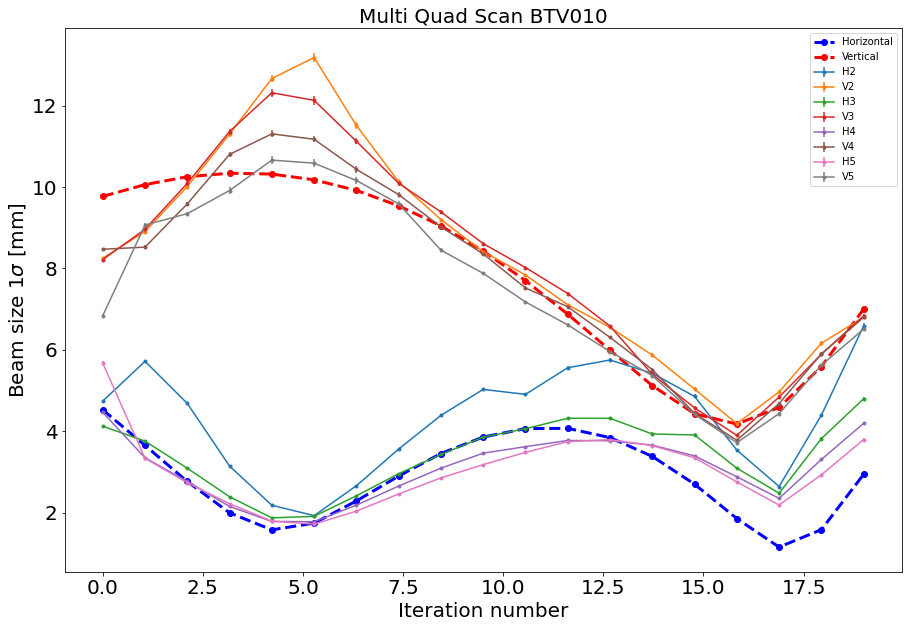

In [56]:
fig, ax = plt.subplots(figsize=(15,10))

H_sigma_list = []
V_sigma_list = []

for acq_number in [2,3,4,5]:

    H_sigma_list_i = []
    H_err_sigma_list_i = []
    V_sigma_list_i = []
    V_err_sigma_list_i = []

    for shot_number in range(len(acquisition)):
        # Horizontal
        Hx = acquisition[shot_number]["projPositionSet1"][acq_number]
        Hy = acquisition[shot_number]["projDataSet1"][acq_number]

        popt, pcov = do_gaussian_fit(Hx, Hy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        H_sigma_list_i.append(sigma)
        H_err_sigma_list_i.append(sigma_err)

        # Vertical
        Vx = acquisition[shot_number]["projPositionSet2"][acq_number]
        Vy = acquisition[shot_number]["projDataSet2"][acq_number]

        popt, pcov = do_gaussian_fit(Vx, Vy)
        mu = popt[2]
        mu_err = pcov[2, 2] ** 0.5
        sigma = abs(popt[3])
        sigma_err = pcov[3, 3] ** 0.5

        V_sigma_list_i.append(sigma)
        V_err_sigma_list_i.append(sigma_err)

        
    ax.errorbar(x_axis, H_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = H_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"H{acq_number}")
    ax.errorbar(x_axis, V_sigma_list_i[range_shots[0]:range_shots[1]:], yerr = V_err_sigma_list_i[range_shots[0]:range_shots[1]:], marker = "o", markersize=3, label = f"V{acq_number}")

    H_sigma_list.append(H_sigma_list_i)
    V_sigma_list.append(V_sigma_list_i)
    
ax.plot(x_axis, np.array(H_sigma_madx)*1000, color = "b", linestyle = "--", marker = "o", linewidth=3, label = "Horizontal")
ax.plot(x_axis, np.array(V_sigma_madx)*1000, color = "r", linestyle = "--", marker = "o", linewidth=3, label = "Vertical")


ax.legend()
ax.set_xlabel("Iteration number", fontsize=20)
ax.set_ylabel(f"Beam size 1$\sigma$ [mm]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=18)
fig.savefig("fig/madx_"+str(filename)+".png", facecolor='white', transparent=False,
                    bbox_inches='tight', dpi=150);
ax.set_title("Multi Quad Scan BTV010", fontsize = 20)